# Análise das medidas do cálculo coerência tópica do conjunto de dados CohQuAD Coe en.

Realiza a análise dos cálculos de medida de coerência topica  do conjunto de dados.

----------------------------

**Link biblioteca Transformers:**
https://github.com/huggingface/transformers

**Artigo original BERT:**
https://arxiv.org/pdf/1506.06724.pdf

**Artigo padding dinâmico:**
https://towardsdatascience.com/divide-hugging-face-transformers-training-time-by-2-or-more-21bf7129db9q-21bf7129db9e

# 1 Preparação do ambiente
Preparação do ambiente para execução do exemplo.

## 1.1 Tempo inicial de processamento

In [ ]:
# Import das bibliotecas
import time
import datetime

#marca o tempo de início do processamento.
inicio_processamento = time.time()

## 1.2 Funções e classes auxiliares

Verifica se existe o diretório cohebert no diretório corrente.   


In [ ]:
# Import das bibliotecas.
import os # Biblioteca para manipular arquivos

# ============================  
def verificaDiretorioCoheBERT():
    """
      Verifica se existe o diretório cohebert no diretório corrente.    
    """
    
    # Verifica se o diretório existe
    if not os.path.exists(DIRETORIO_COHEBERT):  
        # Cria o diretório
        os.makedirs(DIRETORIO_COHEBERT)
        logging.info("Diretório Cohebert criado: {}".format(DIRETORIO_COHEBERT))
    
    return DIRETORIO_COHEBERT

Realiza o download e um arquivo

In [ ]:
# Import das bibliotecas.
import requests # Biblioteca de download
from tqdm.notebook import tqdm as tqdm_notebook # Biblioteca para barra de progresso
import os # Biblioteca para manipular arquivos

def downloadArquivo(url_arquivo, nome_arquivo_destino):
    """    
      Realiza o download de um arquivo de uma url em salva em nome_arquivo_destino.
    
      Parâmetros:
        `url_arquivo` - URL do arquivo a ser feito download.      
        `nome_arquivo_destino` - Nome do arquivo a ser salvo.      
    """
    
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
    
    # Realiza o download de um arquivo em uma url
    data = requests.get(url_arquivo, stream=True)
    
    # Verifica se o arquivo existe
    if data.status_code != 200:
        logging.info("Exceção ao tentar realizar download {}. Response {}.".format(url_arquivo, data.status_code))
        data.raise_for_status()
        return

    # Recupera o nome do arquivo a ser realizado o download    
    nome_arquivo = nome_arquivo_destino.split("/")[-1]  

    # Define o nome e caminho do arquivo temporário    
    nome_arquivo_temporario = DIRETORIO_COHEBERT + "/" + nome_arquivo + "_part"
    
    logging.info("Download do arquivo: {}.".format(nome_arquivo_destino))
    
    # Baixa o arquivo
    with open(nome_arquivo_temporario, "wb") as arquivo_binario:        
        tamanho_conteudo = data.headers.get("Content-Length")        
        total = int(tamanho_conteudo) if tamanho_conteudo is not None else None
        # Barra de progresso de download
        progresso_bar = tqdm_notebook(unit="B", total=total, unit_scale=True)                
        # Atualiza a barra de progresso
        for chunk in data.iter_content(chunk_size=1024):        
            if chunk:                
                progresso_bar.update(len(chunk))
                arquivo_binario.write(chunk)
    
    # Renomeia o arquivo temporário para o arquivo definitivo
    os.rename(nome_arquivo_temporario, nome_arquivo_destino)
    
    # Fecha a barra de progresso.
    progresso_bar.close()

Remove tags de um documento

In [ ]:
def remove_tags(documento):
    """
      Remove tags de um documento
    """
    
    import re

    documento_limpo = re.compile("<.*?>")
    return re.sub(documento_limpo, "", documento)

Funções auxiliares de arquivos

In [ ]:
def carregar(nomeArquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como um único parágrafo(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.  
    """

    # Abre o arquivo
    arquivo = open(nomeArquivo, "r", encoding= encoding)
    
    paragrafo = ""
    for linha in arquivo:
        linha = linha.splitlines()
        linha = " ".join(linha)
        # Remove as tags existentes no final das linhas
        linha = remove_tags(linha)
        if linha != "":
          paragrafo = paragrafo + linha.strip() + " "
    
    # Fecha o arquivo
    arquivo.close()

    # Remove os espaços em branco antes e depois do parágrafo
    return paragrafo.strip()

In [ ]:
def carregarLista(nomeArquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como uma lista de sentenças(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.   
        `encoding` - Codificação dos caracteres do arquivo.
    """

    # Abre o arquivo
    arquivo = open(nomeArquivo, "r", encoding= encoding)
    
    sentencas = []
    for linha in arquivo:        
        linha = linha.splitlines()
        linha = " ".join(linha)
        linha = remove_tags(linha)
        if linha != "":
          sentencas.append(linha.strip())
    
    # Fecha o arquivo
    arquivo.close()

    return sentencas 

In [ ]:
def salvar(nomeArquivo,texto):                       
    """
      Salva um texto em arquivo.
     
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser salvo.
        `texto` - Texto a ser salvo.     
    """

    arquivo = open(nomeArquivo, "w")
    arquivo.write(str(texto))
    arquivo.close()

Função auxiliar para formatar o tempo como `hh: mm: ss`

In [ ]:
# Import das bibliotecas.
import time
import datetime

def formataTempo(tempo):
    """
      Pega a tempo em segundos e retorna uma string hh:mm:ss
    """
    # Arredonda para o segundo mais próximo.
    tempo_arredondado = int(round((tempo)))
    
    # Formata como hh:mm:ss
    return str(datetime.timedelta(seconds=tempo_arredondado))    

Classe(ModeloArgumentosMedida) de definição dos parâmetros do modelo para medida

In [ ]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModeloArgumentosMedida:
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={'help': 'max seq len'},
    )    
    pretrained_model_name_or_path: str = field(
        default='neuralmind/bert-base-portuguese-cased',
        metadata={'help': 'nome do modelo pré-treinado do BERT.'},
    )
    modelo_spacy: str = field(
        default="pt_core_news_lg",
        metadata={"help": "nome do modelo do spaCy."},
    )
    versao_modelo_spacy: str = field(
        default="-3.2.0",
        metadata={"help": "versão do nome do modelo no spaCy."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={'help': 'define se o texto do modelo deve ser todo em minúsculo.'},
    )  
    output_attentions: bool = field(
        default=False,
        metadata={'help': 'habilita se o modelo retorna os pesos de atenção.'},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={'help': 'habilita gerar as camadas ocultas do modelo.'},
    )
    use_wandb : bool = field(
        default=True,
        metadata={'help': 'habilita o uso do wandb.'},
    )
    salvar_avaliacao : bool = field(
        default=True,
        metadata={'help': 'habilita o salvamento do resultado da avaliação.'},
    )     
    salvar_medicao : bool = field(
        default=False,
        metadata={'help': 'habilita o salvamento da medicao.'},
    )
    usar_mcl_ajustado : bool = field(
        default=False,
        metadata={'help': 'habilita o carragamento de mcl ajustado.'},
    )
    estrategia_medida: int = field(
        default=0, # 0 - MEAN estratégia média / 1 - MAX  estratégia maior
        metadata={'help': 'Estratégia de cálculo da médida dos embeddings.'},
    )
    filtro_palavra: int = field(
        default=0, # 0 - Considera todas as palavras das sentenças / 1 - Desconsidera as stopwords / 2 - Considera somente as palavras substantivas
        metadata={'help': 'Define o filtro de palavras das sentenças para gerar os embeddings.'},
    )

Biblioteca de limpeza de tela


In [ ]:
# Import das bibliotecas.
from IPython.display import clear_output

## 1.3 Tratamento de logs

In [ ]:
# Import das bibliotecas.
import logging # Biblioteca de logging

# Formatando a mensagem de logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## 1.4  Identificando o ambiente Colab

In [ ]:
# Import das bibliotecas.
import sys # Biblioteca para acessar módulos do sistema

# Se estiver executando no Google Colaboratory
# Retorna true ou false se estiver no Google Colaboratory
IN_COLAB = "google.colab" in sys.modules

## 1.5 Colaboratory

Usando Colab GPU para Treinamento


Uma GPU pode ser adicionada acessando o menu e selecionando:

`Edit -> Notebook Settings -> Hardware accelerator -> (GPU)`

Em seguida, execute a célula a seguir para confirmar que a GPU foi detectada.

In [ ]:
# Import das bibliotecas.
import tensorflow as tf

# Recupera o nome do dispositido da GPU.
device_name = tf.test.gpu_device_name()

# O nome do dispositivo deve ser parecido com o seguinte:
if device_name == "/device:GPU:0":
    logging.info("Encontrei GPU em: {}".format(device_name))
else:
    logging.info("Dispositivo GPU não encontrado")
    #raise SystemError("Dispositivo GPU não encontrado")

INFO:root:Dispositivo GPU não encontrado


Nome da GPU

Para que a torch use a GPU, precisamos identificar e especificar a GPU como o dispositivo. Posteriormente, em nosso ciclo de treinamento, carregaremos dados no dispositivo.

Vale a pena observar qual GPU você recebeu. A GPU Tesla P100 é muito mais rápido que as outras GPUs, abaixo uma lista ordenada:
- 1o Tesla P100
- 2o Tesla T4
- 3o Tesla P4 (Não tem memória para execução 4 x 8, somente 2 x 4)
- 4o Tesla K80 (Não tem memória para execução 4 x 8, somente 2 x 4)

In [ ]:
# Import das bibliotecas.
import torch

def getDeviceGPU():
    """
      Retorna um dispositivo de GPU se disponível ou CPU.
    
      Retorno:
        `device` - Um device de GPU ou CPU.       
    """
        
    # Se existe GPU disponível.
    if torch.cuda.is_available():
        
        # Diz ao PyTorch para usar GPU.    
        device = torch.device("cuda")
        
        logging.info("Existem {} GPU(s) disponíveis.".format(torch.cuda.device_count()))
        logging.info("Iremos usar a GPU: {}.".format(torch.cuda.get_device_name(0)))

    # Se não.
    else:        
        logging.info("Sem GPU disponível, usando CPU.")
        device = torch.device("cpu")
        
    return device

In [ ]:
# Recupera o device com GPU ou CPU
device = getDeviceGPU()

INFO:root:Sem GPU disponível, usando CPU.


Memória

Memória disponível no ambiente

In [ ]:
# Importando as bibliotecas.
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
logging.info("Seu ambiente de execução tem {: .1f} gigabytes de RAM disponível\n".format(ram_gb))

if ram_gb < 20:
  logging.info("Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> \"Alterar tipo de tempo de execução\"")
  logging.info("e selecione High-RAM. Então, execute novamente está célula")
else:
  logging.info("Você está usando um ambiente de execução de memória RAM alta!")

INFO:root:Seu ambiente de execução tem  13.6 gigabytes de RAM disponível

INFO:root:Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> "Alterar tipo de tempo de execução"
INFO:root:e selecione High-RAM. Então, execute novamente está célula


## 1.6 Monta uma pasta no google drive para carregar os arquivos de dados.

In [ ]:
# import necessário
from google.colab import drive

# Monta o drive na pasta especificada
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2 Parametrização

## Gerais

In [ ]:
# Nome base das saidas do projeto
NOME_BASE_SAIDA = "MedidaTopicoCohQuADCoen_v1"

# Definição dos parâmetros a serem avaliados

## Específicos

Parâmetros do modelo

## Nome do diretório dos arquivos de dados

In [ ]:
# Diretório do cohebert
DIRETORIO_COHEBERT = "COHQUAD_CO_EN"

## Define o caminho para os arquivos de dados

In [ ]:
# Diretório local para os arquivos pré-processados
DIRETORIO_LOCAL = "/content/" + DIRETORIO_COHEBERT + "/"

# Diretório no google drive com os arquivos pré-processados
DIRETORIO_DRIVE = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/"

# 3 Resultado do Cálculo das Medidas de (In)coerência

In [ ]:
CONJUNTO_DADOS = 'CohQuAD Inc en'

## 3.1 Carrega os dados das medidas 

### 3.1.1 Função que encontra a melhor mensuração

In [ ]:
# Import das bibliotecas.
import os
import pandas as pd

def getResultadosMensuracaoTopico(_DIRETORIO_COHEBERT, 
                                     _DOCUMENTOS_PERTURBADOS, 
                                     _TOP_K_PREDICAO,
                                     _FILTRO_PALAVRAS = ['_sp_tap','_sp_ssw','_sp_svs'],
                                     _TAMANHO_JANELA_INICIO=1,
                                     _TAMANHO_JANELA_FIM=150):
  
  # Quantidade de documentos a serem perturbados a partir do original.    
  DOCUMENTOS_PERTURBADOS = _DOCUMENTOS_PERTURBADOS

  # Quantidade de palavras a serem recuperadas mais próximas da máscara. 
  TOP_K_PREDICAO = _TOP_K_PREDICAO

  # Quantidade de janelas.
  TAMANHO_JANELA_INICIO = _TAMANHO_JANELA_INICIO
  TAMANHO_JANELA_FIM = _TAMANHO_JANELA_FIM
  
  #["TODAS_AS_PALAVRAS", "SEM_STOPWORDS", "SOMENTE_VERBOS_SUBSTANTIVOS"]
  FILTRO_PALAVRAS_NUM = [3, 4, 5]  
  # FILTRO_PALAVRAS = ['_tap','_ssw', '_svs','_sp_tap','_sp_ssw','_sp_svs']   
  FILTRO_PALAVRAS = _FILTRO_PALAVRAS
  
  # Diretório para salvar o arquivo.
  DIRETORIO_AVALIACAO = "/content/drive/My Drive/Colab Notebooks/Data/" + _DIRETORIO_COHEBERT + "/validacao_medicao_topico_palavra/Avaliacao/"  

  lista_tempo_total = []  
  totalGeralArquivos = 0
  total_geral_registros = 0
  total_arquivos = (len(DOCUMENTOS_PERTURBADOS) *                                        
                   len(FILTRO_PALAVRAS) * 
                   (TAMANHO_JANELA_FIM-TAMANHO_JANELA_INICIO+1))
  
  print("total_arquivos =", total_arquivos) 
  
  MELHOR_DOCUMENTOS_PERTURBADOS = 0
  MELHOR_TOP_K_PREDICAO = 0
  MELHOR_TAMANHO_JANELA = 0
  MELHOR_FILTRO_PALAVRAS = 0  
  MELHOR_MEDIDA_GERAL = 0  
  MELHOR_MEDIDA_GERAL_STR = ""  
  MELHOR_RESULTADO = -1
  MELHOR_TEMPO = 0

  lista_resultados = []

  # Verifica se o diretório dos resultados existe.
  if os.path.exists(DIRETORIO_AVALIACAO):    
    arquivos = os.listdir(DIRETORIO_AVALIACAO)     
    for documentos_perturbados in DOCUMENTOS_PERTURBADOS:
      for top_k_predicao in TOP_K_PREDICAO:                  
        for tamanho_janela in range(TAMANHO_JANELA_INICIO,TAMANHO_JANELA_FIM+1):  
          for filtro_palavra in FILTRO_PALAVRAS:  
         
            for i in range(len(arquivos)):                                    
              if ((("_P_" + str(documentos_perturbados)+"_") in arquivos[i]) 
                   and (("_K_" + str(top_k_predicao)+"_") in arquivos[i])                   
                   and (filtro_palavra in arquivos[i])
                   and (("_TJ_" + str(tamanho_janela) + "_") in arquivos[i])
                   ):                              
                   
                   NOME_ARQUIVO_AVALIACAO_COMPLETO = DIRETORIO_AVALIACAO + arquivos[i]                              
                   # Verifica se o arquivo existe.
                   if os.path.isfile(NOME_ARQUIVO_AVALIACAO_COMPLETO):
                      # Carrega os dados do arquivo  
                      dados = pd.read_csv(NOME_ARQUIVO_AVALIACAO_COMPLETO, sep=';')
                        
                      # Conta o número geral de arquivos
                      totalGeralArquivos = totalGeralArquivos + 1

                      # Mostra os dados do teste da medida.
                      for index, linha in dados.iterrows():        
                          # Cálculo das estatísticas
                          # print("linha:", linha)
                          c_uci = (linha['c_uci'])
                          c_npmi = (linha['c_npmi'])                          
                          c_v = (linha['c_v'])
                          c_umass = (linha['c_umass'])                          

                          MELHOR_MEDIDA = -1
                          MELHOR_MEDIDA_STR = ""
                         
                          if c_uci >= c_v and c_v >= c_umass and c_v >= c_npmi:
                            MELHOR_MEDIDA_STR = 'c_uci'
                            MELHOR_MEDIDA = c_uci
                          else:
                            if c_npmi >= c_v and c_npmi >= c_uci and c_npmi >= c_umass:
                               MELHOR_MEDIDA_STR = 'c_npmi'
                               MELHOR_MEDIDA = c_npmi
                            else:
                              if c_v >= c_umass and c_v >= c_uci and c_v >= c_npmi:
                                MELHOR_MEDIDA_STR = 'c_v'
                                MELHOR_MEDIDA = c_v
                              else:                                
                                MELHOR_MEDIDA_STR = 'c_umass'
                                MELHOR_MEDIDA = c_umass
                              
                                  
                          if MELHOR_MEDIDA > MELHOR_RESULTADO:
                            MELHOR_DOCUMENTOS_PERTURBADOS = documentos_perturbados
                            MELHOR_TOP_K_PREDICAO = top_k_predicao
                            MELHOR_TAMANHO_JANELA = tamanho_janela
                            MELHOR_FILTRO_PALAVRAS = filtro_palavra
                            MELHOR_RESULTADO = MELHOR_MEDIDA                                
                            MELHOR_TEMPO = linha['tempo']
                            MELHOR_MEDIDA_GERAL = MELHOR_MEDIDA
                            MELHOR_MEDIDA_GERAL_STR = MELHOR_MEDIDA_STR 


                          lista_resultados.append([documentos_perturbados,
                                                   top_k_predicao,
                                                   tamanho_janela,
                                                   filtro_palavra,                                                    
                                                   c_uci,                                                   
                                                   c_npmi, 
                                                   c_v, 
                                                   c_umass,
                                                   MELHOR_MEDIDA_STR,
                                                   MELHOR_MEDIDA,                                                        
                                                   linha['tempo']])
                                                          
    # Retorno do melhor valor
    if MELHOR_MEDIDA_GERAL_STR == "c_uci":
       lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[4], reverse=True)
    else:
      if MELHOR_MEDIDA_GERAL_STR == "c_npmi":
        lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[5], reverse=True)
      else:
        if MELHOR_MEDIDA_GERAL_STR == "c_v":
          lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[6], reverse=True)  
        else:
            lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[7], reverse=True)

    return MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_TAMANHO_JANELA, MELHOR_FILTRO_PALAVRAS, MELHOR_RESULTADO, MELHOR_TEMPO, MELHOR_MEDIDA_GERAL, MELHOR_MEDIDA_GERAL_STR, lista_resultado_ordenado
  else:
      print('Diretório com os resultados não encontrado')


In [ ]:
# Parametros para o Cohebert Init
DOCUMENTOS_PERTURBADOS = [1]
TOP_K_PREDICAO = [1]
FILTRO_PALAVRAS = ['_sp_tap','_sp_ssw','_sp_svs']   
FILTRO_PALAVRAS = ['_sp_tap']   

# Recupera os melhores parâmetros
MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_TAMANHO_JANELA, MELHOR_FILTRO_PALAVRAS, MELHOR_RESULTADO, MELHOR_TEMPO, MELHOR_MEDIDA_GERAL, MELHOR_MEDIDA_GERAL_STR, lista_resultados = getResultadosMensuracaoTopico(DIRETORIO_COHEBERT, DOCUMENTOS_PERTURBADOS, TOP_K_PREDICAO, FILTRO_PALAVRAS)

total_arquivos = 150


In [ ]:
print("Parâmetros do melhor resultado do mensurador")
print("\n  Documentos Perturbados:", MELHOR_DOCUMENTOS_PERTURBADOS, 
      "\n  Top k predição        :", MELHOR_TOP_K_PREDICAO,       
      "\n  Tamanho Janela        :", MELHOR_TAMANHO_JANELA, 
      "\n  Filtro                :", MELHOR_FILTRO_PALAVRAS, 
      "\n  Resultado             :", MELHOR_RESULTADO, 
      "\n  Medida                :", MELHOR_MEDIDA_GERAL_STR,       
      "\n  Tempo execução        :", MELHOR_TEMPO)

print("\nLista dos resultados ranqueados")
for i, linha in enumerate(lista_resultados):
    print((i+1),"=", linha)

Parâmetros do melhor resultado do mensurador

  Documentos Perturbados: 1 
  Top k predição        : 1 
  Tamanho Janela        : 9 
  Filtro                : _sp_tap 
  Resultado             : 0.95 
  Medida                : c_npmi 
  Tempo execução        : 0:00:18

Lista dos resultados ranqueados
1 = [1, 1, 9, '_sp_tap', 0.95, 0.95, 0.45, 0.9, 'c_npmi', 0.95, '0:00:18']
2 = [1, 1, 10, '_sp_tap', 0.95, 0.95, 0.45, 0.9, 'c_npmi', 0.95, '0:00:18']
3 = [1, 1, 11, '_sp_tap', 0.95, 0.95, 0.45, 0.9, 'c_npmi', 0.95, '0:00:18']
4 = [1, 1, 7, '_sp_tap', 0.9, 0.9, 0.5, 0.9, 'c_npmi', 0.9, '0:00:18']
5 = [1, 1, 8, '_sp_tap', 0.9, 0.9, 0.45, 0.9, 'c_npmi', 0.9, '0:00:19']
6 = [1, 1, 12, '_sp_tap', 0.95, 0.9, 0.4, 0.9, 'c_umass', 0.9, '0:00:18']
7 = [1, 1, 4, '_sp_tap', 0.85, 0.85, 0.25, 0.9, 'c_umass', 0.9, '0:00:17']
8 = [1, 1, 16, '_sp_tap', 0.85, 0.85, 0.5, 0.9, 'c_umass', 0.9, '0:00:17']
9 = [1, 1, 23, '_sp_tap', 0.85, 0.85, 0.7, 0.9, 'c_umass', 0.9, '0:00:19']
10 = [1, 1, 24, '_sp_tap', 0.8

### Por Medida

In [ ]:
# Import das bibliotecas.
import os
import pandas as pd

def getResultadosMensuracaoTopicoMedida(_DIRETORIO_COHEBERT, 
                                     _DOCUMENTOS_PERTURBADOS, 
                                     _TOP_K_PREDICAO,
                                     _FILTRO_PALAVRAS = ['_sp_tap','_sp_ssw','_sp_svs'],
                                     _TAMANHO_JANELA_INICIO=1,
                                     _TAMANHO_JANELA_FIM=150,
                                     _MEDIDA = 'c_uci'):
  
  # Quantidade de documentos a serem perturbados a partir do original.    
  DOCUMENTOS_PERTURBADOS = _DOCUMENTOS_PERTURBADOS

  # Quantidade de palavras a serem recuperadas mais próximas da máscara. 
  TOP_K_PREDICAO = _TOP_K_PREDICAO

  # Quantidade de janelas.
  TAMANHO_JANELA_INICIO = _TAMANHO_JANELA_INICIO
  TAMANHO_JANELA_FIM = _TAMANHO_JANELA_FIM
  
  #["TODAS_AS_PALAVRAS", "SEM_STOPWORDS", "SOMENTE_VERBOS_SUBSTANTIVOS"]
  FILTRO_PALAVRAS_NUM = [3, 4, 5]  
  # FILTRO_PALAVRAS = ['_tap','_ssw', '_svs','_sp_tap','_sp_ssw','_sp_svs']   
  FILTRO_PALAVRAS = _FILTRO_PALAVRAS
  
  # Diretório para salvar o arquivo.
  DIRETORIO_AVALIACAO = "/content/drive/My Drive/Colab Notebooks/Data/" + _DIRETORIO_COHEBERT + "/validacao_medicao_topico_palavra/Avaliacao/"  

  lista_tempo_total = []  
  totalGeralArquivos = 0
  total_geral_registros = 0
  total_arquivos = (len(DOCUMENTOS_PERTURBADOS) *                                        
                   len(FILTRO_PALAVRAS) * 
                   (TAMANHO_JANELA_FIM-TAMANHO_JANELA_INICIO+1))
  
  print("total_arquivos =", total_arquivos) 
  
  MELHOR_DOCUMENTOS_PERTURBADOS = 0
  MELHOR_TOP_K_PREDICAO = 0
  MELHOR_TAMANHO_JANELA = 0
  MELHOR_FILTRO_PALAVRAS = 0  
  MELHOR_MEDIDA_GERAL = 0  
  MELHOR_MEDIDA_GERAL_STR = ""  
  MELHOR_RESULTADO = -1
  MELHOR_TEMPO = 0

  lista_resultados = []

  # Verifica se o diretório dos resultados existe.
  if os.path.exists(DIRETORIO_AVALIACAO):    
    arquivos = os.listdir(DIRETORIO_AVALIACAO)     
    for documentos_perturbados in DOCUMENTOS_PERTURBADOS:
      for top_k_predicao in TOP_K_PREDICAO:                  
        for tamanho_janela in range(TAMANHO_JANELA_INICIO,TAMANHO_JANELA_FIM+1):  
          for filtro_palavra in FILTRO_PALAVRAS:  
         
            for i in range(len(arquivos)):                                    
              if ((("_P_" + str(documentos_perturbados)+"_") in arquivos[i]) 
                   and (("_K_" + str(top_k_predicao)+"_") in arquivos[i])                   
                   and (filtro_palavra in arquivos[i])
                   and (("_TJ_" + str(tamanho_janela) + "_") in arquivos[i])
                   ):                              
                   
                   NOME_ARQUIVO_AVALIACAO_COMPLETO = DIRETORIO_AVALIACAO + arquivos[i]                              
                   # Verifica se o arquivo existe.
                   if os.path.isfile(NOME_ARQUIVO_AVALIACAO_COMPLETO):
                      # Carrega os dados do arquivo  
                      dados = pd.read_csv(NOME_ARQUIVO_AVALIACAO_COMPLETO, sep=';')
                        
                      # Conta o número geral de arquivos
                      totalGeralArquivos = totalGeralArquivos + 1

                      # Mostra os dados do teste da medida.
                      for index, linha in dados.iterrows():        
                          # Cálculo das estatísticas
                          
                          c_uci = (linha[_MEDIDA])

                          MELHOR_MEDIDA = c_uci
                          MELHOR_MEDIDA_STR = _MEDIDA
                                  
                          if MELHOR_MEDIDA > MELHOR_RESULTADO:
                            MELHOR_DOCUMENTOS_PERTURBADOS = documentos_perturbados
                            MELHOR_TOP_K_PREDICAO = top_k_predicao
                            MELHOR_TAMANHO_JANELA = tamanho_janela
                            MELHOR_FILTRO_PALAVRAS = filtro_palavra
                            MELHOR_RESULTADO = MELHOR_MEDIDA                                
                            MELHOR_TEMPO = linha['tempo']
                            MELHOR_MEDIDA_GERAL = MELHOR_MEDIDA
                            MELHOR_MEDIDA_GERAL_STR = MELHOR_MEDIDA_STR 


                          lista_resultados.append([documentos_perturbados,
                                                   top_k_predicao,
                                                   tamanho_janela,
                                                   filtro_palavra,
                                                   _MEDIDA,
                                                   c_uci,
                                                   linha['tempo']])
                                                          
    # Retorno do melhor valor
    lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[5], reverse=True)
    
    return MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_TAMANHO_JANELA, MELHOR_FILTRO_PALAVRAS, MELHOR_RESULTADO, MELHOR_TEMPO, MELHOR_MEDIDA_GERAL, MELHOR_MEDIDA_GERAL_STR, lista_resultado_ordenado
  else:
      print('Diretório com os resultados não encontrado')


#### C_UCI

In [ ]:
# Parametros para o Cohebert Init
DOCUMENTOS_PERTURBADOS = [1]
TOP_K_PREDICAO = [1]
FILTRO_PALAVRAS = ['_sp_tap','_sp_ssw','_sp_svs']   
MEDIDA = 'c_uci' 

# Recupera os melhores parâmetros
MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_TAMANHO_JANELA, MELHOR_FILTRO_PALAVRAS, MELHOR_RESULTADO, MELHOR_TEMPO, MELHOR_MEDIDA_GERAL, MELHOR_MEDIDA_GERAL_STR, lista_resultados = getResultadosMensuracaoTopicoMedida(DIRETORIO_COHEBERT, DOCUMENTOS_PERTURBADOS, TOP_K_PREDICAO, FILTRO_PALAVRAS, _MEDIDA=MEDIDA)

total_arquivos = 450


In [ ]:
print("Parâmetros do melhor resultado do mensurador")
print("\n  Documentos Perturbados:", MELHOR_DOCUMENTOS_PERTURBADOS, 
      "\n  Top k predição        :", MELHOR_TOP_K_PREDICAO,       
      "\n  Tamanho Janela        :", MELHOR_TAMANHO_JANELA, 
      "\n  Filtro                :", MELHOR_FILTRO_PALAVRAS, 
      "\n  Resultado             :", MELHOR_RESULTADO, 
      "\n  Medida                :", MELHOR_MEDIDA_GERAL_STR,       
      "\n  Tempo execução        :", MELHOR_TEMPO)

print("\nLista dos resultados ranqueados")
for i, linha in enumerate(lista_resultados):
    print((i+1),"=", linha)

Parâmetros do melhor resultado do mensurador

  Documentos Perturbados: 1 
  Top k predição        : 1 
  Tamanho Janela        : 3 
  Filtro                : _sp_ssw 
  Resultado             : 1.0 
  Medida                : c_uci 
  Tempo execução        : 0:00:13

Lista dos resultados ranqueados
1 = [1, 1, 3, '_sp_ssw', 'c_uci', 1.0, '0:00:13']
2 = [1, 1, 4, '_sp_ssw', 'c_uci', 1.0, '0:00:14']
3 = [1, 1, 3, '_sp_svs', 'c_uci', 0.95, '0:00:15']
4 = [1, 1, 9, '_sp_tap', 'c_uci', 0.95, '0:00:18']
5 = [1, 1, 10, '_sp_tap', 'c_uci', 0.95, '0:00:18']
6 = [1, 1, 11, '_sp_tap', 'c_uci', 0.95, '0:00:18']
7 = [1, 1, 12, '_sp_tap', 'c_uci', 0.95, '0:00:18']
8 = [1, 1, 12, '_sp_svs', 'c_uci', 0.95, '0:00:16']
9 = [1, 1, 13, '_sp_svs', 'c_uci', 0.95, '0:00:16']
10 = [1, 1, 14, '_sp_svs', 'c_uci', 0.95, '0:00:16']
11 = [1, 1, 15, '_sp_ssw', 'c_uci', 0.95, '0:00:14']
12 = [1, 1, 15, '_sp_svs', 'c_uci', 0.95, '0:00:16']
13 = [1, 1, 16, '_sp_ssw', 'c_uci', 0.95, '0:00:14']
14 = [1, 1, 16, '_sp_svs', 

#### C_NPMI

In [ ]:
# Parametros para o Cohebert Init
DOCUMENTOS_PERTURBADOS = [1]
TOP_K_PREDICAO = [1]
FILTRO_PALAVRAS = ['_sp_tap','_sp_ssw','_sp_svs']   
MEDIDA = 'c_npmi' 

# Recupera os melhores parâmetros
MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_TAMANHO_JANELA, MELHOR_FILTRO_PALAVRAS, MELHOR_RESULTADO, MELHOR_TEMPO, MELHOR_MEDIDA_GERAL, MELHOR_MEDIDA_GERAL_STR, lista_resultados = getResultadosMensuracaoTopicoMedida(DIRETORIO_COHEBERT, DOCUMENTOS_PERTURBADOS, TOP_K_PREDICAO, FILTRO_PALAVRAS, _MEDIDA=MEDIDA)

total_arquivos = 450


In [ ]:
print("Parâmetros do melhor resultado do mensurador")
print("\n  Documentos Perturbados:", MELHOR_DOCUMENTOS_PERTURBADOS, 
      "\n  Top k predição        :", MELHOR_TOP_K_PREDICAO,       
      "\n  Tamanho Janela        :", MELHOR_TAMANHO_JANELA, 
      "\n  Filtro                :", MELHOR_FILTRO_PALAVRAS, 
      "\n  Resultado             :", MELHOR_RESULTADO, 
      "\n  Medida                :", MELHOR_MEDIDA_GERAL_STR,       
      "\n  Tempo execução        :", MELHOR_TEMPO)

print("\nLista dos resultados ranqueados")
for i, linha in enumerate(lista_resultados):
    print((i+1),"=", linha)

Parâmetros do melhor resultado do mensurador

  Documentos Perturbados: 1 
  Top k predição        : 1 
  Tamanho Janela        : 3 
  Filtro                : _sp_ssw 
  Resultado             : 1.0 
  Medida                : c_npmi 
  Tempo execução        : 0:00:13

Lista dos resultados ranqueados
1 = [1, 1, 3, '_sp_ssw', 'c_npmi', 1.0, '0:00:13']
2 = [1, 1, 4, '_sp_ssw', 'c_npmi', 1.0, '0:00:14']
3 = [1, 1, 3, '_sp_svs', 'c_npmi', 0.95, '0:00:15']
4 = [1, 1, 6, '_sp_ssw', 'c_npmi', 0.95, '0:00:14']
5 = [1, 1, 9, '_sp_tap', 'c_npmi', 0.95, '0:00:18']
6 = [1, 1, 10, '_sp_tap', 'c_npmi', 0.95, '0:00:18']
7 = [1, 1, 11, '_sp_tap', 'c_npmi', 0.95, '0:00:18']
8 = [1, 1, 12, '_sp_svs', 'c_npmi', 0.95, '0:00:16']
9 = [1, 1, 13, '_sp_svs', 'c_npmi', 0.95, '0:00:16']
10 = [1, 1, 14, '_sp_svs', 'c_npmi', 0.95, '0:00:16']
11 = [1, 1, 15, '_sp_ssw', 'c_npmi', 0.95, '0:00:14']
12 = [1, 1, 15, '_sp_svs', 'c_npmi', 0.95, '0:00:16']
13 = [1, 1, 16, '_sp_ssw', 'c_npmi', 0.95, '0:00:14']
14 = [1, 1, 16

#### C_V

In [ ]:
# Parametros para o Cohebert Init
DOCUMENTOS_PERTURBADOS = [1]
TOP_K_PREDICAO = [1]
FILTRO_PALAVRAS = ['_sp_tap','_sp_ssw','_sp_svs']   
MEDIDA = 'c_v' 

# Recupera os melhores parâmetros
MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_TAMANHO_JANELA, MELHOR_FILTRO_PALAVRAS, MELHOR_RESULTADO, MELHOR_TEMPO, MELHOR_MEDIDA_GERAL, MELHOR_MEDIDA_GERAL_STR, lista_resultados = getResultadosMensuracaoTopicoMedida(DIRETORIO_COHEBERT, DOCUMENTOS_PERTURBADOS, TOP_K_PREDICAO, FILTRO_PALAVRAS, _MEDIDA=MEDIDA)

total_arquivos = 450


In [ ]:
print("Parâmetros do melhor resultado do mensurador")
print("\n  Documentos Perturbados:", MELHOR_DOCUMENTOS_PERTURBADOS, 
      "\n  Top k predição        :", MELHOR_TOP_K_PREDICAO,       
      "\n  Tamanho Janela        :", MELHOR_TAMANHO_JANELA, 
      "\n  Filtro                :", MELHOR_FILTRO_PALAVRAS, 
      "\n  Resultado             :", MELHOR_RESULTADO, 
      "\n  Medida                :", MELHOR_MEDIDA_GERAL_STR,       
      "\n  Tempo execução        :", MELHOR_TEMPO)

print("\nLista dos resultados ranqueados")
for i, linha in enumerate(lista_resultados):
    print((i+1),"=", linha)

Parâmetros do melhor resultado do mensurador

  Documentos Perturbados: 1 
  Top k predição        : 1 
  Tamanho Janela        : 15 
  Filtro                : _sp_svs 
  Resultado             : 1.0 
  Medida                : c_v 
  Tempo execução        : 0:00:16

Lista dos resultados ranqueados
1 = [1, 1, 15, '_sp_svs', 'c_v', 1.0, '0:00:16']
2 = [1, 1, 20, '_sp_svs', 'c_v', 1.0, '0:00:18']
3 = [1, 1, 21, '_sp_svs', 'c_v', 1.0, '0:00:19']
4 = [1, 1, 9, '_sp_svs', 'c_v', 0.95, '0:00:16']
5 = [1, 1, 12, '_sp_svs', 'c_v', 0.95, '0:00:16']
6 = [1, 1, 13, '_sp_svs', 'c_v', 0.95, '0:00:16']
7 = [1, 1, 14, '_sp_svs', 'c_v', 0.95, '0:00:16']
8 = [1, 1, 16, '_sp_ssw', 'c_v', 0.95, '0:00:14']
9 = [1, 1, 16, '_sp_svs', 'c_v', 0.95, '0:00:16']
10 = [1, 1, 17, '_sp_ssw', 'c_v', 0.95, '0:00:14']
11 = [1, 1, 17, '_sp_svs', 'c_v', 0.95, '0:00:17']
12 = [1, 1, 18, '_sp_svs', 'c_v', 0.95, '0:00:18']
13 = [1, 1, 19, '_sp_svs', 'c_v', 0.95, '0:00:16']
14 = [1, 1, 22, '_sp_svs', 'c_v', 0.95, '0:00:17']
1

#### C_UMASS

In [ ]:
# Parametros para o Cohebert Init
DOCUMENTOS_PERTURBADOS = [1]
TOP_K_PREDICAO = [1]
FILTRO_PALAVRAS = ['_sp_tap','_sp_ssw','_sp_svs']   
MEDIDA = 'c_umass' 

# Recupera os melhores parâmetros
MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_TAMANHO_JANELA, MELHOR_FILTRO_PALAVRAS, MELHOR_RESULTADO, MELHOR_TEMPO, MELHOR_MEDIDA_GERAL, MELHOR_MEDIDA_GERAL_STR, lista_resultados = getResultadosMensuracaoTopicoMedida(DIRETORIO_COHEBERT, DOCUMENTOS_PERTURBADOS, TOP_K_PREDICAO, FILTRO_PALAVRAS, _MEDIDA=MEDIDA)

total_arquivos = 450


In [ ]:
print("Parâmetros do melhor resultado do mensurador")
print("\n  Documentos Perturbados:", MELHOR_DOCUMENTOS_PERTURBADOS, 
      "\n  Top k predição        :", MELHOR_TOP_K_PREDICAO,       
      "\n  Tamanho Janela        :", MELHOR_TAMANHO_JANELA, 
      "\n  Filtro                :", MELHOR_FILTRO_PALAVRAS, 
      "\n  Resultado             :", MELHOR_RESULTADO, 
      "\n  Medida                :", MELHOR_MEDIDA_GERAL_STR,       
      "\n  Tempo execução        :", MELHOR_TEMPO)

print("\nLista dos resultados ranqueados")
for i, linha in enumerate(lista_resultados):
    print((i+1),"=", linha)

### Escolhendo um resultado diferente do melhor

In [ ]:
# Carrega somente as melhores medidas para Np = 1
MELHOR_DOCUMENTOS_PERTURBADOS = 1
MELHOR_TOP_K_PREDICAO = 1

#ALL C_UCI
# Parametros para melhor de 1
# MELHOR_DOCUMENTOS_PERTURBADOS = 1
# MELHOR_TOP_K_PREDICAO = 1
# MELHOR_FILTRO_PALAVRAS = '_sp_tap'
# MELHOR_TAMANHO_JANELA = 
# MELHOR_RESULTADO = 0.60
# MELHOR_MEDIDA_GERAL_STR = 'c_uci'
# MELHOR_TEMPO = '0:00:06'
# lista_resultados = []

#ALL C_NPMI
# Parametros para melhor de 1
# MELHOR_DOCUMENTOS_PERTURBADOS = 1
# MELHOR_TOP_K_PREDICAO = 1
# MELHOR_FILTRO_PALAVRAS = '_sp_tap'
# MELHOR_TAMANHO_JANELA = 
# MELHOR_RESULTADO = 0.60
# MELHOR_MEDIDA_GERAL_STR = 'c_npmi'
# MELHOR_TEMPO = '0:00:06'
# lista_resultados = []

#ALL C_V
# Parametros para melhor de 1
# MELHOR_DOCUMENTOS_PERTURBADOS = 1
# MELHOR_TOP_K_PREDICAO = 1
# MELHOR_FILTRO_PALAVRAS = '_sp_tap'
# MELHOR_TAMANHO_JANELA = 
# MELHOR_RESULTADO = 0.60
# MELHOR_MEDIDA_GERAL_STR = 'c_v'
# MELHOR_TEMPO = '0:00:06'
# lista_resultados = []

#ALL C_UMASS
# Parametros para melhor de 1
# MELHOR_DOCUMENTOS_PERTURBADOS = 1
# MELHOR_TOP_K_PREDICAO = 1
# MELHOR_FILTRO_PALAVRAS = '_sp_tap'
# MELHOR_TAMANHO_JANELA = 
# MELHOR_RESULTADO = 0.60
# MELHOR_MEDIDA_GERAL_STR = 'c_umass'
# MELHOR_TEMPO = '0:00:06'
# lista_resultados = []

### 3.1.2 Função que carrega os parâmetros do resultado da melhor mensuração

In [ ]:
def carregaMedidasTopicaCompactada(MODELO_BERT, 
                   TAMANHO_BERT, 
                   MODELO, 
                   DOCUMENTOS_PERTURBADOS, 
                   TOP_K_PREDICOES,
                   EQUACAO_MEDIDA, 
                   ESTRATEGIA_MEDIDA, 
                   FILTRO_PALAVRAS):
  # Import das bibliotecas.
  import os
  import pandas as pd

  # Nome arquivo a ser aberto
  NOME_ARQUIVO_MEDICAO = NOME_BASE_SAIDA + "_P_" + str(DOCUMENTOS_PERTURBADOS) + "_K_" + str(TOP_K_PREDICOES) + EQUACAO_MEDIDA + ESTRATEGIA_MEDIDA + FILTRO_PALAVRAS + MODELO_BERT + TAMANHO_BERT + MODELO

  # Diretório do drive do arquivo
  DIRETORIO_MEDICAO_DRIVE = DIRETORIO_DRIVE + "validacao_medicao_palavra/Medicao/"

  # Diretório local para salvar o arquivo
  DIRETORIO_MEDICAO_LOCAL = DIRETORIO_LOCAL + "Medicao/"

  # Verifica se o diretório existe
  if not os.path.exists(DIRETORIO_MEDICAO_LOCAL):  
    # Cria o diretório
    os.makedirs(DIRETORIO_MEDICAO_LOCAL)
    logging.info("Diretório criado: {}.".format(DIRETORIO_MEDICAO_LOCAL))
  else:
    logging.info("Diretório já existe: {}.".format(DIRETORIO_MEDICAO_LOCAL))

  # Verifica se o diretório dos resultados existem.
  if os.path.exists(DIRETORIO_MEDICAO_DRIVE):        

    # Caminho completo do arquivo compactado no drive
    NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO = DIRETORIO_MEDICAO_DRIVE + NOME_ARQUIVO_MEDICAO + ".zip"
    # print("NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO:", NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO)

    # Caminho completo do arquivo compactado no local
    NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO = DIRETORIO_MEDICAO_LOCAL + NOME_ARQUIVO_MEDICAO + ".zip"
    # print("NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO:", NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO)

    # Caminho completo do arquivo no local
    NOME_ARQUIVO_MEDICAO_LOCAL = DIRETORIO_MEDICAO_LOCAL + NOME_ARQUIVO_MEDICAO + ".csv"
    # print("NOME_ARQUIVO_MEDICAO_LOCAL:", NOME_ARQUIVO_MEDICAO_LOCAL)

    # Verifica se o arquivo existe.
    if os.path.isfile(NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO):
      
      # Copia arquivo da medição compactado do google drive para o drive local
      !cp "$NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO" "$NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO"  
                        
      # Descompacta arquivo da medição compactado no drive local
      !unzip -o -j -q "$NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO" -d "$DIRETORIO_MEDICAO_LOCAL"

      # Carrega os dados do arquivo  
      dados_medida = pd.read_csv(NOME_ARQUIVO_MEDICAO_LOCAL, sep=';')

      #print('Registros: ', len(dados_medida))
      print('Arquivo encontrado e carregado')        

      return dados_medida
      
    else:
      print('Arquivo com as medições não encontrado')        

  else:
    print('Diretório com as medições não encontrado')
  
  return None

## 3.2 Carregamento dos arquivos de dados originais e perturbados

### 3.2.1 Especifica os nomes dos arquivos de dados



In [ ]:
# Nome do arquivo
NOME_ARQUIVO_ORIGINAL = "original.csv"
NOME_ARQUIVO_ORIGINAL_COMPACTADO = "original.zip"
NOME_ARQUIVO_ORIGINAL_POS = "originalpos.csv"
NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO = "originalpos.zip"

NOME_ARQUIVO_PERTURBADO = "perturbado_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".csv"
NOME_ARQUIVO_PERTURBADO_COMPACTADO = "perturbado_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".zip"
NOME_ARQUIVO_PERTURBADO_POS = "perturbadopos_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".csv"
NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO = "perturbadopos_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".zip"

### 3.2.2 Cria o diretório local para receber os dados

In [ ]:
# Import das bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Perturbados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

INFO:root:Diretório criado: /content/COHQUAD_INIT_EN


### 3.2.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  logging.info("Terminei a cópia!")

INFO:root:Terminei a cópia!


Descompacta os arquivos.

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação!")

INFO:root:Terminei a descompactação!


### 3.2.4 Carregamento das lista com os dados dos arquivos originais e perturbados

#### Carrega o arquivo dos dados originais e POS

In [ ]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_documentos_originais = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL, sep=";", encoding="UTF-8")
lista_documentos_originais_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

INFO:root:TERMINADO ORIGINAIS: 20.
INFO:root:TERMINADO ORIGINAIS POS: 20.


In [ ]:
lista_documentos_originais.sample(5)

,id,sentencas,documento
5,6,['How to push and pop elements in a stack data...,How to push and pop elements in a stack data s...
16,17,['How are the operations to push and pop eleme...,How are the operations to push and pop element...
6,7,['How to pop elements from a stack?'],How to pop elements from a stack?
9,10,['What is a queue and how to enqueue its eleme...,What is a queue and how to enqueue its element?
15,16,['What is a queue and how to enqueue and deque...,What is a queue and how to enqueue and dequeue...


In [ ]:
lista_documentos_originais_pos.sample(5)

,id,pos_documento
8,9,"[[['What', 'is', 'a', 'stack', 'and', 'how', '..."
13,14,"[[['What', 'is', 'a', 'stack', 'and', 'how', '..."
0,1,"[[['How', 'to', 'enqueue', 'elements', 'in', '..."
19,20,"[[['In', 'a', 'queue', 'does', 'the', 'enqueue..."
5,6,"[[['How', 'to', 'push', 'and', 'pop', 'element..."


#### Corrigir os tipos de colunas dos dados originais e POS

Em dados originais:
- coluna 1 - `sentenças` carregadas do arquivo vem como string e não como lista.

Em dados originais pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

def corrigirTipoDadosColunasOriginais(lista_documentos_originais, lista_documentos_originais_pos):

  # Corrige os tipos dos dados 
  tipos = {"id": str}
  lista_documentos_originais = lista_documentos_originais.astype(tipos)
  lista_documentos_originais_pos = lista_documentos_originais_pos.astype(tipos)

  # Verifica se o tipo da coluna não é list e converte
  lista_documentos_originais["sentencas"] = lista_documentos_originais["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  lista_documentos_originais_pos["pos_documento"] = lista_documentos_originais_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  logging.info("TERMINADO CORREÇÃO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
  logging.info("TERMINADO CORREÇÃO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

  return lista_documentos_originais, lista_documentos_originais_pos

In [ ]:
lista_documentos_originais, lista_documentos_originais_pos = corrigirTipoDadosColunasOriginais(lista_documentos_originais, lista_documentos_originais_pos)

INFO:root:TERMINADO CORREÇÃO ORIGINAIS: 20.
INFO:root:TERMINADO CORREÇÃO ORIGINAIS POS: 20.


#### Criando dados indexados originais

In [ ]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_originais_indexado = lista_documentos_originais.set_index(["id"])
lista_documentos_originais_indexado.head()

,sentencas,documento
id,,
1,[How to enqueue elements in a queue?],How to enqueue elements in a queue?
2,[How to dequeue elements in a queue?],How to dequeue elements in a queue?
3,[How to push elements in a stack?],How to push elements in a stack?
4,[How to push and pop elements in a stack?],How to push and pop elements in a stack?
5,[How to push elements in a stack data structure?],How to push elements in a stack data structure?


In [ ]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_originais_pos_indexado = lista_documentos_originais_pos.set_index(["id"])
lista_documentos_originais_pos_indexado.head()

,pos_documento
id,
1,"[[[How, to, enqueue, elements, in, a, queue, ?..."
2,"[[[How, to, dequeue, elements, in, a, queue, ?..."
3,"[[[How, to, push, elements, in, a, stack, ?], ..."
4,"[[[How, to, push, and, pop, elements, in, a, s..."
5,"[[[How, to, push, elements, in, a, stack, data..."


#### Carrega o arquivo dos dados perturbados e POS

In [ ]:
# Abre o arquivo e retorna o DataFrame
lista_documentos_perturbados = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO, sep=";", encoding="UTF-8")
lista_documentos_perturbados_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO PERTURBADOS: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO PERTURBADOS POS: {}.".format(len(lista_documentos_perturbados_pos)))

INFO:root:TERMINADO PERTURBADOS: 20.
INFO:root:TERMINADO PERTURBADOS POS: 20.


Alguns csv estão com os nomes das colunas errados

In [ ]:
lista_documentos_perturbados = lista_documentos_perturbados.rename(columns={'documentoPerturbado': 'documento_perturbado'})

In [ ]:
lista_documentos_perturbados.sample(5)

,id,perturbado,documento_perturbado,sentencas
0,1_pert_0,['How to enqueue elements in a stack ?'],How to enqueue elements in a stack ?',"[['How to enqueue elements in a [MASK] ?', 'qu..."
3,4_pert_0,['How to push and pop elements in a queue ?'],How to push and pop elements in a queue ?,[['How to push and pop elements in a [MASK] ?'...
4,5_pert_0,['How to push elements in a queue data structu...,How to push elements in a queue data structure?,[['How to push elements in a [MASK] data struc...
18,19_pert_0,['In a stack does the enqueue operation occur ...,In a stack does the enqueue operation occur at...,[['In a stack does the [MASK] operation occur ...
7,8_pert_0,['How to pop elements in a queue data structur...,How to pop elements in a queue data structure ?,[['How to pop elements in a [MASK] data struct...


In [ ]:
lista_documentos_perturbados_pos.sample(5)

,id,pos_documento
8,9_pert_0,"[[['What', 'is', 'a', 'queue', 'and', 'how', '..."
17,18_pert_0,"[[['How', 'are', 'the', 'operations', 'to', 'e..."
7,8_pert_0,"[[['How', 'to', 'pop', 'elements', 'in', 'a', ..."
10,11_pert_0,"[[['What', 'is', 'a', 'stack', 'and', 'how', '..."
5,6_pert_0,"[[['How', 'to', 'push', 'and', 'pop', 'element..."


#### Corrigir os tipos de colunas dos dados perturbados e POS

Em dados perturbados:
- coluna 1 - `perturbado` carregadas do arquivo vem como string e não como lista.
- coluna 3 - `sentencas` carregadas do arquivo vem como string e não como lista.

Em dados perturbados pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

def corrigirTipoDadosColunasPerturbados(lista_documentos_perturbados, lista_documentos_perturbados_pos):

  # Corrige os tipos dos dados 
  tipos = {"id": str}
  lista_documentos_perturbados = lista_documentos_perturbados.astype(tipos)
  lista_documentos_perturbados_pos = lista_documentos_perturbados_pos.astype(tipos)

  # Verifica se o tipo da coluna não é list e converte
  lista_documentos_perturbados["perturbado"] = lista_documentos_perturbados["perturbado"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)
  lista_documentos_perturbados["sentencas"] = lista_documentos_perturbados["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  lista_documentos_perturbados_pos["pos_documento"] = lista_documentos_perturbados_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  logging.info("TERMINADO CORREÇÃO PERTURBADO: {}.".format(len(lista_documentos_perturbados)))
  logging.info("TERMINADO CORREÇÃO PERTURBADO POS: {}.".format(len(lista_documentos_perturbados_pos)))

  return lista_documentos_perturbados, lista_documentos_perturbados_pos

In [ ]:
 lista_documentos_perturbados, lista_documentos_perturbados_pos = corrigirTipoDadosColunasPerturbados(lista_documentos_perturbados, lista_documentos_perturbados_pos)

INFO:root:TERMINADO CORREÇÃO PERTURBADO: 20.
INFO:root:TERMINADO CORREÇÃO PERTURBADO POS: 20.


#### Criando dados indexados perturbados

In [ ]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_perturbados_indexado = lista_documentos_perturbados.set_index(["id"])
lista_documentos_perturbados_indexado.head()

,perturbado,documento_perturbado,sentencas
id,,,
1_pert_0,[How to enqueue elements in a stack ?],How to enqueue elements in a stack ?',"[[How to enqueue elements in a [MASK] ?, queue..."
2_pert_0,[How to dequeue elements in a stack ?],How to dequeue elements in a stack ?',"[[How to dequeue elements in a [MASK] ?, queue..."
3_pert_0,[How to push elements in a queue ?],How to push elements in a queue ?,"[[How to push elements in a [MASK] ?, stack, q..."
4_pert_0,[How to push and pop elements in a queue ?],How to push and pop elements in a queue ?,"[[How to push and pop elements in a [MASK] ?, ..."
5_pert_0,[How to push elements in a queue data structure?],How to push elements in a queue data structure?,[[How to push elements in a [MASK] data struct...


In [ ]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_perturbados_pos_indexado = lista_documentos_perturbados_pos.set_index(["id"])
lista_documentos_perturbados_pos_indexado.head()

,pos_documento
id,
1_pert_0,"[[[How, to, enqueue, elements, in, a, stack, ?..."
2_pert_0,"[[[How, to, dequeue, elements, in, a, stack, ?..."
3_pert_0,"[[[How, to, push, elements, in, a, queue, ?], ..."
4_pert_0,"[[[How, to, push, and, pop, elements, in, a, q..."
5_pert_0,"[[[How, to, push, elements, in, a, queue, data..."


### 3.2.5 Agrupar os dados originais e perturbados

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

def agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados_indexado):

  print("Processando",len(lista_documentos_originais),"documentos originais")

  lista_documentos_agrupados = []

  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

  # Percorre os documentos
  for i, linha_documento in lista_documentos_originais_bar: 
    #if i < 2:
      #print("linha_documento:",linha_documento)
      # Recupera o id do documento
      id_documento = linha_documento[0]     
      #print("id_documento:",id_documento)     
  
      # Carrega a lista das sentenças do documento
      lista_sentenca_documento = linha_documento[1]    
      #print("\nlista_sentenca_documento:",lista_sentenca_documento)
      #print("len(lista_sentenca_documento):",len(lista_sentenca_documento)) 

      # Adiciona o original a lista dos dados agrupados, considerando como coerente(1)
      lista_documentos_agrupados.append([id_documento, lista_sentenca_documento, linha_documento[2], 1])
    
      # Percorre os documentos perturbados apartir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

        # Id do documento perturbado
        id_perturbado = str(id_documento) + "_pert_" + str(j)

        # localiza o documento perturbado 
        #documento_perturbado = lista_documentos_perturbados.loc[lista_documentos_perturbados['id']==id_perturbado].values[0]
        documento_perturbado = lista_documentos_perturbados_indexado.loc[id_perturbado]
        # Recupera a sentença do documento perturbado
        lista_perturbado = documento_perturbado[0]
            
        # Adiciona o perturbado a lista dos dados agrupados considerando como incoerente(0)
        lista_documentos_agrupados.append([id_perturbado, lista_perturbado, documento_perturbado[1], 0])    

  logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

  # Cria o dataframe da lista
  lista_documentos_agrupados = pd.DataFrame(lista_documentos_agrupados, columns = ["id","sentencas","documento","classe"])

  # Corrige os tipos dos dados da lista agrupada
  tipos = {"id": str, "sentencas": object, "documento": str, "classe": int}

  lista_documentos_agrupados = lista_documentos_agrupados.astype(tipos)

  return lista_documentos_agrupados

In [ ]:
# Importa das bibliotecas
import pandas as pd

print("Analisando documentos originais e perturbados")
# Concatena as listas de documentos originais e perturbados
lista_documentos_agrupados = agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados_indexado)
lista_documentos_agrupados_pos = pd.concat([lista_documentos_originais_pos, lista_documentos_perturbados_pos])

# Corrige o tipo de dado da coluna id da lista
tipos = {"id": str}
lista_documentos_agrupados_pos = lista_documentos_agrupados_pos.astype(tipos)

Analisando documentos originais e perturbados
Processando 20 documentos originais


Documentos:   0%|          | 0/20 [00:00<?, ? documento/s]

INFO:root:TERMINADO AGRUPAMENTO: 40.


In [ ]:
logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

INFO:root:TERMINADO AGRUPAMENTO: 40.


In [ ]:
lista_documentos_agrupados.sample(5)

,id,sentencas,documento,classe
36,19,[In a stack does the pop operation occur at wh...,In a stack does the pop operation occur at whi...,1
29,15_pert_0,[What is a queue and how to push and pop its e...,What is a queue and how to push and pop its el...,0
19,10_pert_0,[What is a stack and how to enqueue its element?],What is a stack and how to enqueue its element ?,0
15,8_pert_0,[How to pop elements in a queue data structure ?],How to pop elements in a queue data structure ?,0
24,13,[What is a queue and how to enqueue an element...,What is a queue and how to enqueue an element ...,1


In [ ]:
logging.info("TERMINADO AGRUPAMENTO POS: {}.".format(len(lista_documentos_agrupados_pos)))

INFO:root:TERMINADO AGRUPAMENTO POS: 40.


#### Criar dados indexados

In [ ]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_agrupados_indexado = lista_documentos_agrupados.set_index(["id"])
lista_documentos_agrupados_indexado.head()

,sentencas,documento,classe
id,,,
1,[How to enqueue elements in a queue?],How to enqueue elements in a queue?,1
1_pert_0,[How to enqueue elements in a stack ?],How to enqueue elements in a stack ?',0
2,[How to dequeue elements in a queue?],How to dequeue elements in a queue?,1
2_pert_0,[How to dequeue elements in a stack ?],How to dequeue elements in a stack ?',0
3,[How to push elements in a stack?],How to push elements in a stack?,1


In [ ]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_agrupados_pos_indexado = lista_documentos_agrupados_pos.set_index(["id"])
lista_documentos_agrupados_pos_indexado.head()

,pos_documento
id,
1,"[[[How, to, enqueue, elements, in, a, queue, ?..."
2,"[[[How, to, dequeue, elements, in, a, queue, ?..."
3,"[[[How, to, push, elements, in, a, stack, ?], ..."
4,"[[[How, to, push, and, pop, elements, in, a, s..."
5,"[[[How, to, push, elements, in, a, stack, data..."


## 3.3 Carregando o resultado da melhor mensuração

In [ ]:
# MODELO_BERT = [MELHOR_MODELO_BERT]
# TAMANHO_BERT = [MELHOR_TAMANHO_BERT]
# MODELO = [MELHOR_MODELO] 
# DOCUMENTOS_PERTURBADOS = [MELHOR_DOCUMENTOS_PERTURBADOS]
# TOP_K_PREDICAO = [MELHOR_TOP_K_PREDICAO]
# EQUACAO_MEDIDA = [MELHOR_EQUACAO_MEDIDA]
# ESTRATEGIA_MEDIDA = [MELHOR_ESTRATEGIA_MEDIDA]
# FILTRO_PALAVRAS = [MELHOR_FILTRO_PALAVRAS]  

# dados_mensuracao = carregaMedidasCompacta(MELHOR_MODELO_BERT, 
#                                  MELHOR_TAMANHO_BERT,
#                                  MELHOR_MODELO,
#                                  MELHOR_DOCUMENTOS_PERTURBADOS, 
#                                  MELHOR_TOP_K_PREDICAO,
#                                  MELHOR_EQUACAO_MEDIDA,
#                                  MELHOR_ESTRATEGIA_MEDIDA,
#                                  MELHOR_FILTRO_PALAVRAS)

### Carrega as melhores de cada equação(CAW, CWP,CG) para Np = 1

In [ ]:
MODELO_BERT = ['_BERT', '_BERTmultilingual']
TAMANHO_BERT = ['_base','_large']
MODELO = ['_pretreinado', '_ajustado'] 
DOCUMENTOS_PERTURBADOS = [1]
TOP_K_PREDICAO = [1]
EQUACAO_MEDIDA = ['_adj','_com','_ctx'] # ['CAW - palavras adjacentes','CWP - combinação de todas as palavras','CG - contexto global']
ESTRATEGIA_MEDIDA = ['_mean', '_max']
FILTRO_PALAVRA = ['_tap','_ssw', '_ssb']  #['TODAS_AS_PALAVRAS', 'SEM_STOPWORDS', 'SOMENTE_SUBSTANTIVOS']  

# Muda somente o carregamento da equação
dados_mensuracaoCAW = carregaMedidasCompactada(MODELO_BERT[0], 
                                    TAMANHO_BERT[1], 
                                    MODELO[0],
                                    DOCUMENTOS_PERTURBADOS[0], #1
                                    TOP_K_PREDICAO[0], #1  
                                    EQUACAO_MEDIDA[0], #CAW
                                    ESTRATEGIA_MEDIDA[0],
                                    FILTRO_PALAVRA[0])

dados_mensuracaoCWP = carregaMedidasCompactada(MODELO_BERT[0], 
                                    TAMANHO_BERT[1], 
                                    MODELO[0],
                                    DOCUMENTOS_PERTURBADOS[0],#1
                                    TOP_K_PREDICAO[0], #1
                                    EQUACAO_MEDIDA[1], #CWP
                                    ESTRATEGIA_MEDIDA[0],
                                    FILTRO_PALAVRA[0])

dados_mensuracaoCG = carregaMedidasCompactada(MODELO_BERT[0], 
                                    TAMANHO_BERT[1], 
                                    MODELO[0],
                                    DOCUMENTOS_PERTURBADOS[0], #1
                                    TOP_K_PREDICAO[0], #1
                                    EQUACAO_MEDIDA[2], #CG
                                    ESTRATEGIA_MEDIDA[0],
                                    FILTRO_PALAVRA[0])

print("Registros CAW:", len(dados_mensuracaoCAW))
print("Registros CWP:", len(dados_mensuracaoCWP))
print("Registros  CG:", len(dados_mensuracaoCG))

INFO:root:Diretório criado: /content/COHQUAD_INIT_EN/Medicao/.
INFO:root:Diretório já existe: /content/COHQUAD_INIT_EN/Medicao/.


Arquivo encontrado e carregado


INFO:root:Diretório já existe: /content/COHQUAD_INIT_EN/Medicao/.


Arquivo encontrado e carregado
Arquivo encontrado e carregado
Registros CAW: 40
Registros CWP: 40
Registros  CG: 40


In [ ]:
dados_mensuracaoCAW.sample(5)

,data,arquivo,ccos,ceuc,cman
37,28/09/2022 12:50,19_pert_0,0.598831,40.256276,2023.284173
38,28/09/2022 12:50,20,0.596891,40.090962,2019.632027
26,28/09/2022 12:50,14,0.594699,40.654075,2040.266508
5,28/09/2022 12:50,3_pert_0,0.420118,42.302975,1902.224143
11,28/09/2022 12:50,6_pert_0,0.599932,39.858427,1991.359027


In [ ]:
dados_mensuracaoCWP.sample(5)

,data,arquivo,ccos,ceuc,cman
24,28/09/2022 12:51,13,0.576926,40.823421,2052.777478
11,28/09/2022 12:51,6_pert_0,0.545699,42.566681,2131.097514
22,28/09/2022 12:51,12,0.556617,41.943350,2105.743588
4,28/09/2022 12:51,3,0.447050,43.144641,1976.099729
19,28/09/2022 12:51,10_pert_0,0.583633,40.390020,2024.340135


In [ ]:
dados_mensuracaoCG.sample(5)

,data,arquivo,ccos,ceuc,cman
31,28/09/2022 12:53,16_pert_0,0.769480,27.839932,1371.401177
29,28/09/2022 12:53,15_pert_0,0.734436,28.828396,1365.163138
1,28/09/2022 12:53,1_pert_0,0.689420,28.809527,1335.514587
34,28/09/2022 12:53,18,0.760292,28.499711,1430.604084
16,28/09/2022 12:53,9,0.780766,27.903013,1397.422818


In [ ]:
def getMedidasDocumento(df_dados_medida, id_documento):

  # Corrige os tipos dos dados 
  tipos = {"arquivo": str}
  df_dados_medida = df_dados_medida.astype(tipos)
  
  # Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
  df_dados_medida = df_dados_medida.set_index(["arquivo"])

  # Separa os originais
  #df_medida = df_dados_medida.loc[df_dados_medida['arquivo']==id_documento]
  df_medida = df_dados_medida.loc[id_documento]
  
  return df_medida['ccos'],df_medida['ceuc'],df_medida['cman'],

### Separa os documentos e remove as repetições

In [ ]:
def separaDocumentos(dados_medida):
  
  # Separa os originais
  df_original_medida = dados_medida.loc[dados_medida['arquivo'].str.contains('pert')==False]
  # Remove os duplicados
  df_original_medida = df_original_medida.drop_duplicates(subset=['arquivo'])
  print('Registros Originais: ', len(df_original_medida))

  # Separa os perturbados
  df_perturbado_medida = dados_medida.loc[dados_medida['arquivo'].str.contains('pert')==True]
  # Remove os duplicados
  df_perturbado_medida = df_perturbado_medida.drop_duplicates(subset=['arquivo'])
  print('Registros Perturbados: ', len(df_perturbado_medida))

  return df_original_medida, df_perturbado_medida  

In [ ]:
df_original_mesuracaoCAW, df_perturbado_mesuracaoCAW = separaDocumentos(dados_mensuracaoCAW)
df_original_mesuracaoCWP, df_perturbado_mesuracaoCWP = separaDocumentos(dados_mensuracaoCWP)
df_original_mesuracaoCG, df_perturbado_mesuracaoCG = separaDocumentos(dados_mensuracaoCG)

Registros Originais:  20
Registros Perturbados:  20
Registros Originais:  20
Registros Perturbados:  20
Registros Originais:  20
Registros Perturbados:  20


### Organiza os pares de documentos

In [ ]:
def organizaParesDocumentos(df_original_medida, df_perturbado_medida):

  # Import das bibliotecas.
  import pandas as pd

  # Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
  df_perturbado_medida_indexado = df_perturbado_medida.set_index(["arquivo"])
  df_perturbado_medida_indexado.head()

  lista_pares_documentos_medidas = []
  # Refaz os pares de documentos
  for i, documento_orirginal in df_original_medida.iterrows():

    for j in range(0,MELHOR_DOCUMENTOS_PERTURBADOS):

      nome_arquivo_perturbado = str(documento_orirginal['arquivo']) + "_pert_" + str(j)

      documento_perturbado = df_perturbado_medida_indexado.loc[nome_arquivo_perturbado]

      lista_pares_documentos_medidas.append(
                                      [documento_orirginal['data'], 
                                       documento_orirginal['arquivo'],	
                                       documento_orirginal['ccos'], 
                                       documento_orirginal['ceuc'], 
                                       documento_orirginal['cman'],
                                       
                                       documento_perturbado['data'], 
                                       nome_arquivo_perturbado, 	
                                       documento_perturbado['ccos'], 
                                       documento_perturbado['ceuc'], 
                                       documento_perturbado['cman']])

  print('Registros antes:', len(lista_pares_documentos_medidas))

  df_lista_pares_documentos_medidas = pd.DataFrame(lista_pares_documentos_medidas, columns=('data_DO', 
                                                                                     'id_DO',
                                                                                     'ccos_DO', 
                                                                                     'ceuc_DO', 
                                                                                     'cman_DO', 
                                                                                     'data_pertDO', 
                                                                                     'id_pertDO', 
                                                                                     'ccos_pertDO', 
                                                                                     'ceuc_pertDO', 
                                                                                     'cman_pertDO')) 
  
  print('Registros depois:', len(df_lista_pares_documentos_medidas))

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id_DO": str}
  df_lista_pares_documentos_medidas = df_lista_pares_documentos_medidas.astype(tipos)

  return df_lista_pares_documentos_medidas

In [ ]:
df_lista_pares_documentos_mensuracaoCAW = organizaParesDocumentos(df_original_mesuracaoCAW, df_perturbado_mesuracaoCAW)
df_lista_pares_documentos_mensuracaoCWP = organizaParesDocumentos(df_original_mesuracaoCWP, df_perturbado_mesuracaoCWP)
df_lista_pares_documentos_mensuracaoCG = organizaParesDocumentos(df_original_mesuracaoCG, df_perturbado_mesuracaoCG)

Registros antes: 20
Registros depois: 20
Registros antes: 20
Registros depois: 20
Registros antes: 20
Registros depois: 20


In [ ]:
df_lista_pares_documentos_mensuracaoCAW.sample(5)

,data_DO,id_DO,ccos_DO,ceuc_DO,cman_DO,data_pertDO,id_pertDO,ccos_pertDO,ceuc_pertDO,cman_pertDO
6,28/09/2022 12:50,7,0.586701,39.500034,1969.902314,28/09/2022 12:50,7_pert_0,0.551914,39.488712,1914.374300
13,28/09/2022 12:50,14,0.594699,40.654075,2040.266508,28/09/2022 12:50,14_pert_0,0.619721,38.761854,1949.521117
2,28/09/2022 12:50,3,0.442672,42.451982,1908.678100,28/09/2022 12:50,3_pert_0,0.420118,42.302975,1902.224143
14,28/09/2022 12:50,15,0.529690,41.593212,1955.965025,28/09/2022 12:50,15_pert_0,0.543187,41.169606,1929.549475
4,28/09/2022 12:50,5,0.508914,41.549337,1886.723189,28/09/2022 12:50,5_pert_0,0.510295,41.446889,1886.962111


In [ ]:
df_lista_pares_documentos_mensuracaoCWP.sample(5)

,data_DO,id_DO,ccos_DO,ceuc_DO,cman_DO,data_pertDO,id_pertDO,ccos_pertDO,ceuc_pertDO,cman_pertDO
10,28/09/2022 12:51,11,0.579777,40.725729,2047.638004,28/09/2022 12:51,11_pert_0,0.569489,41.516595,2071.112221
9,28/09/2022 12:51,10,0.590157,39.629944,1987.606971,28/09/2022 12:51,10_pert_0,0.583633,40.390020,2024.340135
5,28/09/2022 12:51,6,0.467899,45.335054,2143.545661,28/09/2022 12:51,6_pert_0,0.545699,42.566681,2131.097514
11,28/09/2022 12:51,12,0.556617,41.943350,2105.743588,28/09/2022 12:51,12_pert_0,0.563217,41.499035,2088.054415
12,28/09/2022 12:51,13,0.576926,40.823421,2052.777478,28/09/2022 12:51,13_pert_0,0.568772,41.759827,2095.104276


In [ ]:
df_lista_pares_documentos_mensuracaoCG.sample(5)

,data_DO,id_DO,ccos_DO,ceuc_DO,cman_DO,data_pertDO,id_pertDO,ccos_pertDO,ceuc_pertDO,cman_pertDO
6,28/09/2022 12:53,7,0.792834,26.466698,1317.752763,28/09/2022 12:53,7_pert_0,0.768737,26.951170,1304.032994
3,28/09/2022 12:53,4,0.787954,27.267992,1362.390270,28/09/2022 12:53,4_pert_0,0.770475,27.194859,1325.207346
15,28/09/2022 12:53,16,0.771163,27.441660,1351.603817,28/09/2022 12:53,16_pert_0,0.769480,27.839932,1371.401177
18,28/09/2022 12:53,19,0.767845,28.902013,1445.914925,28/09/2022 12:53,19_pert_0,0.768126,28.724694,1435.140858
5,28/09/2022 12:53,6,0.703977,30.645739,1448.951033,28/09/2022 12:53,6_pert_0,0.763194,28.795285,1440.420333


### Retorna as medidas de um documento pelo seu índice

Uma uma lista ordenada de medidas pelo DO e depois pelo pertDO da medida

In [ ]:
def getDocumentoPeloIndiceEmMedidas(lista_medidas_documento, indice_documento_original, medida = "cos"):

  lista_medidas_documento_ordenado = lista_medidas_documento.sort_values(by=["c" + medida + "_DO", "c" + medida + "_pertDO" ])

  medida_documento = lista_medidas_documento_ordenado.iloc[indice_documento_original]
  # print("medida_documento:",medida_documento)

  id_documento_original = str(medida_documento['id_DO'])
  # print("id_documento_original:", id_documento_original)

  documento = lista_documentos_originais_indexado.loc[id_documento_original]
  
  return id_documento_original, documento

In [ ]:
def getMedidasParesDocumento(lista_medidas_documento, indice_documento_original, medida = "cos"):

  # Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
  lista_medidas_documento = lista_medidas_documento.set_index(["id_DO"])
    
  lista_medidas_documento_ordenado = lista_medidas_documento.sort_values(by=["c" + medida + "_DO", "c" + medida + "_pertDO" ])

  medidas_documento = lista_medidas_documento_ordenado.loc[indice_documento_original]
  print("medida_documentos:",len(medidas_documento))
      
  return medidas_documento

## 3.4 Estatísticas das Medidas

### Listas em pares

#### Listas de pares de documentos originais e perturbados medidos corretamente

In [ ]:
# Lista os documentos medidos corretamente
def listaMedidaCorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] >= linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])        
        lista_retorno.append(linha['id_pertDO'])
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])          
          lista_retorno.append(linha['id_pertDO'])

  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno  

In [ ]:
print("Equação CAW para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_corretamenteCAW = listaMedidaCorretamente(df_lista_pares_documentos_mensuracaoCAW,
                                                               MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_corretamente:', len(lista_retorno_medido_corretamenteCAW))

Equação CAW para a medida para : ceuc
lista_retorno_medido_corretamente: 18


In [ ]:
print("Equação CWP para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_corretamenteCWP = listaMedidaCorretamente(df_lista_pares_documentos_mensuracaoCWP,
                                                            MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_corretamente:', len(lista_retorno_medido_corretamenteCWP))

Equação CWP para a medida para : ceuc
lista_retorno_medido_corretamente: 18


In [ ]:
print("Equação CG para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_corretamenteCG = listaMedidaCorretamente(df_lista_pares_documentos_mensuracaoCG,
                                                            MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_corretamente:', len(lista_retorno_medido_corretamenteCG))

Equação CG para a medida para : ceuc
lista_retorno_medido_corretamente: 18


#### Listas de pares de documentos originais e perturbados classificados incorretamente

In [ ]:
# Lista os documentos medidos incorretamente
def listaMedidaIncorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == 'ccos':
      if linha[medida + '_DO'] < linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])        
        lista_retorno.append(linha['id_pertDO'])
    else:
       # Medida de distância (euc, man)
       if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])          
          lista_retorno.append(linha['id_pertDO'])

  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno  

In [ ]:
print("Equação CAW para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_incorretamenteCAW = listaMedidaIncorretamente(df_lista_pares_documentos_mensuracaoCAW,MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_incorretamente:', len(lista_retorno_medido_incorretamenteCAW))

print("Equação CWP para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_incorretamenteCWP = listaMedidaIncorretamente(df_lista_pares_documentos_mensuracaoCWP,MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_incorretamente:', len(lista_retorno_medido_incorretamenteCWP))

print("Equação CG para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_incorretamenteCG = listaMedidaIncorretamente(df_lista_pares_documentos_mensuracaoCG,MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_incorretamente:', len(lista_retorno_medido_incorretamenteCG))

Equação CAW para a medida para : ceuc
lista_retorno_medido_incorretamente: 22
Equação CWP para a medida para : ceuc
lista_retorno_medido_incorretamente: 22
Equação CG para a medida para : ceuc
lista_retorno_medido_incorretamente: 22


#### Acertos das listas

In [ ]:
print("Equação CAW")
total = len(lista_retorno_medido_corretamenteCAW) + len(lista_retorno_medido_incorretamenteCAW)
print("Total de documentos:", total)
print("Total de acertos   :", len(lista_retorno_medido_corretamenteCAW))
print("Total de erros     :", len(lista_retorno_medido_incorretamenteCAW))
print("Percentual acerto  :", len(lista_retorno_medido_corretamenteCAW)/total)

Equação CAW
Total de documentos: 40
Total de acertos   : 18
Total de erros     : 22
Percentual acerto  : 0.45


In [ ]:
print("Equação CWP")
total = len(lista_retorno_medido_corretamenteCWP) + len(lista_retorno_medido_incorretamenteCWP)
print("Total de documentos:", total)
print("Total de acertos   :", len(lista_retorno_medido_corretamenteCWP))
print("Total de erros     :", len(lista_retorno_medido_incorretamenteCWP))
print("Percentual acerto  :", len(lista_retorno_medido_corretamenteCWP)/total)

Equação CWP
Total de documentos: 40
Total de acertos   : 18
Total de erros     : 22
Percentual acerto  : 0.45


In [ ]:
print("Equação CG")
total = len(lista_retorno_medido_corretamenteCG) + len(lista_retorno_medido_incorretamenteCG)
print("Total de documentos:", total)
print("Total de acertos   :", len(lista_retorno_medido_corretamenteCG))
print("Total de erros     :", len(lista_retorno_medido_incorretamenteCG))
print("Percentual acerto  :", len(lista_retorno_medido_corretamenteCG)/total)

Equação CG
Total de documentos: 40
Total de acertos   : 18
Total de erros     : 22
Percentual acerto  : 0.45


#### Listas documentos originais e perturbados e suas medições sem repetições

Remove as duplicidades dos dados originais.

In [ ]:
print("Com repetição:",len(lista_retorno_medido_corretamenteCAW))
lista_retorno_medido_corretamente_sem_repeticaoCAW = lista_retorno_medido_corretamenteCAW.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_medido_corretamenteCAW))

Com repetição: 18
Sem repetição: 18


Remove as duplicidades dos dados perturbados.

In [ ]:
print("Com repetição:",len(lista_retorno_medido_incorretamenteCAW))
lista_retorno_medido_incorretamente_sem_repeticaoCAW = lista_retorno_medido_incorretamenteCAW.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_medido_incorretamente_sem_repeticaoCAW))

Com repetição: 22
Sem repetição: 22


#### Listas documentos originais e perturbados medidos corretamente

In [ ]:
print("Documentos originais e perturbados medidos corretamente(CSm(DO) >= CSm(pertDO)):", len(lista_retorno_medido_corretamenteCAW))
conta = 0
for i, linha in lista_retorno_medido_corretamenteCAW.iterrows():
  conta = conta + 1
  if i < 10:

    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]       
    print("   ", conta, documento['documento'], documento['classe'])

Documentos originais e perturbados medidos corretamente(CSm(DO) >= CSm(pertDO)): 18
    1 How to enqueue elements in a queue? 1
    2 How to enqueue elements in a stack ?' 0
    3 How to dequeue elements in a queue? 1
    4 How to dequeue elements in a stack ?' 0
    5 How to push and pop elements in a stack? 1
    6 How to push and pop elements in a queue ? 0
    7 What is a queue and how to enqueue its element? 1
    8 What is a stack and how to enqueue its element ? 0
    9 What is a queue and how to dequeue an element in it? 1
    10 What is a stack and how to dequeue an element in it ? 0


#### Listas documentos originais e perturbados medidos incorretamente

In [ ]:
print("Documentos originais e perturbados classificados incorretamente(CSm(DO) < CSm(pertDO)):", len(lista_retorno_medido_incorretamenteCAW))
conta = 0
for i, linha in lista_retorno_medido_incorretamenteCAW.iterrows():
  conta = conta + 1
  if i < 10:        
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]           
    
    print("   ", conta, documento['documento'], documento['classe'])

Documentos originais e perturbados classificados incorretamente(CSm(DO) < CSm(pertDO)): 22
    1 How to push elements in a stack? 1
    2 How to push elements in a queue ? 0
    3 How to push elements in a stack data structure? 1
    4 How to push elements in a queue data structure? 0
    5 How to push and pop elements in a stack data structure? 1
    6 How to push and pop elements in a queue data structure ? 0
    7 How to pop elements from a stack? 1
    8 How to pop elements from a queue ? 0
    9 How to pop elements in a stack data structure? 1
    10 How to pop elements in a queue data structure ? 0


### Listas

#### Lista de documentos originais(1) medidos corretamente(1)

In [ ]:
def listaOriginalMedidoCorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] >= linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])                
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno  

In [ ]:
lista_documento_original_medido_corretamenteCAW = listaOriginalMedidoCorretamente(df_lista_pares_documentos_mensuracaoCAW, MELHOR_MEDIDA_GERAL_STR)
print('lista_documento_original_medido_corretamente:', len(lista_documento_original_medido_corretamenteCAW))

lista_documento_original_medido_corretamente: 9


In [ ]:
print("Lista de documentos originais medidos corretamente(coerentes) (CSm(DO) >= CSm(pertDO)):", len(lista_documento_original_medido_corretamenteCAW))
for i, documento in lista_documento_original_medido_corretamenteCAW.iterrows():
  if i < 10:
    # Recupera o documento a ser exibido       
    documento = lista_documentos_agrupados_indexado.loc[documento["id"]]   
    
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos originais medidos corretamente(coerentes) (CSm(DO) >= CSm(pertDO)): 9
   0 - How to enqueue elements in a queue? 1
   1 - How to dequeue elements in a queue? 1
   2 - How to push and pop elements in a stack? 1
   3 - What is a queue and how to enqueue its element? 1
   4 - What is a queue and how to dequeue an element in it? 1
   5 - What is a queue and how to enqueue an element in it? 1
   6 - What is a queue and how to enqueue and dequeue its elements? 1
   7 - How are the operations to enqueue and dequeue elements in a queue implemented? 1
   8 - In a queue does the enqueue operation occur at which end? 1


#### Lista de documento originais(1) medidos incorretamente(0)

In [ ]:
def listaOriginalMedidoIncorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] < linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])                
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno  

In [ ]:
lista_documento_original_medido_incorretamenteCAW = listaOriginalMedidoIncorretamente(df_lista_pares_documentos_mensuracaoCAW, MELHOR_MEDIDA_GERAL_STR)

print("Lista de documentos originais medidos incorretamente:",len(lista_documento_original_medido_incorretamenteCAW))

Lista de documentos originais medidos incorretamente: 11


In [ ]:
print("Lista de documentos originais medidos incorretamente(incoerentes)(CSm(DO) > CSm(pertDO)):", len(lista_documento_original_medido_incorretamenteCAW))
for i, documento in lista_documento_original_medido_incorretamenteCAW.iterrows():
  if i < 10:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[documento["id"]]   
    
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos originais medidos incorretamente(incoerentes)(CSm(DO) > CSm(pertDO)): 11
   0 - How to push elements in a stack? 1
   1 - How to push elements in a stack data structure? 1
   2 - How to push and pop elements in a stack data structure? 1
   3 - How to pop elements from a stack? 1
   4 - How to pop elements in a stack data structure? 1
   5 - What is a stack and how to push its element? 1
   6 - What is a stack and how to pop an element from it? 1
   7 - What is a stack and how to push an element on it? 1
   8 - What is a stack and how to push and pop its elements? 1
   9 - How are the operations to push and pop elements in a stack implemented? 1


#### Lista Documentos Perturbados(0) medidos corretamente(0)

In [ ]:
def listaPerturbadoMedidosCorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] < linha[ medida + '_pertDO']:
         lista_retorno.append(linha['id_pertDO'])
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
           lista_retorno.append(linha['id_pertDO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno    

In [ ]:
lista_documento_perturbado_medido_corretamenteCAW  = listaPerturbadoMedidosCorretamente(df_lista_pares_documentos_mensuracaoCAW, MELHOR_MEDIDA_GERAL_STR)

print("Lista de documentos perturbados medidos corretamente:",len(lista_documento_perturbado_medido_corretamenteCAW))

Lista de documentos perturbados medidos corretamente: 11


In [ ]:
print("Lista de documentos perturbados medidos corretamente(incoerentes)(CSm(DO) >= CSm(pertDO)):", len(lista_documento_perturbado_medido_corretamenteCAW))
for i, documento in lista_documento_perturbado_medido_corretamenteCAW.iterrows():
  if i < 10:
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[documento["id"]]   
    
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos perturbados medidos corretamente(incoerentes)(CSm(DO) >= CSm(pertDO)): 11
   0 - How to push elements in a queue ? 0
   1 - How to push elements in a queue data structure? 0
   2 - How to push and pop elements in a queue data structure ? 0
   3 - How to pop elements from a queue ? 0
   4 - How to pop elements in a queue data structure ? 0
   5 - What is a queue and how to push its element ? 0
   6 - What is a queue and how to pop an element from it ? 0
   7 - What is a queue and how to push an element on it ? 0
   8 - What is a queue and how to push and pop its elements ? 0
   9 - How are the operations to push and pop elements in a queue implemented ? 0


#### Lista Documentos Perturbados(0) medidos  incorretamente(1)

In [ ]:
def listaPerturbadoMedidosIncorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] >= linha[ medida + '_pertDO']:
         lista_retorno.append(linha['id_pertDO'])
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
           lista_retorno.append(linha['id_pertDO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno    

In [ ]:
lista_documento_perturbado_medido_incorretamenteCAW = listaPerturbadoMedidosIncorretamente(df_lista_pares_documentos_mensuracaoCAW, MELHOR_MEDIDA_GERAL_STR)

print("Lista de documentos perturbados medidos incorretamente:",len(lista_documento_perturbado_medido_incorretamenteCAW))

Lista de documentos perturbados medidos incorretamente: 9


In [ ]:
print("Lista de documentos perturbados medidos incorretamente(coerentes)(CSm(DO) < CSm(pertDO)):", len(lista_documento_perturbado_medido_incorretamenteCAW))
for i, documento in lista_documento_perturbado_medido_incorretamenteCAW.iterrows():
  if i < 10:  
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[documento["id"]]   
    
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos perturbados medidos incorretamente(coerentes)(CSm(DO) < CSm(pertDO)): 9
   0 - How to enqueue elements in a stack ?' 0
   1 - How to dequeue elements in a stack ?' 0
   2 - How to push and pop elements in a queue ? 0
   3 - What is a stack and how to enqueue its element ? 0
   4 - What is a stack and how to dequeue an element in it ? 0
   5 - What is a stack and how to enqueue an element in it ? 0
   6 - What is a stack and how to enqueue and dequeue its elements ? 0
   7 - How are the operations to enqueue and dequeue elements in a stack implemented ? 0
   8 - In a queue does the push operation occur at which end ? 0


### Estatísticas medidas documentos coerentes e incoerentes

In [ ]:
def geraEstatisticas(df_lista_pares_documentos_medidas):

  # Lista das estatísticas das medidas
  stats_medidas_documentos = []

  for i, linha in df_lista_pares_documentos_medidas.iterrows():
      
      # Registra as estatística da comparação
      stats_medidas_documentos.append(
        {  
          'documento': i,                  
          'original ccos': linha['ccos_DO'],
          'perturbado ccos': linha['ccos_pertDO'],
          'dif ccos' : linha['ccos_DO'] - linha['ccos_pertDO'],
          'difabs ccos' : abs(linha['ccos_DO'] - linha['ccos_pertDO']),
          'original ceuc': linha['ceuc_DO'],
          'perturbado ceuc': linha['ceuc_pertDO'],
          'dif ceuc' : linha['ceuc_DO'] - linha['ceuc_pertDO'],
          'difabs ceuc' : abs(linha['ceuc_DO'] - linha['ceuc_pertDO']),
          'original cman': linha['cman_DO'],
          'perturbado cman': linha['cman_pertDO'],
          'dif cman' : linha['cman_DO'] - linha['cman_pertDO'],
          'difabs cman' : abs(linha['cman_DO'] - linha['cman_pertDO']),
        }
      )     
  return stats_medidas_documentos

In [ ]:
stats_mensuracao_documentos_CAW = geraEstatisticas(df_lista_pares_documentos_mensuracaoCAW)
stats_mensuracao_documentos_CWP = geraEstatisticas(df_lista_pares_documentos_mensuracaoCWP)
stats_mensuracao_documentos_CG = geraEstatisticas(df_lista_pares_documentos_mensuracaoCG)

Estatísticas de todas as Medidas

Define o formato de exibição dos números reais no dataframe.

In [ ]:
# Import das bibliotecas
import pandas as pd

pd.set_option('display.float_format', lambda x: '%.8f' %x)

Equação CAW

In [ ]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CAW)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int'])

,documento,original ccos,perturbado ccos,dif ccos,difabs ccos,original ceuc,perturbado ceuc,dif ceuc,difabs ceuc,original cman,perturbado cman,dif cman,difabs cman
count,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000
mean,9.50000000,0.56900308,0.57041816,-0.00141508,0.02961986,40.25518604,39.99957073,0.25561531,0.93242159,1967.52787848,1954.38534305,13.14253543,29.94956812
std,5.91607978,0.05083764,0.05860341,0.05431256,0.04503832,1.61589907,1.24973405,1.58721345,1.29338942,62.25054680,48.73748891,37.15635586,24.86414982
min,0.00000000,0.44267192,0.42011827,-0.10029462,0.00032044,37.94035176,38.07198372,-4.73602894,0.01132257,1864.72625556,1868.34472857,-53.97200000,0.23892222
25%,4.75000000,0.52449604,0.54973250,-0.01466911,0.00332540,39.31975409,39.13909670,-0.22753672,0.13736758,1914.96525000,1917.61726667,-10.88432860,8.25600747
50%,9.50000000,0.59407757,0.59709783,-0.00368197,0.01300211,40.02182701,39.94909868,0.05688557,0.40899682,1974.87804464,1946.54285833,6.26222143,25.35648750
75%,14.25000000,0.60314276,0.60755810,0.00178235,0.02746359,41.15333631,40.54163086,0.58479261,0.95117035,2018.05484015,1988.66526932,32.14452273,41.83151230
max,19.00000000,0.61525449,0.62090731,0.17922946,0.17922946,43.56640566,42.67638070,3.37629630,4.73602894,2069.77868462,2040.20050769,90.74539167,90.74539167


Equação CWP

In [ ]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CWP)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int'])

,documento,original ccos,perturbado ccos,dif ccos,difabs ccos,original ceuc,perturbado ceuc,dif ceuc,difabs ceuc,original cman,perturbado cman,dif cman,difabs cman
count,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000
mean,9.50000000,0.54196730,0.53969248,0.00227482,0.02590325,41.77297979,41.64424740,0.12873239,1.10804723,2048.17032520,2042.51079116,5.65953404,35.27191918
std,5.91607978,0.04703138,0.04315621,0.04491799,0.03628746,1.84422686,1.12020476,1.48449664,0.96373568,70.77465401,68.05908357,41.05878892,20.24728658
min,0.00000000,0.44705038,0.43624955,-0.07779931,0.00340517,39.14985064,39.73804457,-4.05237845,0.31209204,1935.55232500,1929.62177857,-42.32679744,12.44814697
25%,4.75000000,0.50048239,0.52864691,-0.01213244,0.00658129,40.56667707,40.53731716,-0.76385642,0.46898354,1992.26694439,1989.05178071,-33.97243206,20.45753750
50%,9.50000000,0.55864267,0.55186060,0.00389040,0.01022030,41.74657975,41.86358831,0.33329781,0.76763611,2042.59848526,2027.78016838,13.44144656,32.95487325
75%,14.25000000,0.57629730,0.56710175,0.00969534,0.02605540,42.98126145,42.49775724,0.77079135,1.28282013,2105.75483945,2096.71137146,25.18633736,39.39406900
max,19.00000000,0.59015749,0.59029730,0.15065771,0.15065771,45.67383058,43.41729206,2.76837282,4.05237845,2188.79038571,2174.35563956,88.18962692,88.18962692


Equação CG

In [ ]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CG)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int'])

,documento,original ccos,perturbado ccos,dif ccos,difabs ccos,original ceuc,perturbado ceuc,dif ceuc,difabs ceuc,original cman,perturbado cman,dif cman,difabs cman
count,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000
mean,9.50000000,0.75762313,0.75896876,-0.00134564,0.01751793,28.21951327,28.15262046,0.06689282,0.72456744,1382.63709816,1379.13447972,3.50261844,22.50569562
std,5.91607978,0.03326669,0.02655443,0.03146318,0.02586133,1.30567966,0.80005394,0.98615352,0.65159762,57.51459077,56.69829927,27.03279668,14.50936148
min,0.00000000,0.69886583,0.68941991,-0.05921753,0.00028078,26.08712554,26.77430606,-2.71406627,0.07313347,1284.25248750,1274.24610375,-29.71123250,4.31997143
25%,4.75000000,0.72402271,0.74826760,-0.01074562,0.00270889,27.39824273,27.56823012,-0.44232511,0.34364600,1339.88805250,1333.17889312,-20.53294273,12.78557842
50%,9.50000000,0.76889273,0.76843152,0.00051391,0.00657373,28.47523320,28.31711798,0.12522642,0.45637400,1387.84405524,1373.55059301,6.42533571,17.65556750
75%,14.25000000,0.78227660,0.77381009,0.00295194,0.01892439,28.86492490,28.79884577,0.47553551,0.77731039,1430.72625306,1430.90188381,14.08905656,29.35753156
max,19.00000000,0.79283419,0.79124400,0.10232039,0.10232039,31.08504922,29.60163648,1.85045385,2.71406627,1486.03088571,1481.71091429,59.73125385,59.73125385


### Estatísticas de todas as Medidas(Transposta)

In [ ]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CAW)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int']).transpose()

,count,mean,std,min,25%,50%,75%,max
documento,20.00000000,9.50000000,5.91607978,0.00000000,4.75000000,9.50000000,14.25000000,19.00000000
original ccos,20.00000000,0.56900308,0.05083764,0.44267192,0.52449604,0.59407757,0.60314276,0.61525449
perturbado ccos,20.00000000,0.57041816,0.05860341,0.42011827,0.54973250,0.59709783,0.60755810,0.62090731
dif ccos,20.00000000,-0.00141508,0.05431256,-0.10029462,-0.01466911,-0.00368197,0.00178235,0.17922946
difabs ccos,20.00000000,0.02961986,0.04503832,0.00032044,0.00332540,0.01300211,0.02746359,0.17922946
original ceuc,20.00000000,40.25518604,1.61589907,37.94035176,39.31975409,40.02182701,41.15333631,43.56640566
perturbado ceuc,20.00000000,39.99957073,1.24973405,38.07198372,39.13909670,39.94909868,40.54163086,42.67638070
dif ceuc,20.00000000,0.25561531,1.58721345,-4.73602894,-0.22753672,0.05688557,0.58479261,3.37629630
difabs ceuc,20.00000000,0.93242159,1.29338942,0.01132257,0.13736758,0.40899682,0.95117035,4.73602894
original cman,20.00000000,1967.52787848,62.25054680,1864.72625556,1914.96525000,1974.87804464,2018.05484015,2069.77868462


In [ ]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CWP)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int']).transpose()

,count,mean,std,min,25%,50%,75%,max
documento,20.00000000,9.50000000,5.91607978,0.00000000,4.75000000,9.50000000,14.25000000,19.00000000
original ccos,20.00000000,0.54196730,0.04703138,0.44705038,0.50048239,0.55864267,0.57629730,0.59015749
perturbado ccos,20.00000000,0.53969248,0.04315621,0.43624955,0.52864691,0.55186060,0.56710175,0.59029730
dif ccos,20.00000000,0.00227482,0.04491799,-0.07779931,-0.01213244,0.00389040,0.00969534,0.15065771
difabs ccos,20.00000000,0.02590325,0.03628746,0.00340517,0.00658129,0.01022030,0.02605540,0.15065771
original ceuc,20.00000000,41.77297979,1.84422686,39.14985064,40.56667707,41.74657975,42.98126145,45.67383058
perturbado ceuc,20.00000000,41.64424740,1.12020476,39.73804457,40.53731716,41.86358831,42.49775724,43.41729206
dif ceuc,20.00000000,0.12873239,1.48449664,-4.05237845,-0.76385642,0.33329781,0.77079135,2.76837282
difabs ceuc,20.00000000,1.10804723,0.96373568,0.31209204,0.46898354,0.76763611,1.28282013,4.05237845
original cman,20.00000000,2048.17032520,70.77465401,1935.55232500,1992.26694439,2042.59848526,2105.75483945,2188.79038571


In [ ]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CG)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int']).transpose()

,count,mean,std,min,25%,50%,75%,max
documento,20.00000000,9.50000000,5.91607978,0.00000000,4.75000000,9.50000000,14.25000000,19.00000000
original ccos,20.00000000,0.75762313,0.03326669,0.69886583,0.72402271,0.76889273,0.78227660,0.79283419
perturbado ccos,20.00000000,0.75896876,0.02655443,0.68941991,0.74826760,0.76843152,0.77381009,0.79124400
dif ccos,20.00000000,-0.00134564,0.03146318,-0.05921753,-0.01074562,0.00051391,0.00295194,0.10232039
difabs ccos,20.00000000,0.01751793,0.02586133,0.00028078,0.00270889,0.00657373,0.01892439,0.10232039
original ceuc,20.00000000,28.21951327,1.30567966,26.08712554,27.39824273,28.47523320,28.86492490,31.08504922
perturbado ceuc,20.00000000,28.15262046,0.80005394,26.77430606,27.56823012,28.31711798,28.79884577,29.60163648
dif ceuc,20.00000000,0.06689282,0.98615352,-2.71406627,-0.44232511,0.12522642,0.47553551,1.85045385
difabs ceuc,20.00000000,0.72456744,0.65159762,0.07313347,0.34364600,0.45637400,0.77731039,2.71406627
original cman,20.00000000,1382.63709816,57.51459077,1284.25248750,1339.88805250,1387.84405524,1430.72625306,1486.03088571


### Divide os pares das medidas das equações em listas 





In [ ]:
def divideMedidas(medida, df_lista_pares_documentos_medidas):

  # Medida do documento original 
  lista_medida_original = [linha[medida + '_DO'] for i, linha in df_lista_pares_documentos_medidas.iterrows()]
  
  # Medida do documento perturbado
  lista_medida_perturbado = [linha[medida + '_pertDO'] for i, linha in df_lista_pares_documentos_medidas.iterrows()]

  return lista_medida_original, lista_medida_perturbado

In [ ]:
# Equações CAW
lista_original_CcosCAW, lista_perturbado_CcosCAW = divideMedidas('ccos', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_CcosCAW), len(lista_perturbado_CcosCAW))

lista_original_CeucCAW, lista_perturbado_CeucCAW = divideMedidas('ceuc', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_CeucCAW), len(lista_perturbado_CeucCAW))

lista_original_CmanCAW, lista_perturbado_CmanCAW = divideMedidas('cman', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_CmanCAW), len(lista_perturbado_CmanCAW))

# Equações CWP
lista_original_CcosCWP, lista_perturbado_CcosCWP = divideMedidas('ccos', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_CcosCWP), len(lista_perturbado_CcosCWP))

lista_original_CeucCWP, lista_perturbado_CeucCWP = divideMedidas('ceuc', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_CeucCWP), len(lista_perturbado_CeucCWP))

lista_original_CmanCWP, lista_perturbado_CmanCWP = divideMedidas('cman', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_CmanCWP), len(lista_perturbado_CmanCWP))

# Equações CG
lista_original_CcosCG, lista_perturbado_CcosCG = divideMedidas('ccos', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_CcosCG), len(lista_perturbado_CcosCG))

lista_original_CeucCG, lista_perturbado_CeucCG = divideMedidas('ceuc', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_CeucCG), len(lista_perturbado_CeucCG))

lista_original_CmanCG, lista_perturbado_CmanCG = divideMedidas('cman', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_CmanCG), len(lista_perturbado_CmanCG))


20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20


### Divide os pares das medidas das equações em listas ordenadas

In [ ]:
def divideMedidasOrdenadas(medida, df_lista_pares_documentos_medidas):

  # Medida do documento original e perturbado
  lista_medida_original_perturbado = [[linha[medida + '_DO'], linha[medida + '_pertDO']] for i, linha in df_lista_pares_documentos_medidas.iterrows()]

  lista_medida_original_perturbado_ordenado = sorted(lista_medida_original_perturbado, key = lambda x: (x[0], x[1]))
  
  lista_medida_original_ordenado = [linha[0] for linha in lista_medida_original_perturbado_ordenado]  
  lista_medida_perturbado_ordenado  = [linha[1] for linha in lista_medida_original_perturbado_ordenado]

  return lista_medida_original_ordenado, lista_medida_perturbado_ordenado

In [ ]:
# Equações CAW
lista_original_ordenado_CcosCAW, lista_perturbado_ordenado_CcosCAW = divideMedidasOrdenadas('ccos', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_ordenado_CcosCAW), len(lista_perturbado_ordenado_CcosCAW))

lista_original_ordenado_CeucCAW, lista_perturbado_ordenado_CeucCAW = divideMedidasOrdenadas('ceuc', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_ordenado_CeucCAW), len(lista_perturbado_ordenado_CeucCAW))

lista_original_ordenado_CmanCAW, lista_perturbado_ordenado_CmanCAW = divideMedidasOrdenadas('cman', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_ordenado_CmanCAW), len(lista_perturbado_ordenado_CmanCAW))

# Equações CWP
lista_original_ordenado_CcosCWP, lista_perturbado_ordenado_CcosCWP = divideMedidasOrdenadas('ccos', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_CcosCWP), len(lista_perturbado_CcosCWP))

lista_original_ordenado_CeucCWP, lista_perturbado_ordenado_CeucCWP = divideMedidasOrdenadas('ceuc', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_ordenado_CeucCWP), len(lista_perturbado_ordenado_CeucCWP))

lista_original_ordenado_CmanCWP, lista_perturbado_ordenado_CmanCWP = divideMedidasOrdenadas('cman', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_ordenado_CmanCWP), len(lista_perturbado_ordenado_CmanCWP))

# Equações CG
lista_original_ordenado_CcosCG, lista_perturbado_ordenado_CcosCG = divideMedidasOrdenadas('ccos', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_ordenado_CcosCG), len(lista_perturbado_ordenado_CcosCG))

lista_original_ordenado_CeucCG, lista_perturbado_ordenado_CeucCG = divideMedidasOrdenadas('ceuc', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_ordenado_CeucCG), len(lista_perturbado_ordenado_CeucCG))

lista_original_ordenado_CmanCG, lista_perturbado_ordenado_CmanCG = divideMedidasOrdenadas('cman', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_ordenado_CmanCG), len(lista_perturbado_ordenado_CmanCG))


20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20


### Funções estatísticas

#### Conta os acertos de uma medida de distância do original

In [ ]:
# Conta os documentos originais com menor incoerencia,
# ou seja a menor distância média entre as sentenças
def acertosMedidaDistanciaOriginal(df_lista_pares_documentos_medidas, medida):

  acertos_original  = 0  
  acertos_perturbado  = 0  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    if linha['c' + medida + '_DO'] <= linha['c' + medida + '_pertDO']:
      acertos_original = acertos_original + 1
    else:
      acertos_perturbado = acertos_perturbado + 1

  resultado_original = acertos_original / len(df_lista_pares_documentos_medidas)
  resultado_perturbado = acertos_perturbado / len(df_lista_pares_documentos_medidas)

  return acertos_original, acertos_perturbado, resultado_original, resultado_perturbado

#### Conta os acertos de uma medida de distância do perturbado

In [ ]:
# Conta os documentos perturbados com maior incoerencia,
# ou seja a maior distância média entre as sentenças
def acertosMedidaDistanciaPerturbado(df_lista_pares_documentos_medidas, medida):

  acertos_original  = 0  
  acertos_perturbado  = 0  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    if linha[medida + '_DO'] > linha[ medida + '_pertDO']:      
      acertos_perturbado = acertos_perturbado + 1
    else:
      acertos_original = acertos_original + 1
      
  resultado_original = acertos_original / len(df_lista_pares_documentos_medidas)
  resultado_perturbado = acertos_perturbado / len(df_lista_pares_documentos_medidas)

  return acertos_original, acertos_perturbado, resultado_original, resultado_perturbado  

#### Conta os acertos de uma medida de similaridade do original

In [ ]:
def acertosMedidaSimilaridadeOriginal(df_lista_pares_documentos_medidas, medida):

  acertos_original  = 0
  acertos_perturbado  = 0  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    if linha['c' + medida + '_DO'] >= linha['c' + medida + '_pertDO']:
      acertos_original = acertos_original + 1
    else:
      acertos_perturbado = acertos_perturbado + 1

  resultado_original = acertos_original / len(df_lista_pares_documentos_medidas)
  resultado_perturbado = acertos_perturbado / len(df_lista_pares_documentos_medidas)

  return acertos_original, acertos_perturbado, resultado_original, resultado_perturbado  

#### Conta os acertos de uma medida de similaridade do perturbado

In [ ]:
def acertosMedidaSimilaridadePerturbado(df_lista_pares_documentos_medidas, medida):
  acertos_original  = 0
  acertos_perturbado  = 0  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
      acertos_original = acertos_original + 1
    else:
      acertos_perturbado = acertos_perturbado + 1

  resultado_original = acertos_original / len(df_lista_pares_documentos_medidas)
  resultado_perturbado = acertos_perturbado / len(df_lista_pares_documentos_medidas)

  return acertos_original, acertos_perturbado, resultado_original, resultado_perturbado  

#### Calcula o somatório da diferença absoluta entre duas medidas de documentos

In [ ]:
def getSomatorioDiferencaAbsoluta(lista_medida1, lista_medida2):
  soma = 0
  for i, linha in enumerate(lista_medida1): 
    # lista_medida2 = pertDO
    # lista_medida1 = DO
    diferenca = abs(lista_medida2[i] - lista_medida1[i])
    soma = soma + diferenca
  return soma

#### Calcula o somatório da diferença entre duas medidas de documentos

In [ ]:
def getSomatorioDiferencaAbsoluta(lista_medida1, lista_medida2):
  soma = 0
  for i, linha in enumerate(lista_medida1): 
    # lista_medida2 = pertDO
    # lista_medida1 = DO
    diferenca = abs(lista_medida2[i] - lista_medida1[i])
    soma = soma + diferenca
  return soma

#### Calcula o somatório da diferença absoluta entre as  medidas de um documento original

In [ ]:
def getSomatorioDiferencaAbsolutaDeDocumento(id_documento, medida, df_lista_pares_documentos_mensuracao):

  # Acumula as diferenças dos pares de documentos
  soma = 0

  # Seleciona as medidas do documento
  df_lista_pares_documentos_mensuracao = df_lista_pares_documentos_mensuracao.loc[df_lista_pares_documentos_mensuracao["id_DO"] == id_documento]
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
    soma = soma + diferenca

  return soma

#### Calcula o somatório da diferença entre as medidas de um documento original

In [ ]:
def getSomatorioDiferencaDeDocumento(id_documento, medida, df_lista_pares_documentos_mensuracao):

  # Acumula as diferenças dos pares de documentos
  soma = 0

  # Seleciona as medidas do documento
  df_lista_pares_documentos_mensuracao = df_lista_pares_documentos_mensuracao.loc[df_lista_pares_documentos_mensuracao["id_DO"] == id_documento]
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    diferenca = linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO']
    soma = soma + diferenca

  return soma

#### Calcula o somatório da diferença entre duas medidas ordenadas para cada documento original

In [ ]:
def getSomatorioDiferencaAbsolutaPorDocumento(medida, 
                                              df_lista_pares_documentos_mensuracao,
                                              reverso = True):

  # Acumula as diferenças dos pares de documentos
  dic_diferenca = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    # print(id_documento_original, diferenca)
    
    diferenca = abs(linha['c' + medida + '_pertDO']- linha['c' + medida + '_DO'])
    
    if id_documento_original in dic_diferenca:      
      soma = dic_diferenca.get(id_documento_original) + diferenca
      dic_diferenca.update({id_documento_original: soma})
    else:
      dic_diferenca.update({id_documento_original: diferenca})

  lista = [[chave, valor] for chave, valor in dic_diferenca.items()] 

  #ordena a lista dos somatórios
  lista_ordenada_somatorio = sorted(lista, key = lambda x: x[1] , reverse=reverso)

  # Localiza a posição no gráfico com base na lista das medidas ordenadas
  lista_medida_ordenada = getMedidasDocumentosOriginaisOrdenadaId(medida, df_lista_pares_documentos_mensuracao)

  # Lista de retorno
  lista_retorno = []

  for i, linha1 in enumerate(lista_ordenada_somatorio):
    id_documento_original = linha1[0]

    # Registro com os dados da medida
    registro = []

    # Localiza a posição no gráfico com base na lista das medidas ordenadas
    pos = -1
    for j, linha2 in enumerate(lista_medida_ordenada):
        if linha2[0] == linha1[0]:
            pos = j

    # Recupera o documento
    documento = lista_documentos_originais_indexado.loc[id_documento_original]
    
    # Cria o registro da medida
    registro.append(id_documento_original)
    registro.append(linha1[1])
    registro.append(pos+1)
    registro.append(documento[1])

    lista_retorno.append(registro)

  return lista_retorno

#### Calcula o somatório da diferença entre duas medidas ordenadas para cada documento original

In [ ]:
def getSomatorioDiferencaPorDocumento(medida, 
                                      df_lista_pares_documentos_mensuracao,
                                      tipo_medida = 0,
                                      reverso = False):

  '''
    tipo_medida{-1 - medidas abaixo da medida de DO,  0 - todas as medidas, 1 - medidas acima da medida de DO}
  '''
  # Acumula as diferenças dos pares de documentos
  dic_diferenca = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    # abaixo da medida de DO
    if tipo_medida == -1:
      if linha['c' + medida + '_pertDO'] < linha['c' + medida + '_DO']:
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          soma = dic_diferenca.get(id_documento_original) + diferenca
          dic_diferenca.update({id_documento_original: soma})
        else:
          dic_diferenca.update({id_documento_original: diferenca})
    else:
      # acima da medida de DO
      if tipo_medida == 1:
        if linha['c' + medida + '_pertDO'] > linha['c' + medida + '_DO']:
          diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
          # print(id_documento_original, diferenca)
          if id_documento_original in dic_diferenca:      
            soma = dic_diferenca.get(id_documento_original) + diferenca
            dic_diferenca.update({id_documento_original: soma})
          else:
            dic_diferenca.update({id_documento_original: diferenca})

      else:         
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          soma = dic_diferenca.get(id_documento_original) + diferenca
          dic_diferenca.update({id_documento_original: soma})
        else:
          dic_diferenca.update({id_documento_original: diferenca})

  lista = [[chave, valor] for chave, valor in dic_diferenca.items()] 

  #ordena a lista
  lista_ordenada_somatorio = sorted(lista, key = lambda x: x[1], reverse=reverso)

  # Localiza a posição no gráfico com base na lista das medidas ordenadas
  lista_medida_ordenada = getMedidasDocumentosOriginaisOrdenadaId(medida, df_lista_pares_documentos_mensuracao, False)

  # Lista de retorno
  lista_retorno = []

  for i, linha1 in enumerate(lista_ordenada_somatorio):
    
    id_documento_original = linha1[0]

    # Registro com os dados da medida
    registro = []

    # Localiza a posição no gráfico com base na lista das medidas ordenadas
    pos = -1
    for j, linha2 in enumerate(lista_medida_ordenada):
        if linha2[0] == linha1[0]:
            pos = j

    # Recupera o documento
    documento = lista_documentos_originais_indexado.loc[id_documento_original]
        
    # Cria o registro da medida
    registro.append(id_documento_original)
    registro.append(linha1[1])
    registro.append(pos+1)
    registro.append(documento[1])

    lista_retorno.append(registro)

  return lista_retorno

#### Calcula o somatório da diferença absoluta entre duas medidas de documentos de pares

In [ ]:
def getSomatorioDiferencaAbsolutaTotalDocumentos(medida, df_lista_pares_documentos_mensuracao, tipo_medida = 0):
  '''
    tipo_medida{-1 - medidas abaixo da medida de DO,  0 - todas as medidas, 1 - medidas acima da medida de DO}
  '''
  # Acumula as diferenças dos pares de documentos
  soma = 0
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 
    # abaixo da medida de DO
    if tipo_medida == -1:
      if linha['c' + medida + '_pertDO'] < linha['c' + medida + '_DO']:
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print("diferenca:", diferenca)
        soma = soma + diferenca
    else:
      # acima da medida de DO
      if tipo_medida == 1:
        if linha['c' + medida + '_pertDO'] > linha['c' + medida + '_DO']:
          diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
          # print("diferenca:", diferenca)
          soma = soma + diferenca
      else:  
        # todas as medidas
        diferenca = abs(linha['c' + medida + '_pertDO']- linha['c' + medida + '_DO'])
        # print("diferenca:", diferenca)
        soma = soma + diferenca

  return soma

#### Calcula o somatório da diferença entre duas medidas de documentos de pares

In [ ]:
def getSomatorioDiferencaTotalDocumentos(medida, 
                                         df_lista_pares_documentos_mensuracao,
                                         tipo_medida = 0
                                         ):
  
  # Retorna a lista das medidas de cada documento
  lista = getSomatorioDiferencaPorDocumento(medida, 
                                            df_lista_pares_documentos_mensuracao,
                                            tipo_medida = tipo_medida)
  
  # Calcula o somatório das diferenças
  soma = 0
  for i, linha in enumerate(lista):
    soma = soma + linha[1]
  return soma

#### Gera uma lista com o id dos documentos e as medidas ordenadas

In [ ]:
def getMedidasDocumentosOriginaisOrdenadaId(medida, 
                                            df_lista_pares_documentos_mensuracao,
                                            reverso = False):

  # Acumula as diferenças dos pares de documentos
  dic_medida = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    valor_medida = linha['c' + medida + '_DO']
    # print(id_documento_original, diferenca)
    if id_documento_original in dic_medida:      
      dic_medida.update({id_documento_original: valor_medida})
    else:
      dic_medida.update({id_documento_original: valor_medida})

  lista = [[chave, valor] for chave, valor in dic_medida.items()] 

  #ordena a lista
  lista_ordenada = sorted(lista, key = lambda x: x[1],reverse=reverso)

  return lista_ordenada

#### Calcula o somatório das maiores amplitudes entre duas medidas ordenadas para cada documento original

In [ ]:
def getMaiorAmplitudePorDocumento(medida, 
                                      df_lista_pares_documentos_mensuracao,
                                      tipo_medida = 0,
                                      reverso = False):

  '''
    tipo_medida{-1 - medidas abaixo da medida de DO,  0 - todas as medidas, 1 - medidas acima da medida de DO}
  '''
  # Guarda a maior diferença dos pares de documentos
  dic_diferenca = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    # abaixo da medida de DO
    if tipo_medida == -1:
      if linha['c' + medida + '_pertDO'] < linha['c' + medida + '_DO']:
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          if diferenca > dic_diferenca.get(id_documento_original):
            dic_diferenca.update({id_documento_original: diferenca})
        else:
          dic_diferenca.update({id_documento_original: diferenca})
    else:
      # acima da medida de DO
      if tipo_medida == 1:
        if linha['c' + medida + '_pertDO'] > linha['c' + medida + '_DO']:
          diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
          # print(id_documento_original, diferenca)
          if id_documento_original in dic_diferenca:      
            if diferenca > dic_diferenca.get(id_documento_original):
              dic_diferenca.update({id_documento_original: diferenca})
          else:
            dic_diferenca.update({id_documento_original: diferenca})

      else:         
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          if diferenca > dic_diferenca.get(id_documento_original):
            dic_diferenca.update({id_documento_original: diferenca})
        else:
          dic_diferenca.update({id_documento_original: diferenca})

  lista = [[chave, valor] for chave, valor in dic_diferenca.items()] 

  #ordena a lista
  lista_ordenada_somatorio = sorted(lista, key = lambda x: x[1], reverse=reverso)

  # Localiza a posição no gráfico com base na lista das medidas ordenadas
  lista_medida_ordenada = getMedidasDocumentosOriginaisOrdenadaId(medida, df_lista_pares_documentos_mensuracao, False)

  # Lista de retorno
  lista_retorno = []

  for i, linha1 in enumerate(lista_ordenada_somatorio):
    
    id_documento_original = linha1[0]

    # Registro com os dados da medida
    registro = []

    # Localiza a posição no gráfico com base na lista das medidas ordenadas
    pos = -1
    for j, linha2 in enumerate(lista_medida_ordenada):
        if linha2[0] == linha1[0]:
            pos = j

    # Recupera o documento
    documento = lista_documentos_originais_indexado.loc[id_documento_original]
        
    # Cria o registro da medida
    registro.append(id_documento_original)
    registro.append(linha1[1])
    registro.append(pos+1)
    registro.append(documento[1])

    lista_retorno.append(registro)

  return lista_retorno

#### Calcula o somatório das maiores amplitudes entre duas medidas de documentos de pares

In [ ]:
def getSomatorioAmplitudeTotalDocumentos(medida, 
                                         df_lista_pares_documentos_mensuracao, 
                                         tipo_medida = 0):
  '''
    tipo_medida{-1 - medidas abaixo da medida de DO,  0 - todas as medidas, 1 - medidas acima da medida de DO}
  '''
  # Acumula as diferenças dos pares de documentos
  soma = 0
  
  # Guarda a maior diferença dos pares de documentos
  dic_diferenca = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    # abaixo da medida de DO
    if tipo_medida == -1:
      if linha['c' + medida + '_pertDO'] < linha['c' + medida + '_DO']:
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          if diferenca > dic_diferenca.get(id_documento_original):
            dic_diferenca.update({id_documento_original: diferenca})
        else:
          dic_diferenca.update({id_documento_original: diferenca})
    else:
      # acima da medida de DO
      if tipo_medida == 1:
        if linha['c' + medida + '_pertDO'] > linha['c' + medida + '_DO']:
          diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
          # print(id_documento_original, diferenca)
          if id_documento_original in dic_diferenca:      
            if diferenca > dic_diferenca.get(id_documento_original):
              dic_diferenca.update({id_documento_original: diferenca})
          else:
            dic_diferenca.update({id_documento_original: diferenca})

      else:         
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          if diferenca > dic_diferenca.get(id_documento_original):
            dic_diferenca.update({id_documento_original: diferenca})
        else:
          dic_diferenca.update({id_documento_original: diferenca})

  lista = [valor for chave, valor in dic_diferenca.items()] 

  soma = sum(lista)

  return soma

### Funções dos gráficos

#### Configuração do tamanho da fonte dos gráficos

In [ ]:
import matplotlib

TAMANHO_FONTE = 22
matplotlib.rc('font', size=TAMANHO_FONTE)          # Controla o tamanho do do texto default
matplotlib.rc('axes', titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc('axes', labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc('xtick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc('ytick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc('legend', fontsize=TAMANHO_FONTE-2)    # Tamanho da fonte da legenda
matplotlib.rc('figure', titlesize=TAMANHO_FONTE)   # Tamanho da fonte do título da figura

#### Gráfico de linha da medida de (in)coerência "medida" das listas de documentos originais e suas permutações aleatórias dos MCLs.

In [ ]:
# Import da biblioteca
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np

def graficoLinhaMedida(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       lista_medidaDOBERTimbaul, 
                       lista_medidaPermBERTimbaul,
                       lista_medidaDOBERTm, 
                       lista_medidaPermBERTm,
                      medida = 'cos'):
                       
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  eixoX1 = list(range(1, len(lista_medidaDOBERTimbaub)+1))
  eixoY1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Perturbado
  eixoX2 = list(range(1, len(lista_medidaPermBERTimbaub)+1))
  eixoY2 = lista_medidaPermBERTimbaub

  # Eixo x e y de Original
  eixoX3 = list(range(1, len(lista_medidaDOBERTimbaul)+1))
  eixoY3 = lista_medidaDOBERTimbaul

  # Eixo x e y de Perturbado
  eixoX4 = list(range(1, len(lista_medidaPermBERTimbaul)+1))
  eixoY4 = lista_medidaPermBERTimbaul

  # Eixo x e y de Original
  eixoX5 = list(range(1, len(lista_medidaDOBERTm)+1))
  eixoY5 = lista_medidaDOBERTm

  # Eixo x e y de Perturbado
  eixoX6 = list(range(1, len(lista_medidaPermBERTm)+1))
  eixoY6 = lista_medidaPermBERTm

  # Título do gráfico
  # plt.title('Medida de coerência utilizando a medida de distância' + medida + ' nos\ndocumentos originais e permutados do ' + CONJUNTODADOS + ' por MCL')
  # Texto do eixo x
  plt.xlabel('DO/pertDO')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  plt.plot(eixoX1, eixoY1, 'r-', label='DO CAW'+medida) 
  # conta = 0
  # for x,y in zip(eixoX1,eixoY1):
  #   if conta%20==0: 

  #     label = "{:.2f}".format(y)

  #     plt.annotate(label, # this is the text
  #                 (x,y), # these are the coordinates to position the label
  #                 textcoords="offset points", # how to position the text
  #                 xytext=(0,20), # distance from text to points (x,y)
  #                 ha='center',
  #                  size=12) # horizontal alignment can be left, right or center
  #   conta = conta + 1 
  plt.plot(eixoX2, eixoY2, 'r--', label='pertDO CAW'+medida)

  plt.plot(eixoX3, eixoY3, 'b-', label='DO CWP'+medida)  
  # conta = 0
  # for x,y in zip(eixoX3,eixoY3):
  #   if conta%20==0: 

  #     label = "{:.2f}".format(y)

  #     plt.annotate(label, # this is the text
  #                 (x,y), # these are the coordinates to position the label
  #                 textcoords="offset points", # how to position the text
  #                 xytext=(0,20), # distance from text to points (x,y)
  #                 ha='center',
  #                  size=12) # horizontal alignment can be left, right or center
  #   conta = conta + 1
  plt.plot(eixoX4, eixoY4, 'b--', label='pertDO CWP'+medida)  

  plt.plot(eixoX5, eixoY5, 'g-', label='DO CG'+medida)
  # conta = 0
  # for x,y in zip(eixoX5,eixoY5):
  #   if conta%20==0: 

  #     label = "{:.2f}".format(y)

  #     plt.annotate(label, # this is the text
  #                 (x,y), # these are the coordinates to position the label
  #                 textcoords="offset points", # how to position the text
  #                 xytext=(0,20), # distance from text to points (x,y)
  #                 ha='center',
  #                  size=12) # horizontal alignment can be left, right or center
  #   conta = conta + 1
  plt.plot(eixoX6, eixoY6, 'g--', label='pertDO CG'+medida)

  # Insere a legenda e por padrão usa o label de cada gráfico em duas colunas na parte inferior
  plt.legend(title='Legenda:', loc=(0.05, -0.35), ncol=3)._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  if medida != 'cos':
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaub) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaub)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)
    
  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)  
  # plt.ylim(bottom = 0) 
        
  # Mostra o gráfico
  plt.show()

#### Gráfico de barra da medida de (in)coerência "medida" das listas de documentos originais e suas permutações aleatórias dos MCLs.

In [ ]:
def graficoBarraMedida(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       lista_medidaDOBERTimbaul, 
                       lista_medidaPermBERTimbaul,
                       lista_medidaDOBERTm, 
                       lista_medidaPermBERTm,                      
                       medida = 'cos'):
  
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  # Cria eixo x para x2 com base em x1 com uma separação de 0.25 entre as barras
  eixoX1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixoY1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Permutado
  eixoX2 = [x + 0.25 for x in eixoX1]
  eixoY2 = lista_medidaPermBERTimbaub

  # Eixo x e y de Original
  eixoX3 = list(range(0, len(lista_medidaDOBERTimbaul)))
  eixoY3 = lista_medidaDOBERTimbaul

  # Eixo x e y de Permutado
  eixoX4 = [x + 0.25 for x in eixoX3]
  eixoY4 = lista_medidaPermBERTimbaul

  # Eixo x e y de Original
  eixoX5 = list(range(0, len(lista_medidaDOBERTm)))
  eixoY5 = lista_medidaDOBERTm

  # Eixo x e y de Permutado
  eixoX6 = [x + 0.25 for x in eixoX5]
  eixoY6 = lista_medidaPermBERTm

  # Título do gráfico
  #plt.title('Medida de coerência utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e permutados do ' + CONJUNTODADOS + ' por MCL')
  # Texto do eixo x
  plt.xlabel('DO/pertDO')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  #plt.bar(eixoX1, eixoY1, width=0.25, color= 'r', label='DO BERTimbau base')
  #plt.bar(eixoX2, eixoY2, width=0.25, color= 'c', label='permDO BERTimbau base')

  #plt.bar(eixoX3, eixoY3, width=0.25, color= 'b', label='DO BERTimbau large')
  #plt.bar(eixoX4, eixoY4, width=0.25, color= 'k', label='permDO BERTimbau large')

  #plt.bar(eixoX5, eixoY5, width=0.25, color= 'y', label='DO BERT multilingual')
  #plt.bar(eixoX6, eixoY6, width=0.25, color= 'm', label='permDO BERT multilingual')

  # Insere os dados no gráfico
  plt.bar(eixoX1, eixoY1, width=0.25, color= 'r', label='DO CAW'+medida)
  plt.bar(eixoX2, eixoY2, width=0.25, color= 'c', label='permDO CAW'+medida)  
  plt.bar(eixoX3, eixoY3, width=0.25, color= 'b', label='DO CWP'+medida)
  plt.bar(eixoX4, eixoY4, width=0.25, color= 'k', label='permDO CWP'+medida)
  plt.bar(eixoX5, eixoY5, width=0.25, color= 'y', label='DO CG'+medida)
  plt.bar(eixoX6, eixoY6, width=0.25, color= 'm', label='permDO CG'+medida)

  # Insere a legenda e por padrão usa o label de cada gráfico em duas colunas na parte inferior
  plt.legend(title='Legenda:', loc=(0.09, -0.35), ncol=3)._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaul) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaul)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

#### Gráfico de linha da medida de (in)coerência "medida" de 2 listas de documentos originais e suas permutações aleatórias de 1 MCL.

In [ ]:
def graficoLinhaMedida2Preenchido(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       cor1='r',
                       cor2='b',
                       medida = 'cos'):
  
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  eixo_x1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixo_y1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Perturbado
  eixo_x2 = list(range(0, len(lista_medidaPermBERTimbaub)))
  eixo_y2 = lista_medidaPermBERTimbaub
  
  # Título do gráfico
  #plt.title('Medida de coerência ordenada utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e perturbados do ' + CONJUNTO_DADOS + ' por BERTimbau base')
  # Texto do eixo x
  plt.xlabel('DO/pertDO')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)
  
  # Insere os dados no gráfico
  plt.plot(eixo_x1, eixo_y1, cor1+'-', label='Doc Original') 
  plt.plot(eixo_x2, eixo_y2, cor2+'-', label='Doc Perturbado')
  plt.tight_layout()
  
  plt.fill_between(eixo_x2, eixo_y2, color=cor2)    
  plt.fill_between(eixo_x1, eixo_y1, color=cor1)

  # Insere a legenda e por padrão usa o label de cada gráfico.
  plt.legend(title='Legenda:')._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaub) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaub)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)


  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

Gráfico de linha dos documentos Cohebert Auto originais e perturbados por ordem crescente de incoerência calculada através da medida e distâncias entre sentenças medidas através do valor da medida dos respectivos embeddings do BERTimbau base.

In [ ]:
def graficoLinhaMedida2(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       cor='r',
                       medida = 'cos'):
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  eixo_x1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixo_y1 = sorted(lista_medidaDOBERTimbaub)

  # Eixo x e y de Perturbado
  eixo_x2 = list(range(0, len(lista_medidaPermBERTimbaub)))
  eixo_y2 = sorted(lista_medidaPermBERTimbaub)
  
  # Título do gráfico
  #plt.title('Medida de coerência ordenada utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e perturbados do ' + CONJUNTO_DADOS + ' por BERTimbau base')
  # Texto do eixo x
  plt.xlabel('DO/pertDO')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  plt.plot(eixo_x1, eixo_y1, cor+'-', label='Doc Original')
  plt.plot(eixo_x2, eixo_y2, cor+'--', label='Doc Perturbado')

  # Insere a legenda e por padrão usa o label de cada gráfico.
  plt.legend(title='Legenda:')._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaub) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaub)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

#### Gráfico de barra da medida de (in)coerência "medida" das listas de documentos originais e suas permutações aleatórias dos MCLs.

In [ ]:
def graficoBarraMedidaOrdenada(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       lista_medidaDOBERTimbaul, 
                       lista_medidaPermBERTimbaul,
                       lista_medidaDOBERTm, 
                       lista_medidaPermBERTm,
                       medida = 'cos'):
  
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  # Cria eixo x para x2 com base em x1 com uma separação de 0.25 entre as barras
  eixo_x1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixo_y1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Perturbado
  eixo_x2 = [x + 0.25 for x in eixo_x1]
  eixo_y2 = lista_medidaPermBERTimbaub

  # Eixo x e y de Original
  eixo_x3 = list(range(0, len(lista_medidaDOBERTimbaul)))
  eixo_y3 = lista_medidaDOBERTimbaul

  # Eixo x e y de Perturbado
  eixo_x4 = [x + 0.25 for x in eixo_x3]
  eixo_y4 = lista_medidaPermBERTimbaul

  # Eixo x e y de Original
  eixo_x5 = list(range(0, len(lista_medidaDOBERTm)))
  eixo_y5 = lista_medidaDOBERTm

  # Eixo x e y de Perturbado
  eixo_x6 = [x + 0.25 for x in eixo_x5]
  eixo_y6 = lista_medidaPermBERTm

  # Título do gráfico
  # plt.title('Medida de coerência ordenada utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e perturbados do ' + CONJUNTO_DADOS + ' por MCL')
  # Texto do eixo x
  plt.xlabel('Documento')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  #plt.bar(eixo_x1, eixo_y1, width=0.25, color= 'r', label='DO BERTimbau base')
  #plt.bar(eixo_x2, eixo_y2, width=0.25, color= 'c', label='pertDO BERTimbau base')

  #plt.bar(eixo_x3, eixo_y3, width=0.25, color= 'b', label='DO BERTimbau large')
  #plt.bar(eixo_x4, eixo_y4, width=0.25, color= 'k', label='pertDO BERTimbau large')

  #plt.bar(eixo_x5, eixo_y5, width=0.25, color= 'y', label='DO BERT multilingual')
  #plt.bar(eixo_x6, eixo_y6, width=0.25, color= 'm', label='pertDO BERT multilingual')

  # Insere os dados no gráfico
  plt.bar(eixo_x1, eixo_y1, width=0.25, color= 'r', label='DO CAW'+medida)
  plt.bar(eixo_x2, eixo_y2, width=0.25, color= 'c', label='pertDO CAW'+medida)

  plt.bar(eixo_x3, eixo_y3, width=0.25, color= 'b', label='DO CWP'+medida)
  plt.bar(eixo_x4, eixo_y4, width=0.25, color= 'k', label='pertDO CWP'+medida)
  
  plt.bar(eixo_x5, eixo_y5, width=0.25, color= 'y', label='DO CG'+medida)
  plt.bar(eixo_x6, eixo_y6, width=0.25, color= 'm', label='pertDO CG'+medida)

  # Insere a legenda e por padrão usa o label de cada gráfico em duas colunas na parte inferior
  plt.legend(title='Legenda:', loc=(0.09, -0.41), ncol=3)._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaul) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaul)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

#### Gráfico de barra da medida de (in)coerência "medida" **ordenada crescentemente** de  documentos originais e suas permutações aleatórias de 1 MCL.

In [ ]:
def graficoBarraMedida2(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       medida = 'cos'):
  
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  # Cria eixo x para x2 com base em x1 com uma separação de 0.25 entre as barras
  eixo_x1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixo_y1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Perturbado
  eixo_x2 = [x + 0.25 for x in eixo_x1]
  eixo_y2 = lista_medidaPermBERTimbaub

  # Título do gráfico
  #plt.title('Medida de coerência ordenada utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e perturbados do ' + CONJUNTO_DADOS + ' no MCL BERTimbau base')
  # Texto do eixo x
  plt.xlabel('DO/pertDO')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  plt.bar(eixo_x1, eixo_y1, width=0.25, color= 'r', label='Doc Original')
  plt.bar(eixo_x2, eixo_y2, width=0.25, color= 'c', label='Doc Perturbado')
  
  # Insere a legenda e por padrão usa o label de cada gráfico.
  plt.legend(title='Legenda:')._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaub) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaub)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

### Funções auxiliares

###### getEstrategiaMedidaStr

In [ ]:
def getEstrategiaMedidaStr(estrategia_medida):
  if estrategia_medida == 0:
    return "MEAN - Média dos tokens"
  else:
    if estrategia_medida == 1:
      return "MAX - Máximo dos tokens"
    else:
      return None

###### getFiltroPalavraStr

In [ ]:
def getFiltroPalavraStr(filtro_palavra):
  if filtro_palavra == 0:
    return "ALL - Todas as palavras"
  else:
    if filtro_palavra == 1:
      return "CLEAN - Sem as stopwords"
    else:
      if filtro_palavra == 2:
        return "REL - Somente verbos(aux) e substantivos"
      else:
        return None

###### getEquacaoMedidaStr

In [ ]:
def getEquacaoMedidaStr(equacao_medida):
  if equacao_medida == 0:
    return "CAW - Palavras adjacentes"
  else:
    if equacao_medida == 1:
      return "CWP - Todos os pares de palavras"
    else:
      if equacao_medida == 2:
        return "CG - Contexto global"
      else:
        return None     

###### getEquacaoMedidaStrCurto

In [ ]:
def getEquacaoMedidaStrCurto(equacao_medida):
  if equacao_medida == 0:
    return "CAW"
  else:
    if equacao_medida == 1:
      return "CWP"
    else:
      if equacao_medida == 2:
        return "CG"
      else:
        return None   

###### getDadosDocumento

Recuperar os dados de documentos originais ou perturbados.

In [ ]:
def getDadosDocumento(_id_documento):
  """
    Recupera os dados de um documento. Procura na lista de documentos originais e documentos perturbados.
    
    Parâmetros:
      `_id_documento` - Um id de documento original o perturbado.
      
    Retorno:
      `documento_original` - Um texto com o documento. 
      `lista_sentenca_documento_original` - Uma lista com as sentenças do documento.
      `lista_tokens_documento_original` - Uma lista com os tokens do documento.
      `lista_pos_documento_original` - Uma lista com os PoS-Tagging do documento.
  
  """

  # print("_id_documento:",_id_documento)
  # Procurar nos documentos perturbados
  if "_pert_" in str(_id_documento):
    # localiza os dados do documento perturbado 
    reg_documento_perturbado = lista_documentos_perturbados_indexado.loc[_id_documento]
        
    # Recupera as sentenças do documento perturbado
    lista_sentenca_documento_perturbado = reg_documento_perturbado["perturbado"]
    # Recupera o documento perturbado
    documento_perturbado = reg_documento_perturbado["documento_perturbado"]  

    # Recupera as POS Tagging do documento perturbado
    tokens_perturbado = []
    tokens_perturbado_pos = []        
    reg_perturbado_pos = lista_documentos_perturbados_pos_indexado.loc[_id_documento]
    #print("reg_perturbado_pos:",reg_perturbado_pos)
    pos_documento_perturbado = reg_perturbado_pos['pos_documento']
    for i, linha2 in enumerate(pos_documento_perturbado):
      tokens_perturbado.append(linha2[0])
      tokens_perturbado_pos.append(linha2[1])

    # Recupera os tokens e pos do documento perturbado
    lista_tokens_documento_perturbado = tokens_perturbado
    lista_pos_documento_perturbado = tokens_perturbado_pos

    return documento_perturbado, lista_sentenca_documento_perturbado, lista_tokens_documento_perturbado, lista_pos_documento_perturbado
  else:
    # Procurar nos documentos originais
    # localiza os dados do documento original                                     
    reg_documento_original = lista_documentos_originais_indexado.loc[_id_documento]

    # Recupera as sentenças do documento orriginal    
    lista_sentenca_documento_original = reg_documento_original["sentencas"]     
    #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
    #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
    # Recupera o documento Original
    documento_original = reg_documento_original["documento"]    
          
    # Recupera as POS Tagging do documento original
    documentos_originais_pos = lista_documentos_originais_pos_indexado.loc[_id_documento]
    # print("documentos_originais_pos:", documentos_originais_pos)
    # print("len(documentos_originais_pos):", len(documentos_originais_pos))

    # Recupera os tokens e POS do documento original
    tokens_original = []
    tokens_original_pos = []    
    reg_original_pos = lista_documentos_originais_pos_indexado.loc[_id_documento] 
    # print("reg_original_pos:",reg_original_pos)    
    pos_documento_original = reg_original_pos['pos_documento']
    for i, linha2 in enumerate(pos_documento_original):      
      tokens_original.append(linha2[0])
      tokens_original_pos.append(linha2[1])
              
    # Recupera os tokens e pos do documento original
    lista_tokens_documento_original = tokens_original
    lista_pos_documento_original = tokens_original_pos

    return documento_original, lista_sentenca_documento_original, lista_tokens_documento_original, lista_pos_documento_original

###### getDadosPerturbacao

In [ ]:
def getDadosPerturbacao(_id_perturbado):
  
  # localiza os dados do documento perturbado mascarado
  reg_documento_perturbado = lista_documentos_perturbados_indexado.loc[_id_perturbado]

  # Recupera a lista das sentenças perturbadas
  lista_sentencas_mascarada = reg_documento_perturbado[2]

  # Índice da sentença perturbada
  index_sentenca = -1

  # Percorre as sentenças para encontrar a sentença perturbada
  for i, linha in enumerate(lista_sentencas_mascarada):

    # Identifica a sentença mascarada que foi perturbada
    if 'MASK' in linha[0] :
      # Recupera a palavra mascarada sentença do documento perturbado
      index_sentenca = i
      sentenca_mascarada = linha[0]
      palavra_mascarada = linha[1]
      token_predito = linha[2]
      peso_predito = linha[3] 

  return index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito

###### getPosPalavraSentenca

In [ ]:
def getPosPalavraSentenca(sentenca_token, sentenca_pos, token_procura):

  pos_token_procura = "" 
  # print("token_procura:",token_procura)
  # print("sentenca_token:", sentenca_token)
  # print("sentenca_pos:",sentenca_pos)
    
  for i, sentenca in enumerate(sentenca_token):
    # print("sentenca:", sentenca)
    for j, token_sentenca in enumerate(sentenca):
        # print("token_sentenca:", token_sentenca)        
        if token_sentenca == token_procura:
          # print("sentenca_pos[i][j]:", sentenca_pos[i][j])
          pos_token_procura = sentenca_pos[i][j]
  
  return pos_token_procura

###### getIndicePalavraMascarada

In [ ]:
def getIndicePalavraMascarada(sentenca_mascarada):

  palavras = sentenca_mascarada.split()
  indice_token_procura = -1  
    
  for i, palavra in enumerate(palavras):
    # print("palavra:", palavra)
    if palavra == '[MASK]':
       indice_token_procura = i      
  
  return indice_token_procura

###### getLinhaMedida

In [ ]:
def getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida):
  
  linha = str(x[1] 
              + " [" 
              + x[2] 
              + "(" 
              + melhorDO 
              + trataNumero(x[indice_palavra_selecionada]) 
              + ") -> "  
              + x[4] 
              + "(" 
              + melhor_pertDO 
              + trataNumero(x[indice_palavra_substituida]) 
              + ")" 
              + " - " 
              + trataNumero(x[6]) 
              + "] - " 
              + str(x[7]))
  return linha

###### getLinhaMedidaExibicao

In [ ]:
def getLinhaMedidaExibicao(x, equacao_medida, medida, indice_palavra_selecionada, indice_palavra_substituida):
  
  # similaridade do cosseno euclidiana(busca a maior distância)
  if medida == 'cos':
    if x[indice_palavra_selecionada] >= x[indice_palavra_substituida]: #cos
      # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento      
      melhorDO = ">"
      melhor_pertDO = ""
              
    else:
      # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
      melhorDO = ""
      melhor_pertDO = ">"              
            
  else:
    # distância euclidiana(busca a menor distância)          
    if x[indice_palavra_selecionada] <= x[indice_palavra_substituida]: #euc e man  
      # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento      
      melhorDO = ">"
      melhor_pertDO = ""              
              
    else:
      # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
      melhorDO = ""
      melhor_pertDO = ">"

  palavra_igual = "0"
  if x[2] == x[4]:
    palavra_igual = "1"
  
  pos_igual = "0"
  if x[3] == x[5]:
    pos_igual = "1"

  eqDO = getEquacaoMedidaStrCurto(equacao_medida) + medida + "(DO)="
  eqpertDO = getEquacaoMedidaStrCurto(equacao_medida) + medida + "(pertDO)="
  linha = str(x[1] + 
              " [" + 
              x[2] +               
              "(" +               
              melhorDO + 
              eqDO +
              trataNumero(x[indice_palavra_selecionada]) + 
              ") -> " + 
              x[4] +
              "(" + 
              melhor_pertDO + 
              eqpertDO +
              trataNumero(x[indice_palavra_substituida]) + 
              ")" +               
              "] - " + 
              x[3] + 
              "/" + 
              x[5] + 
              "-" + 
              pos_igual + 
              "-" + 
              palavra_igual)
  return linha

###### getLinhaMedidaExibicaoCSV

In [ ]:
def getLinhaMedidaExibicaoCSV(x):
  
  # Se palavra selecionado diferente a palavra perturbada  
  # 1 - Igual
  # 0 - Diferente
  palavra_igual = "0"  
  if x[2] == x[4]:
    # Se palavra selecionada é igual da palavra selecionada
    palavra_igual = "1"
  
  # Muda PoS-Tag da palavra selecionada igual da palavra selecionada
  # 1 - Igual
  # 0 - Diferente
  pos_igual = "0"
  if x[3] == x[5]:
    # Se PoS-Tag da palavra selecionada igual da palavra selecioanda
    pos_igual = "1"

  linha = str(x[0] +
              ";" +
              x[1] + 
              ";" + 
              x[2] +               
              ";" +               
              x[3] + 
              ";" + 
              trataNumero(x[8]) + 
              ";" + 
              trataNumero(x[9]) + 
              ";" + 
              trataNumero(x[10]) + 
              ";" + 
              x[4] +
              ";" +
              x[5] +
              ";" +               
              trataNumero(x[11]) + 
              ";" + 
              trataNumero(x[12]) + 
              ";" + 
              trataNumero(x[13]) + 
              ";" +     
              trataNumero(x[6]) + 
              ";" +
              palavra_igual + 
              ";" +
              pos_igual)
  return linha

###### trataNumero

In [ ]:
def trataNumero(numero, casas_decimais=10):
    # Converte o número para string
    # Troca "." por vírgula
    # Especifica o número de casas decimais
    return str(format(numero, "." + str(casas_decimais) + "f")).replace(".", ",")

###### visualizaMedidasEquacao

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

def visualizaMedidasEquacao(_id_documento_original,
                             equacao_medida = 0,
                             medida = 'euc',
                             estrategia_medida = 0,
                             filtro_palavra = 0):
 

  print("Equação medida   :", getEquacaoMedidaStr(equacao_medida))
  print("Medida           :", medida)
  print("Estratégia medida:", getEstrategiaMedidaStr(estrategia_medida))
  print("Filtro palavra   :", getFiltroPalavraStr(filtro_palavra))

  # Lista as medidas de um documento ou de todos
  lista_documentos = lista_documentos_originais.loc[lista_documentos_originais['id']==_id_documento_original]
        
  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos))

  # Percorre os documentos
  for i, linha in lista_documentos_originais_bar:   

    # Limita a quantidade de dados a serem exibidas
    #if i < 2:    
    # Procura um documento específico
    #if "Em uma fila a operação de enfileirar ocorre em qual extremidade" in linha['documento']:

      # Recupera o id do documento original
      id_documento_original = linha['id']

      # print("id_documento_original:",id_documento_original) 
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
      # Recupera o documento Original
      # print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))
            
      #Mostra o documento original e sua classificação
      print("\nidDO: " + id_documento_original)
      print("DO: " + linha["documento"])    
      pos_concatenado = ""
      # Concatena as pos do documento
      for doc_pos1 in documento_original_pos:
        # print("doc_pos1",doc_pos1)
        for doc_pos2 in doc_pos1:
          pos_concatenado = pos_concatenado + doc_pos2 + " "
      print("    " + " " + pos_concatenado)
      
      # Lista com documentos perturbados e sua medida
      lista_perturbado_medidas = []

      # Percorre os documentos perturbados e suas classificações a partir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

          # Id do documento perturbado
          id_perturbado = str(linha['id']) + "_pert_" + str(j)
          #id_perturbado = str(int(linha['id']) + 1)
          # print("id_perturbado:",id_perturbado)

          # Localiza os dados do documento perturbado
          documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
          # Recupera o documento perturrbado
          #print("documento_perturbado:",documento_perturbado)
          #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
          #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
          #print("documento_perturbado_tokens:",documento_perturbado_tokens)
          #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
          #print("documento_perturbado_pos:",documento_perturbado_pos)
          #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

          # Recupera a sentença mascarada e seus dados do documento perturbado
          index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)
          
          # Encontrar o índice da palavra mascarada
          index_wi = getIndicePalavraMascarada(sentenca_mascarada)

          palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
          #print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)          
          token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos, token_predito)
          # print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

          CAWcos_DO, CAWeuc_DO, CAWman_DO = getMedidasDocumento(df_original_mesuracaoCAW ,id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CAWcos_DO, CAWeuc_DO, CAWman_DO)

          CWPcos_DO, CWPeuc_DO, CWPman_DO = getMedidasDocumento(df_original_mesuracaoCWP, id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CWPcos_DO, CWPeuc_DO, CWPman_DO)

          CGcos_DO, CGeuc_DO, CGman_DO = getMedidasDocumento(df_original_mesuracaoCG, id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CGcos_DO, CGeuc_DO, CGman_DO)

          CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCAW , id_perturbado)
          # print("    pertDO :", token_predito, " - ", CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO)

          CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCWP ,id_perturbado)
          # print("    pertDO :", token_predito, " - ", CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO)

          CGcos_pertDO, CGeuc_pertDO, CGman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCG ,id_perturbado)
          # print("    pertDO :", token_predito, " - ", CGcos_DO, CGeuc_DO, CGman_DO)

          if medida == 'cos':
            CAW_DO = CAWcos_DO
            CWP_DO = CWPcos_DO
            CG_DO = CGcos_DO
            CAW_pertDO = CAWcos_pertDO
            CWP_pertDO = CWPcos_pertDO
            CG_pertDO = CGcos_pertDO
          else:
            if medida == 'euc':
              CAW_DO = CAWeuc_DO
              CWP_DO = CWPeuc_DO
              CG_DO = CGeuc_DO
              CAW_pertDO = CAWeuc_pertDO
              CWP_pertDO = CWPeuc_pertDO
              CG_pertDO = CGeuc_pertDO
            else:
              if medida == 'man':
                CAW_DO = CAWman_DO
                CWP_DO = CWPman_DO
                CG_DO = CGman_DO
                CAW_pertDO = CAWman_pertDO
                CWP_pertDO = CWPman_pertDO
                CG_pertDO = CGman_pertDO

          lista_perturbado_medidas.append([str(id_documento_original) + "_pert_" + str(j), #0
                                                          documento_perturbado,                   #1
                                                          palavra_mascarada,                      #2
                                                          palavra_mascarada_classe,               #3
                                                          token_predito,                          #4
                                                          token_predito_classe,                   #5
                                                          peso_predito,                           #6
                                                          0,                                      #7
                                                          CAW_DO,                                 #8
                                                          CWP_DO,                                 #9
                                                          CG_DO,                                  #10
                                                          CAW_pertDO,                             #11
                                                          CWP_pertDO,                             #12
                                                          CG_pertDO,                              #13
                                                          ]) 
            
      # CAW
      if equacao_medida == 0:
        indice_palavra_selecionada = 8 # índice palavra original selecionada
        indice_palavra_substituida = 11 # índice palavra substiuída
      
      else:        
        # CWP
        if equacao_medida == 1:          
          indice_palavra_selecionada = 9 # índice palavra original selecionada
          indice_palavra_substituida = 12 # índice palavra substituída
      
        else:          
          # CG
          if equacao_medida == 2:
            indice_palavra_selecionada = 10 # índice palavra original selecionada
            indice_palavra_substituida = 13 # índice palavra substituída

      # Ordena as listas     
      lista_perturbado_medidas = sorted(lista_perturbado_medidas, key=lambda x: (x[indice_palavra_selecionada], x[indice_palavra_substituida]))

      # Mostra os dados dos documentos perturbados
      for i, x in enumerate(lista_perturbado_medidas):
        linha = getLinhaMedidaExibicao(x, equacao_medida, medida, indice_palavra_selecionada, indice_palavra_substituida)
        print("  " + str(i+1), "- " + linha)            

###### visualizaMedidasEquacoesCSV

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

def visualizaMedidasEquacoesCSV(_id_documento_original,                             
                             medida = 'euc',
                             estrategia_medida = 0,
                             filtro_palavra = 0):   
  print("Medida           :", medida)
  print("Estratégia medida:", getEstrategiaMedidaStr(estrategia_medida))
  print("Filtro palavra   :", getFiltroPalavraStr(filtro_palavra))

  # Lista as medidas de um documento ou de todos
  lista_documentos = lista_documentos_originais.loc[lista_documentos_originais['id']==_id_documento_original]
        
  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos))

  # Percorre os documentos
  for i, linha in lista_documentos_originais_bar:   

    # Limita a quantidade de dados a serem exibidas
    #if i < 2:    
    # Procura um documento específico
    #if "Em uma fila a operação de enfileirar ocorre em qual extremidade" in linha['documento']:

      # Recupera o id do documento original
      id_documento_original = linha['id']

      # print("id_documento_original:",id_documento_original) 
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
      # Recupera o documento Original
      #print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))
            
      #Mostra o documento original e sua classificação
      print("\nidDO: " + id_documento_original)
      print("DO: " + linha["documento"])    
      pos_concatenado = ""
      # Concatena as pos do documento
      for doc_pos1 in documento_original_pos:
        # print("doc_pos1",doc_pos1)
        for doc_pos2 in doc_pos1:
          pos_concatenado = pos_concatenado + doc_pos2 + " "
      print("    " + " " + pos_concatenado)
      
      # Lista com documentos perturbados e sua medida
      lista_perturbado_medidas = []

      # Percorre os documentos perturbados e suas classificações a partir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

          # Id do documento perturbado
          id_perturbado = str(linha['id']) + "_pert_" + str(j)
          #id_perturbado = str(int(linha['id']) + 1)
          # print("id_perturbado:",id_perturbado)

          # Localiza os dados do documento perturbado
          documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
          # Recupera o documento perturrbado
          #print("documento_perturbado:",documento_perturbado)
          #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
          #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
          #print("documento_perturbado_tokens:",documento_perturbado_tokens)
          #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
          #print("documento_perturbado_pos:",documento_perturbado_pos)
          #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

          # Recupera a sentença mascarada e seus dados do documento perturbado
          index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)
          
          # Encontrar o índice da palavra mascarada
          index_wi = getIndicePalavraMascarada(sentenca_mascarada)

          palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
          #print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)          
          token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos, token_predito)
          # print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

          CAWcos_DO, CAWeuc_DO, CAWman_DO = getMedidasDocumento(df_original_mesuracaoCAW ,id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CAWcos_DO, CAWeuc_DO, CAWman_DO)

          CWPcos_DO, CWPeuc_DO, CWPman_DO = getMedidasDocumento(df_original_mesuracaoCWP, id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CWPcos_DO, CWPeuc_DO, CWPman_DO)

          CGcos_DO, CGeuc_DO, CGman_DO = getMedidasDocumento(df_original_mesuracaoCG, id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CGcos_DO, CGeuc_DO, CGman_DO)

          CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCAW , id_perturbado)
          # print("    pertDO :", token_predito, " - ", CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO)

          CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCWP ,id_perturbado)
          # print("    pertDO :", token_predito, " - ", CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO)

          CGcos_pertDO, CGeuc_pertDO, CGman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCG ,id_perturbado)
          # print("    pertDO :", token_predito, " - ", CGcos_DO, CGeuc_DO, CGman_DO)

          if medida == 'cos':
            CAW_DO = CAWcos_DO
            CWP_DO = CWPcos_DO
            CG_DO = CGcos_DO
            CAW_pertDO = CAWcos_pertDO
            CWP_pertDO = CWPcos_pertDO
            CG_pertDO = CGcos_pertDO
          else:
            if medida == 'euc':
              CAW_DO = CAWeuc_DO
              CWP_DO = CWPeuc_DO
              CG_DO = CGeuc_DO
              CAW_pertDO = CAWeuc_pertDO
              CWP_pertDO = CWPeuc_pertDO
              CG_pertDO = CGeuc_pertDO
            else:
              if medida == 'man':
                CAW_DO = CAWman_DO
                CWP_DO = CWPman_DO
                CG_DO = CGman_DO
                CAW_pertDO = CAWman_pertDO
                CWP_pertDO = CWPman_pertDO
                CG_pertDO = CGman_pertDO

          lista_perturbado_medidas.append([str(id_documento_original) + "_pert_" + str(j), #0
                                                          documento_perturbado,                   #1
                                                          palavra_mascarada,                      #2
                                                          palavra_mascarada_classe,               #3
                                                          token_predito,                          #4
                                                          token_predito_classe,                   #5
                                                          peso_predito,                           #6
                                                          0,                                      #7
                                                          CAW_DO,                                 #8
                                                          CWP_DO,                                 #9
                                                          CG_DO,                                  #10
                                                          CAW_pertDO,                             #11
                                                          CWP_pertDO,                             #12
                                                          CG_pertDO,                              #13
                                                          ]) 
      #Cabecalho CSV
      print("idPertDO;" + 
            "pertDO;" +
            "palavra selecionada;" +   
            "PoS;" +
            "CAW" + medida + "(DO)" + ";" +
            "CWP" + medida + "(DO)" + ";" +
            "CG" + medida + "(DO)" + ";" + 
            "palavra predita;" +
            "PoS predita;" +             
            "CAW" + medida + "(pertDO)" + ";" + 
            "CWP" + medida + "(pertDO)" + ";" +
            "CG" + medida + "(pertDO)" + ";" + 
            "Ranking predição;" +        
            "Palavra igual;" +
            "PoS igual")   

      # Mostra os dados dos documentos perturbados
      for i, x in enumerate(lista_perturbado_medidas):
                
        linha = getLinhaMedidaExibicaoCSV(x)
        print(linha)    

## 3.5 Avaliando o cálculo da incoerência com todas as equações e com a medida de similaridade do cosseno(cos)


In [ ]:
medida = 'cos'

### Estatística

#### CAW

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaSimilaridadeOriginal(df_lista_pares_documentos_mensuracaoCAW, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 7 de 20
Percentual de documentos coerentes em relação ao total: 35.0
Acertos Perturbado : 13 de 20
Percentual de documentos incoerentes em relação ao total: 65.0


#### CWP

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaSimilaridadeOriginal(df_lista_pares_documentos_mensuracaoCWP, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 11 de 20
Percentual de documentos coerentes em relação ao total: 55.00000000000001
Acertos Perturbado : 9 de 20
Percentual de documentos incoerentes em relação ao total: 45.0


#### CG

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaSimilaridadeOriginal(df_lista_pares_documentos_mensuracaoCG, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 10 de 20
Percentual de documentos coerentes em relação ao total: 50.0
Acertos Perturbado : 10 de 20
Percentual de documentos incoerentes em relação ao total: 50.0


### Documentos perturbados com as piores medidas CAW sem repetição

Documento perturbado sem repetição com a menor medida para um documento original.

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

print("Processando",len(lista_documentos_originais),"documentos originais")

# Barra de progresso dos documentos
lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

lista_documentos = []
lista_verificao_documentos = []

# Percorre os documentos originais
for i, linha_documento in lista_documentos_originais_bar: 
  #if i < 2:
  #print("linha_documento:",linha_documento)
  # Recupera o id do documento
  id_documento = linha_documento[0]     
  #print("id_documento:",id_documento)     

  # Recupera as medidas dos perturbados para o documento original
  mensuracoes = df_lista_pares_documentos_mensuracaoCAW.loc[df_lista_pares_documentos_mensuracaoCAW['id_DO'] == id_documento]

  # Ordena descrentemente a medida
  mensuracoes = mensuracoes.sort_values(by=['c' + medida + '_pertDO'], ascending=True)

  # Localiza o documento com a maior medida(euc) sem repetição
  adicionado = False
  indiceMenor = 0
  # Enquanto não tiver adicionado
  while adicionado == False:
    # localiza o documento perturbado que possui a menor medida ceuc
    dfmenor = mensuracoes.iloc[indiceMenor]
    id_documento_perturbado = dfmenor['id_pertDO']
    # print("menor:",dfmenor['id_pertDO'])
    # Recupera o registro documento
    dfdocumento_perturbado = lista_documentos_perturbados_indexado.loc[id_documento_perturbado]
    # Recupera o documento
    documento = dfdocumento_perturbado['documento_perturbado']        
    # Verifica se está na lista
    if documento not in lista_verificao_documentos:
       lista_verificao_documentos.append(documento)
       lista_documentos.append([id_documento, id_documento_perturbado, documento])
       adicionado = True
    else:
      indiceMenor = indiceMenor + 1

Processando 20 documentos originais


Documentos:   0%|          | 0/20 [00:00<?, ? documento/s]

In [ ]:
for i, documento in enumerate(lista_documentos):
    # print(documento[0] + ";" + documento[1] + ";" + documento[2])
    print(documento[0] + ";" + documento[2])

1;How to enqueue elements in a stack ?'
2;How to dequeue elements in a stack ?'
3;How to push elements in a queue ?
4;How to push and pop elements in a queue ?
5;How to push elements in a queue data structure?
6;How to push and pop elements in a queue data structure ?
7;How to pop elements from a queue ?
8;How to pop elements in a queue data structure ?
9;What is a queue and how to push its element ?
10;What is a stack and how to enqueue its element ?
11;What is a stack and how to dequeue an element in it ?
12;What is a queue and how to pop an element from it ?
13;What is a stack and how to enqueue an element in it ?
14;What is a queue and how to push an element on it ?
15;What is a queue and how to push and pop its elements ?
16;What is a stack and how to enqueue and dequeue its elements ?
17;How are the operations to push and pop elements in a queue implemented ?
18;How are the operations to enqueue and dequeue elements in a stack implemented ?
19;In a stack does the enqueue operatio

### Gráficos

#### Gráfico de linha das medida de coerência Ccos dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações.





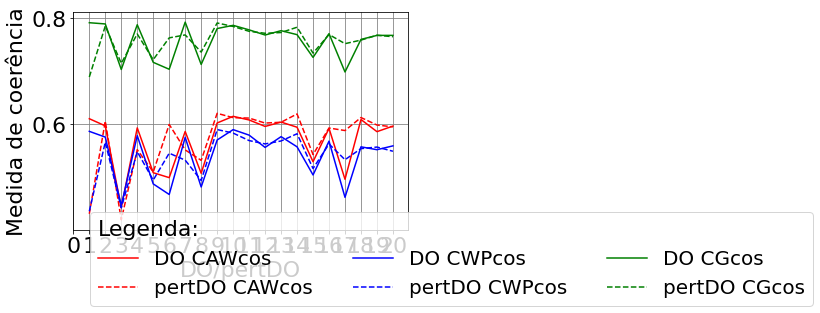

In [ ]:
graficoLinhaMedida('Medida de coerência', 
                   lista_original_CcosCAW, 
                   lista_perturbado_CcosCAW, 
                   lista_original_CcosCWP, 
                   lista_perturbado_CcosCWP, 
                   lista_original_CcosCG, 
                   lista_perturbado_CcosCG,
                   medida = medida)

In [ ]:
print("Diferença entre as equação CAW      :", getSomatorioDiferencaAbsoluta(lista_original_CcosCAW, lista_perturbado_CcosCAW))
print("Diferença entre as equação CWP      :", getSomatorioDiferencaAbsoluta(lista_original_CcosCWP, lista_perturbado_CcosCWP))
print("Diferença entre as equação CG       :", getSomatorioDiferencaAbsoluta(lista_original_CcosCG, lista_perturbado_CcosCG))

Diferença entre as equação CAW      : 0.5923971130525576
Diferença entre as equação CWP      : 0.5180650830583075
Diferença entre as equação CG       : 0.35035855642771374


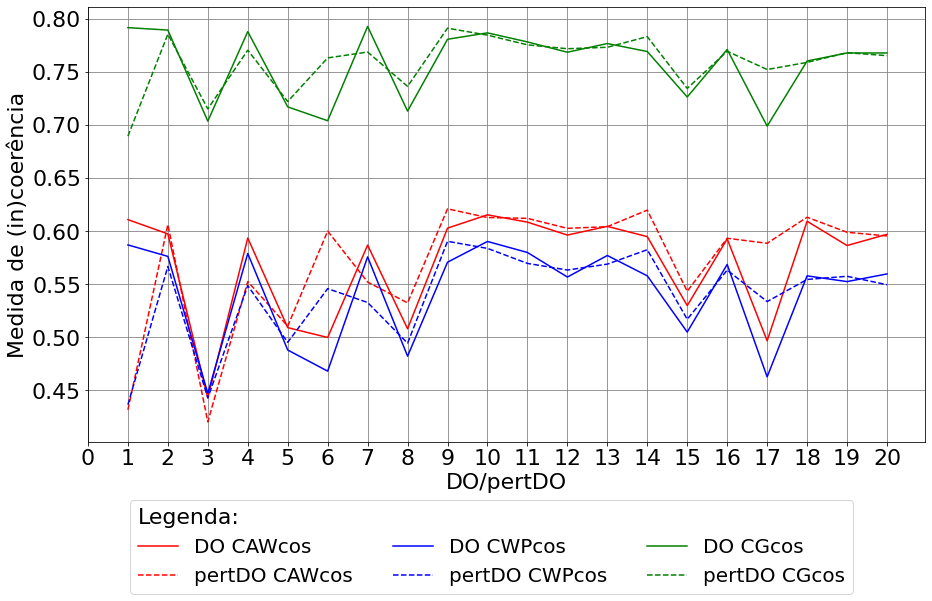

In [ ]:
graficoLinhaMedida('Medida de (in)coerência', 
                   lista_original_CcosCAW[0:200], 
                   lista_perturbado_CcosCAW[0:200], 
                   lista_original_CcosCWP[0:200], 
                   lista_perturbado_CcosCWP[0:200], 
                   lista_original_CcosCG[0:200], 
                   lista_perturbado_CcosCG[0:200],
                   medida = medida)

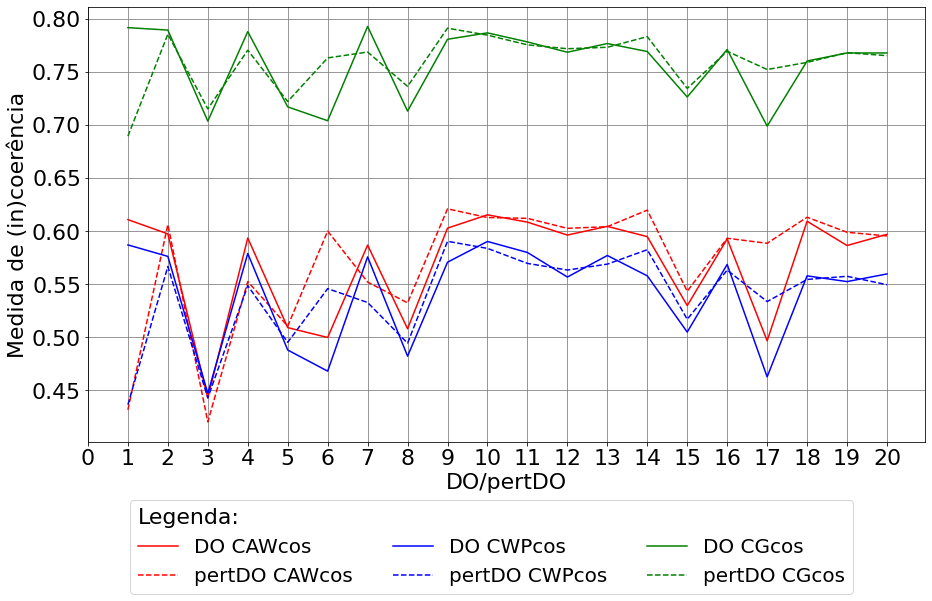

In [ ]:

graficoLinhaMedida('Medida de (in)coerência', 
                   lista_original_CcosCAW[0:100], 
                   lista_perturbado_CcosCAW[0:100], 
                   lista_original_CcosCWP[0:100], 
                   lista_perturbado_CcosCWP[0:100], 
                   lista_original_CcosCG[0:100], 
                   lista_perturbado_CcosCG[0:100],
                  medida = medida)

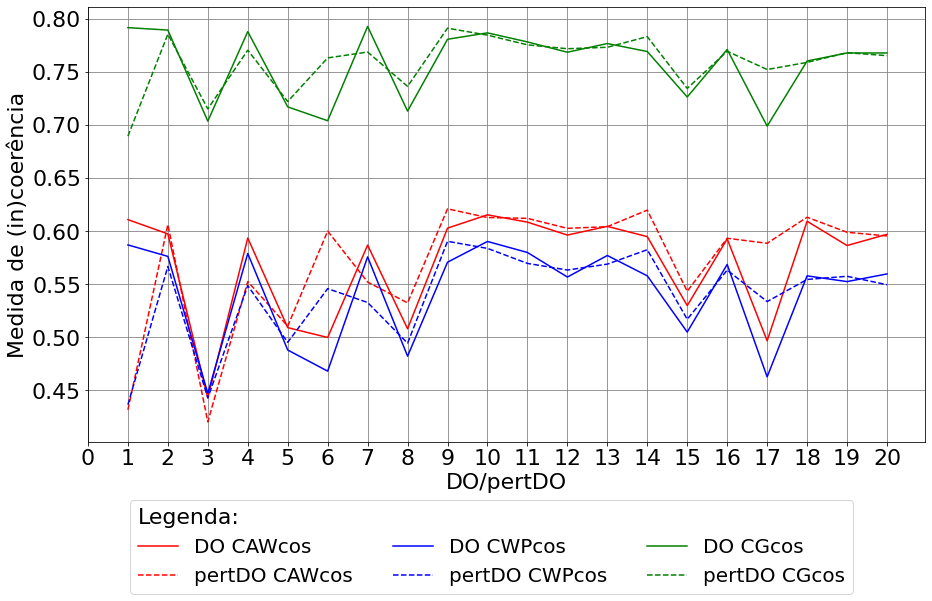

In [ ]:
graficoLinhaMedida('Medida de (in)coerência', 
                   lista_original_CcosCAW[0:20], 
                   lista_perturbado_CcosCAW[0:20], 
                   lista_original_CcosCWP[0:20], 
                   lista_perturbado_CcosCWP[0:20], 
                   lista_original_CcosCG[0:20], 
                   lista_perturbado_CcosCG[0:20],
                   medida = medida)

#### Gráfico de linha da medida de coerência Ccos ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações.

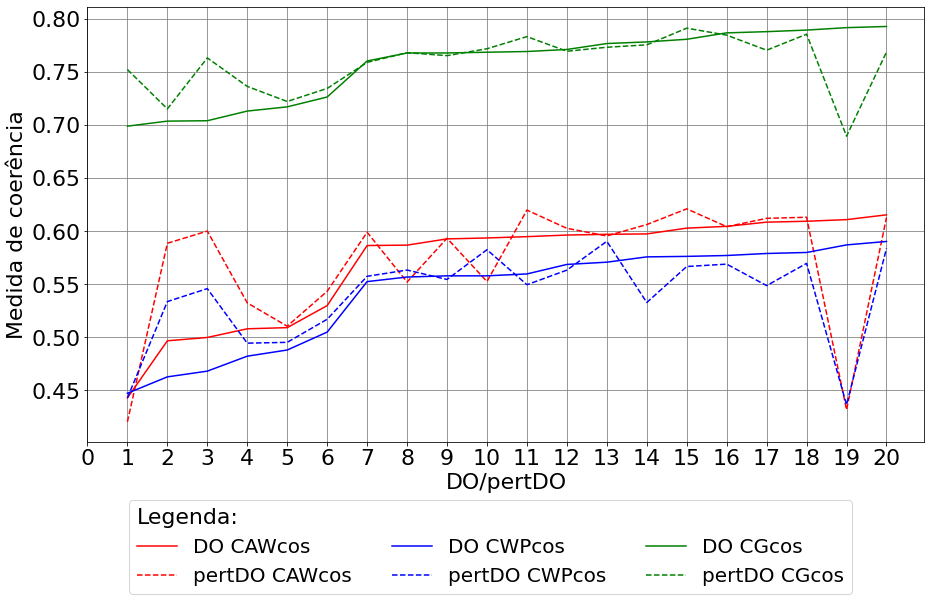

In [ ]:
graficoLinhaMedida('Medida de coerência', 
                   lista_original_ordenado_CcosCAW, 
                   lista_perturbado_ordenado_CcosCAW, 
                   lista_original_ordenado_CcosCWP, 
                   lista_perturbado_ordenado_CcosCWP, 
                   lista_original_ordenado_CcosCG, 
                   lista_perturbado_ordenado_CcosCG,
                   medida = medida)

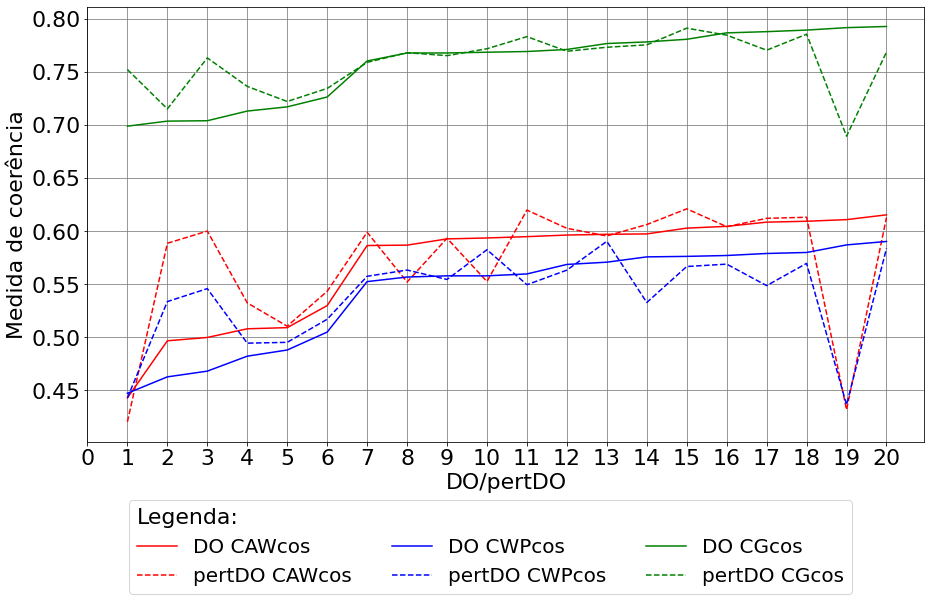

In [ ]:
graficoLinhaMedida('Medida de coerência', 
                   lista_original_ordenado_CcosCAW[0:100], 
                   lista_perturbado_ordenado_CcosCAW[0:100], 
                   lista_original_ordenado_CcosCWP[0:100], 
                   lista_perturbado_ordenado_CcosCWP[0:100], 
                   lista_original_ordenado_CcosCG[0:100], 
                   lista_perturbado_ordenado_CcosCG[0:100],
                  medida = medida)

#### Gráfico de linha da medida de coerência Ccos ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando 1 equação.

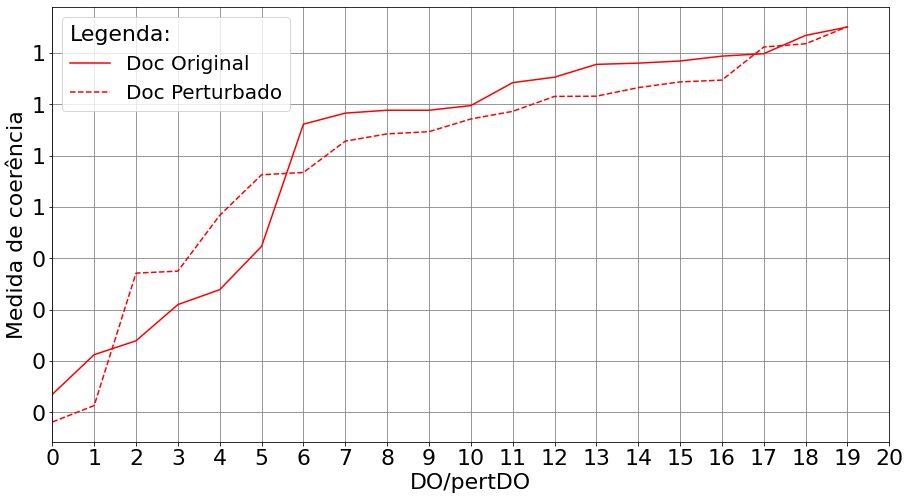

In [ ]:
graficoLinhaMedida2('Medida de coerência', 
                    lista_original_ordenado_CcosCWP, 
                    lista_perturbado_ordenado_CcosCWP,
                    medida = 'cos')

Sem ordem

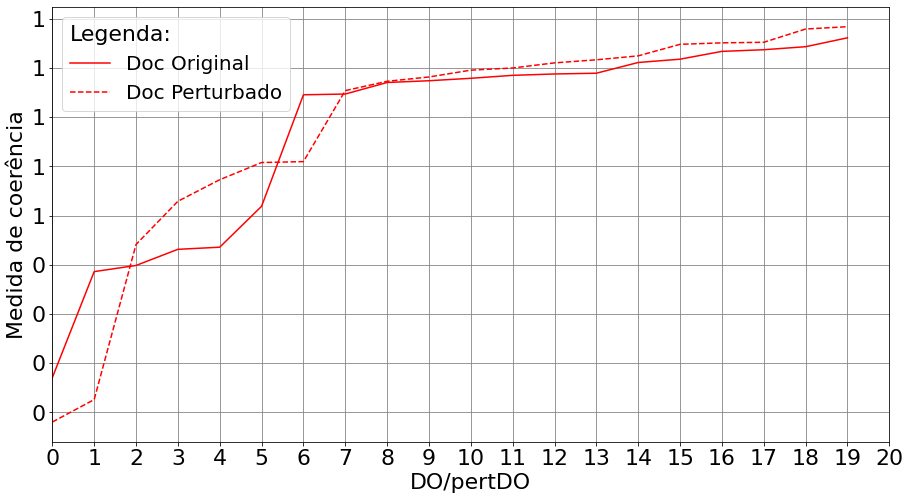

In [ ]:
graficoLinhaMedida2('Medida de coerência', 
                    lista_original_CcosCAW, 
                    lista_perturbado_CcosCAW)

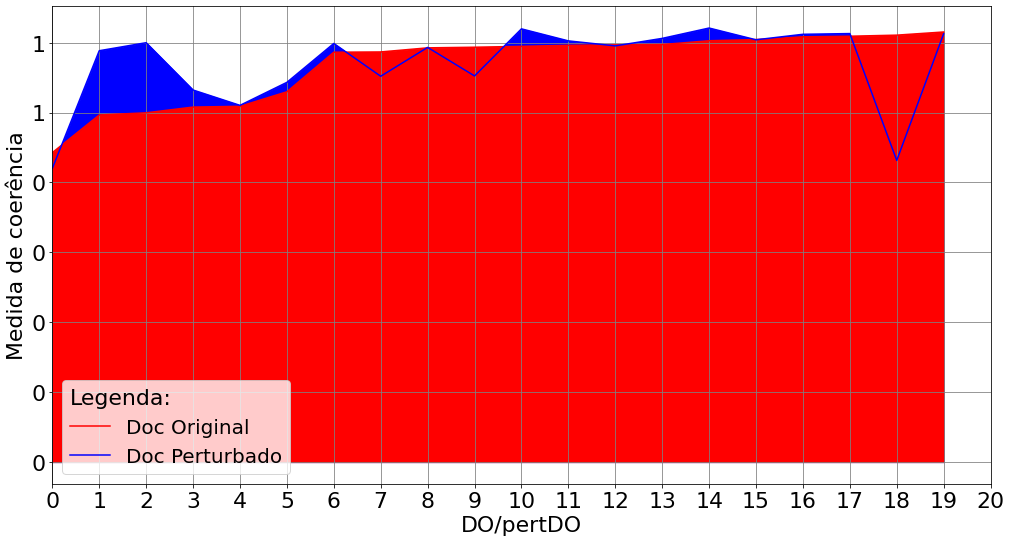

In [ ]:
graficoLinhaMedida2Preenchido('Medida de coerência', 
                              lista_original_ordenado_CcosCAW, 
                              lista_perturbado_ordenado_CcosCAW,
                              medida = 'cos')

### Somatórios das diferenças absolutas de DO com as versões perturbadas

#### Usando CAW






In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CAWcos: 0.5923971130525576

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['13', 0.00032043705383932863, 16, 'What is a queue and how to enqueue an element in it?']
['16', 0.0006124724944432947, 9, 'What is a queue and how to enqueue and dequeue its elements?']
['5', 0.0013812118106417692, 5, 'How to push elements in a stack data structure?']
['20', 0.0015262527899307932, 13, 'In a queue does the enqueue operation occur at which end?']
['10', 0.002550643682479814, 20, 'What is a queue and how to enqueue its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7', 0.0347866543701717, 8, 'How to pop elements from a stack?']
['4', 0.041080670224295734, 10, 'How to push and pop elements in a stack?']
['17', 0.0919319876971153, 2, 'How are the operations to push and pop e

##### Usando CAW onde Cm(pertDO)>Cm(DO) *


In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos: 0.3103493468060003

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['16', 0.0006124724944432947, 9, 'What is a queue and how to enqueue and dequeue its elements?']
['5', 0.0013812118106417692, 5, 'How to push elements in a stack data structure?']
['11', 0.003583654761314392, 17, 'What is a queue and how to dequeue an element in it?']
['18', 0.003780277875753524, 18, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['12', 0.006330522398153904, 12, 'What is a stack and how to pop an element from it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['9', 0.01818536818027494, 15, 'What is a stack and how to push its el

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6
DO: How to push and pop elements in a stack data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
  1 - How to push and pop elements in a queue data structure ? [stack(CAWcos(DO)=0,4996372427) -> queue(>CAWcos(pertDO)=0,5999318659)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV("13",
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 13
DO: What is a queue and how to enqueue an element in it?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB DET NOUN ADP PRON PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
13_pert_0;What is a stack and how to enqueue an element in it ?;queue;NOUN;0,6044052194;0,5769258352;0,7767513532;stack;NOUN;0,6040847823;0,5687723378;0,7732419326;1,0000000000;0;1


##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWcos: 0.2820477662465573

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['13', 0.00032043705383932863, 16, 'What is a queue and how to enqueue an element in it?']
['20', 0.0015262527899307932, 13, 'In a queue does the enqueue operation occur at which end?']
['10', 0.002550643682479814, 20, 'What is a queue and how to enqueue its element?']
['3', 0.02255364746919697, 1, 'How to push elements in a stack?']
['7', 0.0347866543701717, 8, 'How to pop elements from a stack?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['10', 0.002550643682479814, 20, 'What is a queue and how to enqueue its element?']
['3', 0.02255364746919697, 1, 'How to push elements in 

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[0:1][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 13
DO: What is a queue and how to enqueue an element in it?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB DET NOUN ADP PRON PUNCT 
  1 - What is a stack and how to enqueue an element in it ? [queue(>CAWcos(DO)=0,6044052194) -> stack(CAWcos(pertDO)=0,6040847823)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 13
DO: What is a queue and how to enqueue an element in it?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB DET NOUN ADP PRON PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
13_pert_0;What is a stack and how to enqueue an element in it ?;queue;NOUN;0,6044052194;0,5769258352;0,7767513532;stack;NOUN;0,6040847823;0,5687723378;0,7732419326;1,0000000000;0;1


#### Usando CWP

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CWPcos: 0.5180650830583075

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CWPcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['18', 0.0034051671787932447, 9, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['3', 0.004375639803973597, 1, 'How to push elements in a stack?']
['19', 0.004997772249308419, 7, 'In a stack does the pop operation occur at which end?']
['16', 0.005364306462116719, 12, 'What is a queue and how to enqueue and dequeue its elements?']
['10', 0.006524978984485896, 20, 'What is a queue and how to enqueue its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['4', 0.03029677867889402, 17, 'How to push and pop elements in a stack?']
['7', 0.04301915424210678, 14, 'How to pop elements from a stack?']
['17', 0.07098666529406555, 2, 'How are the operations to push an

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos: 0.23628435303636014

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['19', 0.004997772249308419, 7, 'In a stack does the pop operation occur at which end?']
['12', 0.006600057467436193, 8, 'What is a stack and how to pop an element from it?']
['5', 0.007233072651757211, 5, 'How to push elements in a stack data structure?']
['15', 0.012090698457681182, 6, 'What is a stack and how to push and pop its elements?']
['8', 0.012257675867941631, 4, 'How to pop elements in a stack data structure?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['8', 0.012257675867941631, 4, 'How to pop elements in a stack data structure?']
['9', 0.019677489454095975, 1

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6
DO: How to push and pop elements in a stack data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
  1 - How to push and pop elements in a queue data structure ? [stack(CWPcos(DO)=0,4678994790) -> queue(>CWPcos(pertDO)=0,5456987908)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6
DO: How to push and pop elements in a stack data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
6_pert_0;How to push and pop elements in a queue data structure ?;stack;NOUN;0,4996372427;0,4678994790;0,7039769186;queue;NOUN;0,5999318659;0,5456987908;0,7631944468;1,0000000000;0;1


##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPcos: 0.2817807300219473

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['18', 0.0034051671787932447, 9, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['3', 0.004375639803973597, 1, 'How to push elements in a stack?']
['16', 0.005364306462116719, 12, 'What is a queue and how to enqueue and dequeue its elements?']
['10', 0.006524978984485896, 20, 'What is a queue and how to enqueue its element?']
['13', 0.008153497408597832, 16, 'What is a queue and how to enqueue an element in it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['20', 0.010152646989533332, 11, 'In a queue does the enqueue operation occur at which

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[0:1][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 18
DO: How are the operations to enqueue and dequeue elements in a queue implemented?
     SCONJ AUX DET NOUN PART VERB CCONJ NOUN NOUN ADP DET NOUN VERB PUNCT 
  1 - How are the operations to enqueue and dequeue elements in a stack implemented ? [queue(>CWPcos(DO)=0,5577384997) -> stack(CWPcos(pertDO)=0,5543333325)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 18
DO: How are the operations to enqueue and dequeue elements in a queue implemented?
     SCONJ AUX DET NOUN PART VERB CCONJ NOUN NOUN ADP DET NOUN VERB PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
18_pert_0;How are the operations to enqueue and dequeue elements in a stack implemented ?;queue;NOUN;0,6092032974;0,5577384997;0,7602920277;stack;NOUN;0,6129835752;0,5543333325;0,7589834205;1,0000000000;0;1


#### Usando CG

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CGcos: 0.35035855642771374

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CGcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['19', 0.0002807825803756714, 8, 'In a stack does the pop operation occur at which end?']
['18', 0.0013086072036198049, 7, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['16', 0.0016830288446866293, 12, 'What is a queue and how to enqueue and dequeue its elements?']
['10', 0.0021379319104281036, 16, 'What is a queue and how to enqueue its element?']
['20', 0.0025372207164764404, 9, 'In a queue does the enqueue operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['8', 0.02326083369553089, 4, 'How to pop elements in a stack data structure?']
['7', 0.024096958339214325, 20, 'How to pop elements from a stack?']
['17', 0.05337672999926968, 1,

###### Usando CG onde Cm(pertDO)>Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos: 0.1886356338853331

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['19', 0.0002807825803756714, 8, 'In a stack does the pop operation occur at which end?']
['12', 0.0033034453025231336, 10, 'What is a stack and how to pop an element from it?']
['5', 0.005056704580783777, 5, 'How to push elements in a stack data structure?']
['15', 0.008090755114188553, 6, 'What is a stack and how to push and pop its elements?']
['9', 0.010478176853873533, 15, 'What is a stack and how to push its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['3', 0.01154794218018651, 2, 'How to push elements in a stack?']
['14', 0.014022735448983914, 11, 'What is a s

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6
DO: How to push and pop elements in a stack data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
  1 - How to push and pop elements in a queue data structure ? [stack(CGcos(DO)=0,7039769186) -> queue(>CGcos(pertDO)=0,7631944468)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6
DO: How to push and pop elements in a stack data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
6_pert_0;How to push and pop elements in a queue data structure ?;stack;NOUN;0,4996372427;0,4678994790;0,7039769186;queue;NOUN;0,5999318659;0,5456987908;0,7631944468;1,0000000000;0;1


###### Usando CG onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGcos: 0.16172292254238063

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['18', 0.0013086072036198049, 7, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['16', 0.0016830288446866293, 12, 'What is a queue and how to enqueue and dequeue its elements?']
['10', 0.0021379319104281036, 16, 'What is a queue and how to enqueue its element?']
['20', 0.0025372207164764404, 9, 'In a queue does the enqueue operation occur at which end?']
['11', 0.002766109429872987, 14, 'What is a queue and how to dequeue an element in it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['13', 0.0035094206149760554, 13, 'What is a queue and how

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[0:1][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 18
DO: How are the operations to enqueue and dequeue elements in a queue implemented?
     SCONJ AUX DET NOUN PART VERB CCONJ NOUN NOUN ADP DET NOUN VERB PUNCT 
  1 - How are the operations to enqueue and dequeue elements in a stack implemented ? [queue(>CGcos(DO)=0,7602920277) -> stack(CGcos(pertDO)=0,7589834205)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 18
DO: How are the operations to enqueue and dequeue elements in a queue implemented?
     SCONJ AUX DET NOUN PART VERB CCONJ NOUN NOUN ADP DET NOUN VERB PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
18_pert_0;How are the operations to enqueue and dequeue elements in a stack implemented ?;queue;NOUN;0,6092032974;0,5577384997;0,7602920277;stack;NOUN;0,6129835752;0,5543333325;0,7589834205;1,0000000000;0;1


### Amplitudes medidas de DO com as versões perturbadas

#### Usando CAW






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CAWcos: 0.16172292254238063

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['13', 0.00032043705383932863, 16, 'What is a queue and how to enqueue an element in it?']
['16', 0.0006124724944432947, 9, 'What is a queue and how to enqueue and dequeue its elements?']
['5', 0.0013812118106417692, 5, 'How to push elements in a stack data structure?']
['20', 0.0015262527899307932, 13, 'In a queue does the enqueue operation occur at which end?']
['10', 0.002550643682479814, 20, 'What is a queue and how to enqueue its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7', 0.0347866543701717, 8, 'How to pop elements from a stack?']
['4', 0.041080670224295734, 10, 'How to push and pop elements in a stack?']
['17', 0.09193198

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos: 0.16172292254238063

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['16', 0.0006124724944432947, 9, 'What is a queue and how to enqueue and dequeue its elements?']
['5', 0.0013812118106417692, 5, 'How to push elements in a stack data structure?']
['11', 0.003583654761314392, 17, 'What is a queue and how to dequeue an element in it?']
['18', 0.003780277875753524, 18, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['12', 0.006330522398153904, 12, 'What is a stack and how to pop an element from it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['9', 0.01818536818027494, 15, 'What is a stack and how to push its element?']


Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6
DO: How to push and pop elements in a stack data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
  1 - How to push and pop elements in a queue data structure ? [stack(CAWcos(DO)=0,4996372427) -> queue(>CAWcos(pertDO)=0,5999318659)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6
DO: How to push and pop elements in a stack data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
6_pert_0;How to push and pop elements in a queue data structure ?;stack;NOUN;0,4996372427;0,4678994790;0,7039769186;queue;NOUN;0,5999318659;0,5456987908;0,7631944468;1,0000000000;0;1


##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWcos: 0.16172292254238063

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['13', 0.00032043705383932863, 16, 'What is a queue and how to enqueue an element in it?']
['20', 0.0015262527899307932, 13, 'In a queue does the enqueue operation occur at which end?']
['10', 0.002550643682479814, 20, 'What is a queue and how to enqueue its element?']
['3', 0.02255364746919697, 1, 'How to push elements in a stack?']
['7', 0.0347866543701717, 8, 'How to pop elements from a stack?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['10', 0.002550643682479814, 20, 'What is a queue and how to enqueue its element?']
['3', 0.02255364746919697, 1, 'How to push elements in a stack?'

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to enqueue elements in a stack ?' [queue(>CAWcos(DO)=0,6107416238) -> stack(CAWcos(pertDO)=0,4315121632)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
1_pert_0;How to enqueue elements in a stack ?';queue;NOUN;0,6107416238;0,5869072612;0,7917402983;stack;NOUN;0,4315121632;0,4362495516;0,6894199052;1,0000000000;0;1


#### Usando CWP






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CWPcos: 0.16172292254238063

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['18', 0.0034051671787932447, 9, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['3', 0.004375639803973597, 1, 'How to push elements in a stack?']
['19', 0.004997772249308419, 7, 'In a stack does the pop operation occur at which end?']
['16', 0.005364306462116719, 12, 'What is a queue and how to enqueue and dequeue its elements?']
['10', 0.006524978984485896, 20, 'What is a queue and how to enqueue its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['4', 0.03029677867889402, 17, 'How to push and pop elements in a stack?']
['7', 0.04301915424210678, 14, 'How to pop elements from a stack?']
['17', 0.07098

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos: 0.16172292254238063

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['19', 0.004997772249308419, 7, 'In a stack does the pop operation occur at which end?']
['12', 0.006600057467436193, 8, 'What is a stack and how to pop an element from it?']
['5', 0.007233072651757211, 5, 'How to push elements in a stack data structure?']
['15', 0.012090698457681182, 6, 'What is a stack and how to push and pop its elements?']
['8', 0.012257675867941631, 4, 'How to pop elements in a stack data structure?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['8', 0.012257675867941631, 4, 'How to pop elements in a stack data structure?']
['9', 0.019677489454095975, 13, 'What is a

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6
DO: How to push and pop elements in a stack data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
  1 - How to push and pop elements in a queue data structure ? [stack(CAWcos(DO)=0,4996372427) -> queue(>CAWcos(pertDO)=0,5999318659)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6
DO: How to push and pop elements in a stack data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
6_pert_0;How to push and pop elements in a queue data structure ?;stack;NOUN;0,4996372427;0,4678994790;0,7039769186;queue;NOUN;0,5999318659;0,5456987908;0,7631944468;1,0000000000;0;1


##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPcos: 0.16172292254238063

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['18', 0.0034051671787932447, 9, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['3', 0.004375639803973597, 1, 'How to push elements in a stack?']
['16', 0.005364306462116719, 12, 'What is a queue and how to enqueue and dequeue its elements?']
['10', 0.006524978984485896, 20, 'What is a queue and how to enqueue its element?']
['13', 0.008153497408597832, 16, 'What is a queue and how to enqueue an element in it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['20', 0.010152646989533332, 11, 'In a queue does the enqueue operation occur at which end?']
['11

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to enqueue elements in a stack ?' [queue(>CAWcos(DO)=0,6107416238) -> stack(CAWcos(pertDO)=0,4315121632)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
1_pert_0;How to enqueue elements in a stack ?';queue;NOUN;0,6107416238;0,5869072612;0,7917402983;stack;NOUN;0,4315121632;0,4362495516;0,6894199052;1,0000000000;0;1


#### Usando CG






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CGcos: 0.16172292254238063

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['19', 0.0002807825803756714, 8, 'In a stack does the pop operation occur at which end?']
['18', 0.0013086072036198049, 7, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['16', 0.0016830288446866293, 12, 'What is a queue and how to enqueue and dequeue its elements?']
['10', 0.0021379319104281036, 16, 'What is a queue and how to enqueue its element?']
['20', 0.0025372207164764404, 9, 'In a queue does the enqueue operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['8', 0.02326083369553089, 4, 'How to pop elements in a stack data structure?']
['7', 0.024096958339214325, 20, 'How to pop eleme

##### Usando CG onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos: 0.16172292254238063

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['19', 0.0002807825803756714, 8, 'In a stack does the pop operation occur at which end?']
['12', 0.0033034453025231336, 10, 'What is a stack and how to pop an element from it?']
['5', 0.005056704580783777, 5, 'How to push elements in a stack data structure?']
['15', 0.008090755114188553, 6, 'What is a stack and how to push and pop its elements?']
['9', 0.010478176853873533, 15, 'What is a stack and how to push its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['3', 0.01154794218018651, 2, 'How to push elements in a stack?']
['14', 0.014022735448983914, 11, 'What is a stack and how

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6
DO: How to push and pop elements in a stack data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
  1 - How to push and pop elements in a queue data structure ? [stack(CAWcos(DO)=0,4996372427) -> queue(>CAWcos(pertDO)=0,5999318659)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6
DO: How to push and pop elements in a stack data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
6_pert_0;How to push and pop elements in a queue data structure ?;stack;NOUN;0,4996372427;0,4678994790;0,7039769186;queue;NOUN;0,5999318659;0,5456987908;0,7631944468;1,0000000000;0;1


##### Usando CG onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGcos: 0.16172292254238063

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['18', 0.0013086072036198049, 7, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['16', 0.0016830288446866293, 12, 'What is a queue and how to enqueue and dequeue its elements?']
['10', 0.0021379319104281036, 16, 'What is a queue and how to enqueue its element?']
['20', 0.0025372207164764404, 9, 'In a queue does the enqueue operation occur at which end?']
['11', 0.002766109429872987, 14, 'What is a queue and how to dequeue an element in it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['13', 0.0035094206149760554, 13, 'What is a queue and how to enqueue a

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to enqueue elements in a stack ?' [queue(>CAWcos(DO)=0,6107416238) -> stack(CAWcos(pertDO)=0,4315121632)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
1_pert_0;How to enqueue elements in a stack ?';queue;NOUN;0,6107416238;0,5869072612;0,7917402983;stack;NOUN;0,4315121632;0,4362495516;0,6894199052;1,0000000000;0;1


## 3.6  Avaliando o cálculo da incoerência com todas as equações e com a medida de distância euclidiana(euc)






In [ ]:
medida = 'euc'

### Estatística

#### CAW

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCAW, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 9 de 20
Percentual de documentos coerentes em relação ao total: 45.0
Acertos Perturbado : 11 de 20
Percentual de documentos incoerentes em relação ao total: 55.00000000000001


#### CWP

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCWP,medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 9 de 20
Percentual de documentos coerentes em relação ao total: 45.0
Acertos Perturbado : 11 de 20
Percentual de documentos incoerentes em relação ao total: 55.00000000000001


#### CG

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCG,medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 9 de 20
Percentual de documentos coerentes em relação ao total: 45.0
Acertos Perturbado : 11 de 20
Percentual de documentos incoerentes em relação ao total: 55.00000000000001


### Documentos perturbados com as piores medidas CAW sem repetição

Documento perturbado sem repetição com a menor medida para um documento original.

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

print("Processando",len(lista_documentos_originais),"documentos originais")

# Barra de progresso dos documentos
lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

lista_documentos = []
lista_verificao_documentos = []

# Percorre os documentos originais
for i, linha_documento in lista_documentos_originais_bar: 
  #if i < 2:
  #print("linha_documento:",linha_documento)
  # Recupera o id do documento
  id_documento = linha_documento[0]     
  #print("id_documento:",id_documento)     

  # Recupera as medidas dos perturbados para o documento original
  mensuracoes = df_lista_pares_documentos_mensuracaoCAW.loc[df_lista_pares_documentos_mensuracaoCAW['id_DO'] == id_documento]

  # Ordena descrentemente a medida
  mensuracoes = mensuracoes.sort_values(by=['c' + medida + '_pertDO'], ascending=False)

  # Localiza o documento com a maior medida(euc) sem repetição
  adicionado = False
  indiceMenor = 0
  # Enquanto não tiver adicionado
  while adicionado == False:
    # localiza o documento perturbado que possui a menor medida ceuc
    dfmenor = mensuracoes.iloc[indiceMenor]
    id_documento_perturbado = dfmenor['id_pertDO']
    # print("menor:",dfmenor['id_pertDO'])
    # Recupera o registro documento
    dfdocumento_perturbado = lista_documentos_perturbados_indexado.loc[id_documento_perturbado]
    # Recupera o documento
    documento = dfdocumento_perturbado['documento_perturbado']        
    # Verifica se está na lista
    if documento not in lista_verificao_documentos:
       lista_verificao_documentos.append(documento)
       lista_documentos.append([id_documento, id_documento_perturbado, documento])
       adicionado = True
    else:
      indiceMenor = indiceMenor + 1

Processando 20 documentos originais


Documentos:   0%|          | 0/20 [00:00<?, ? documento/s]

In [ ]:
for i, documento in enumerate(lista_documentos):
    # print(documento[0] + ";" + documento[1] + ";" + documento[2])
    print(documento[0] + ";" + documento[2])

1;How to enqueue elements in a stack ?'
2;How to dequeue elements in a stack ?'
3;How to push elements in a queue ?
4;How to push and pop elements in a queue ?
5;How to push elements in a queue data structure?
6;How to push and pop elements in a queue data structure ?
7;How to pop elements from a queue ?
8;How to pop elements in a queue data structure ?
9;What is a queue and how to push its element ?
10;What is a stack and how to enqueue its element ?
11;What is a stack and how to dequeue an element in it ?
12;What is a queue and how to pop an element from it ?
13;What is a stack and how to enqueue an element in it ?
14;What is a queue and how to push an element on it ?
15;What is a queue and how to push and pop its elements ?
16;What is a stack and how to enqueue and dequeue its elements ?
17;How are the operations to push and pop elements in a queue implemented ?
18;How are the operations to enqueue and dequeue elements in a stack implemented ?
19;In a stack does the enqueue operatio

### Gráficos

#### Gráfico de linha das medida de coerência Ceuc dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações.





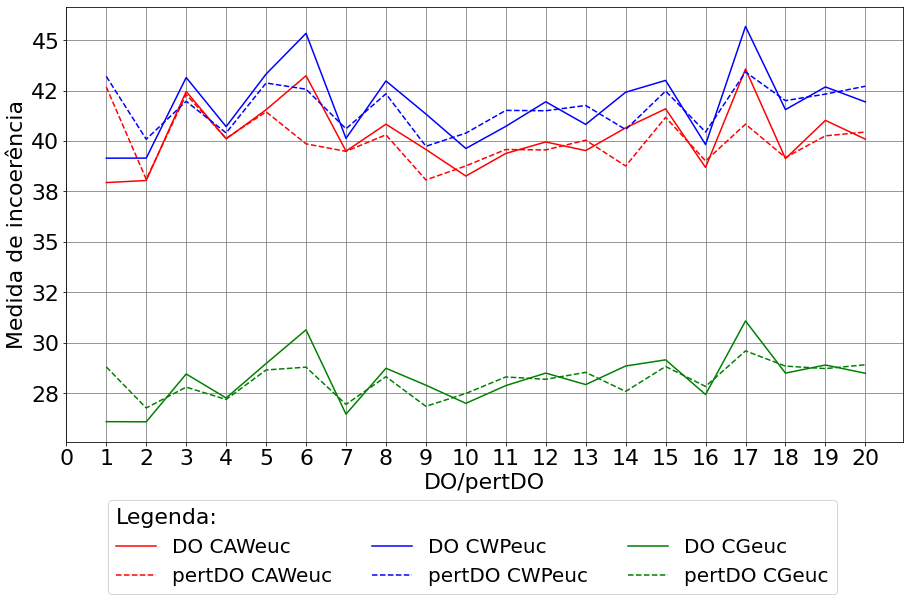

In [ ]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_CeucCAW, 
                   lista_perturbado_CeucCAW, 
                   lista_original_CeucCWP, 
                   lista_perturbado_CeucCWP, 
                   lista_original_CeucCG, 
                   lista_perturbado_CeucCG,
                   medida = medida)

In [ ]:
print("Diferença absoluta entre as medidas equação CAW :", getSomatorioDiferencaAbsoluta(lista_original_CeucCAW, lista_perturbado_CeucCAW))
print("Diferença absoluta entre as medidas equação CWP :", getSomatorioDiferencaAbsoluta(lista_original_CeucCWP, lista_perturbado_CeucCWP))
print("Diferença absoluta entre as medidas equação CG  :", getSomatorioDiferencaAbsoluta(lista_original_CeucCG, lista_perturbado_CeucCG))

Diferença absoluta entre as medidas equação CAW : 18.6484317648489
Diferença absoluta entre as medidas equação CWP : 22.160944578223933
Diferença absoluta entre as medidas equação CG  : 14.491348878455241


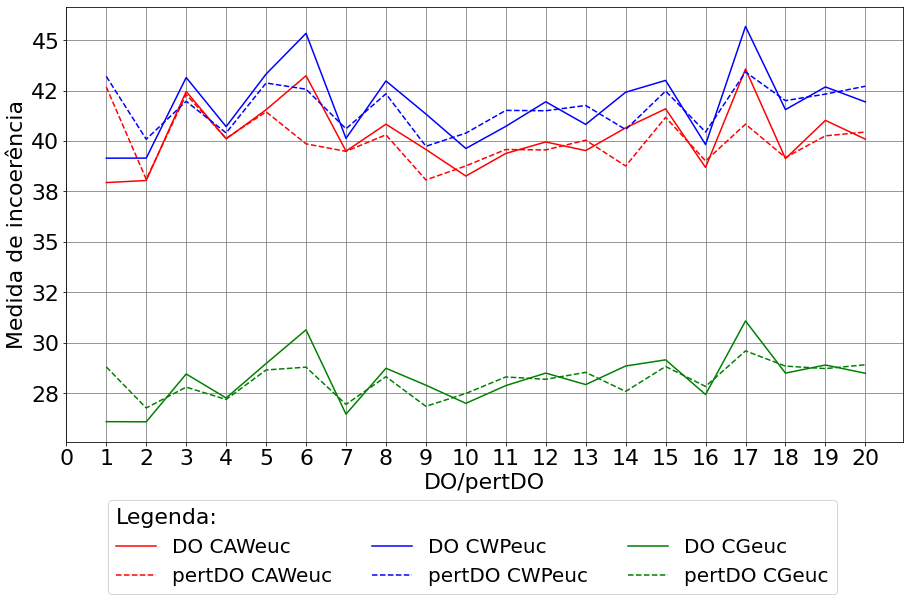

In [ ]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_CeucCAW[0:200], 
                   lista_perturbado_CeucCAW[0:200], 
                   lista_original_CeucCWP[0:200], 
                   lista_perturbado_CeucCWP[0:200], 
                   lista_original_CeucCG[0:200], 
                   lista_perturbado_CeucCG[0:200],
                   medida = medida)

#### Gráfico de linha da medida de coerência Ceuc ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando 1 equação.

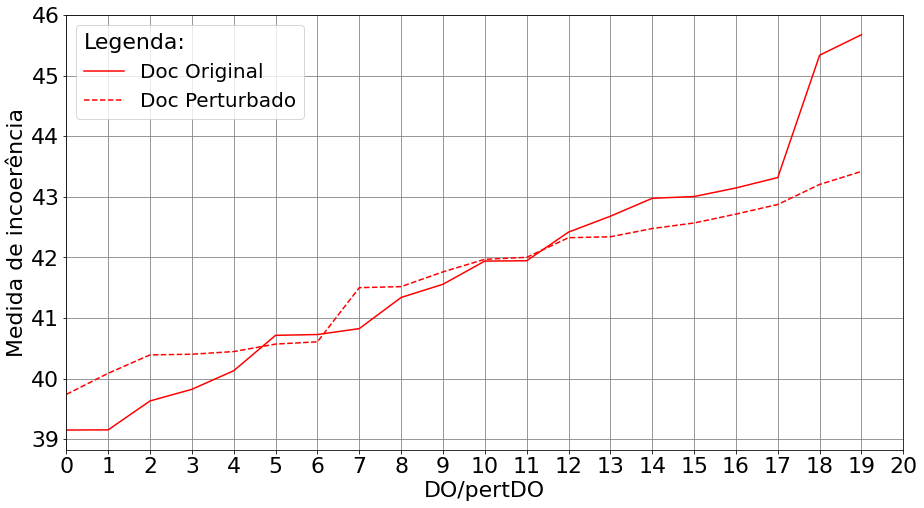

In [ ]:
graficoLinhaMedida2('Medida de incoerência', 
                    lista_original_CeucCWP, 
                    lista_perturbado_CeucCWP,
                    'r',
                    medida = medida)

Sem ordem

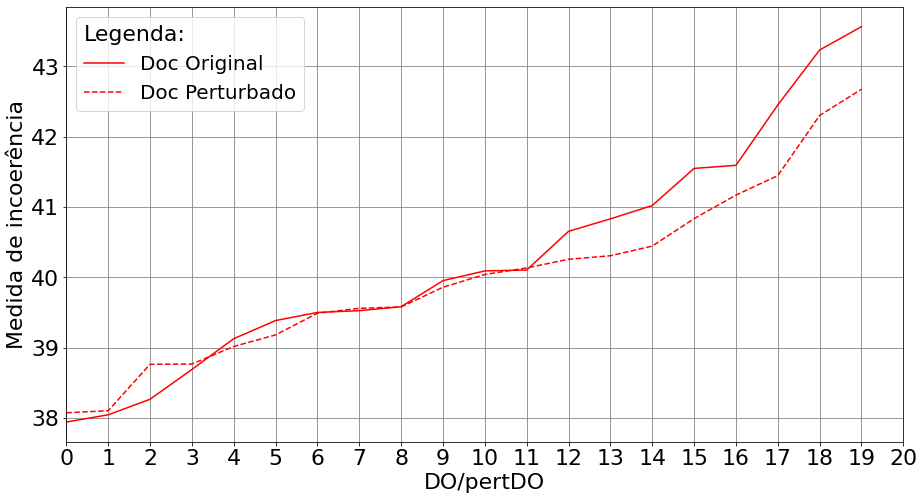

In [ ]:
graficoLinhaMedida2('Medida de incoerência', 
                    lista_original_CeucCAW, 
                    lista_perturbado_CeucCAW,
                    'r',
                    medida = 'euc')

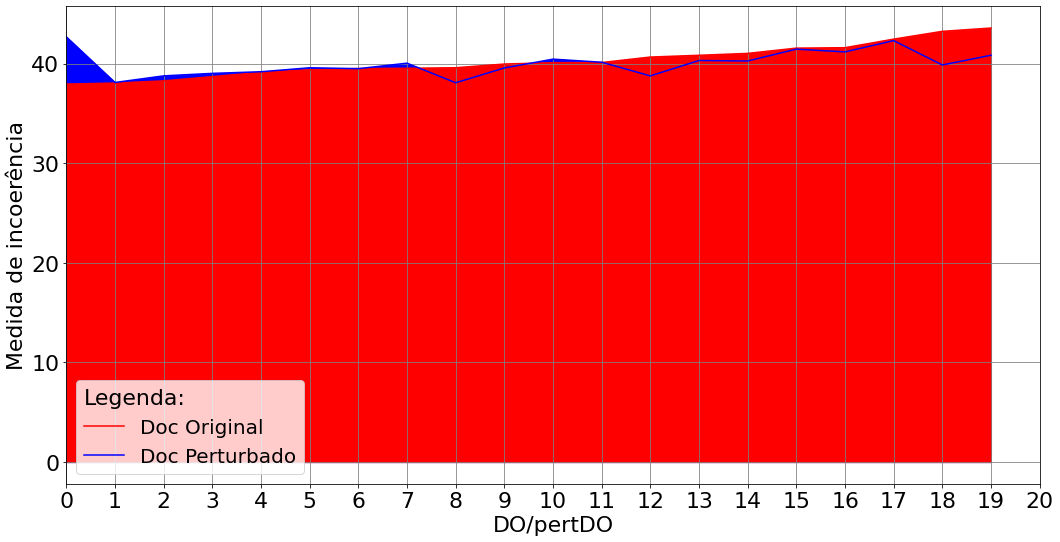

In [ ]:
graficoLinhaMedida2Preenchido('Medida de incoerência', 
                              lista_original_ordenado_CeucCAW, 
                              lista_perturbado_ordenado_CeucCAW,
                              medida = 'euc')

#### Gráfico de linha da medida de coerência Ceuc ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações.

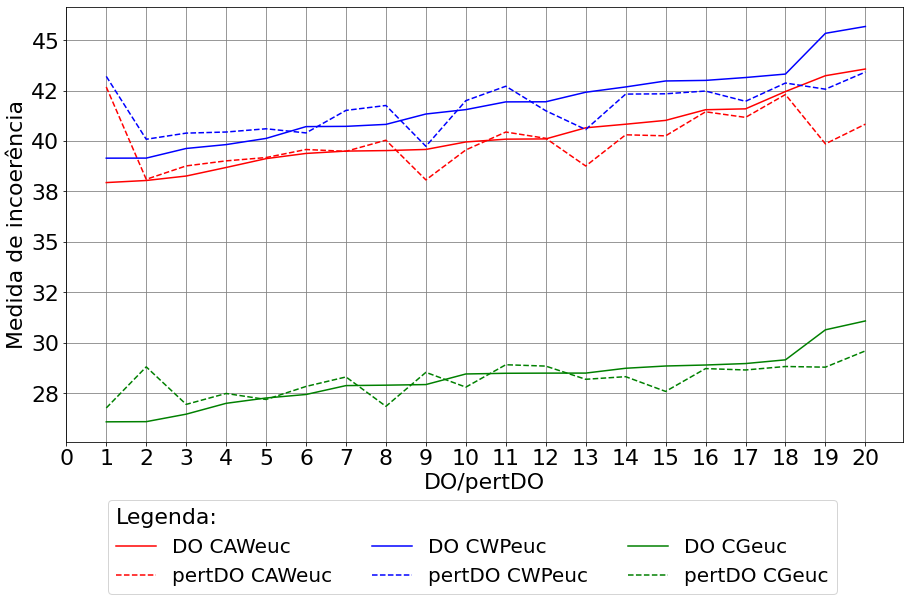

In [ ]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_ordenado_CeucCAW, 
                   lista_perturbado_ordenado_CeucCAW, 
                   lista_original_ordenado_CeucCWP, 
                   lista_perturbado_ordenado_CeucCWP, 
                   lista_original_ordenado_CeucCG, 
                   lista_perturbado_ordenado_CeucCG,
                   medida = medida)

In [ ]:
print("Diferença absoluta entre as medidas equação CAW :", getSomatorioDiferencaAbsoluta(lista_original_CeucCAW, lista_perturbado_CeucCAW))
print("Diferença absoluta entre as medidas equação CWP :", getSomatorioDiferencaAbsoluta(lista_original_CeucCWP, lista_perturbado_CeucCWP))
print("Diferença absoluta entre as medidas equação CG  :", getSomatorioDiferencaAbsoluta(lista_original_CeucCG, lista_perturbado_CeucCG))

Diferença absoluta entre as medidas equação CAW : 18.6484317648489
Diferença absoluta entre as medidas equação CWP : 22.160944578223933
Diferença absoluta entre as medidas equação CG  : 14.491348878455241


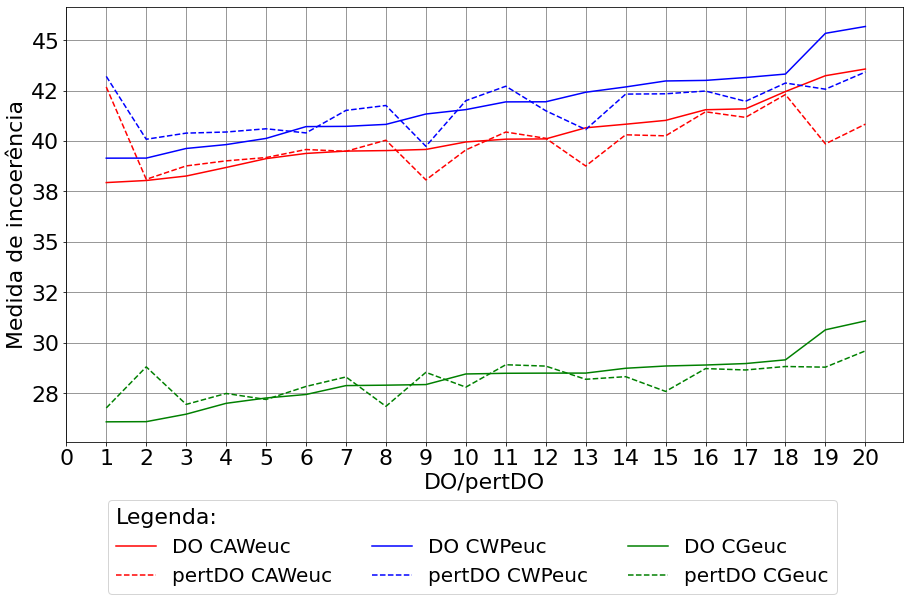

In [ ]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_ordenado_CeucCAW[0:100], 
                   lista_perturbado_ordenado_CeucCAW[0:100], 
                   lista_original_ordenado_CeucCWP[0:100], 
                   lista_perturbado_ordenado_CeucCWP[0:100], 
                   lista_original_ordenado_CeucCG[0:100], 
                   lista_perturbado_ordenado_CeucCG[0:100],
                   medida = medida)

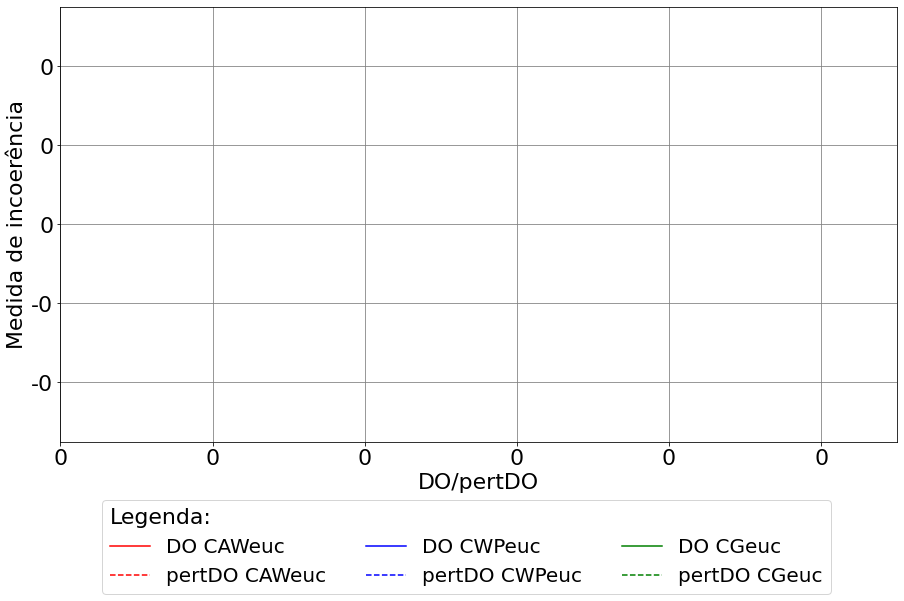

In [ ]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_ordenado_CeucCAW[300:400], 
                   lista_perturbado_ordenado_CeucCAW[300:400], 
                   lista_original_ordenado_CeucCWP[300:400], 
                   lista_perturbado_ordenado_CeucCWP[300:400], 
                   lista_original_ordenado_CeucCG[300:400], 
                   lista_perturbado_ordenado_CeucCG[300:400],
                   medida = medida)

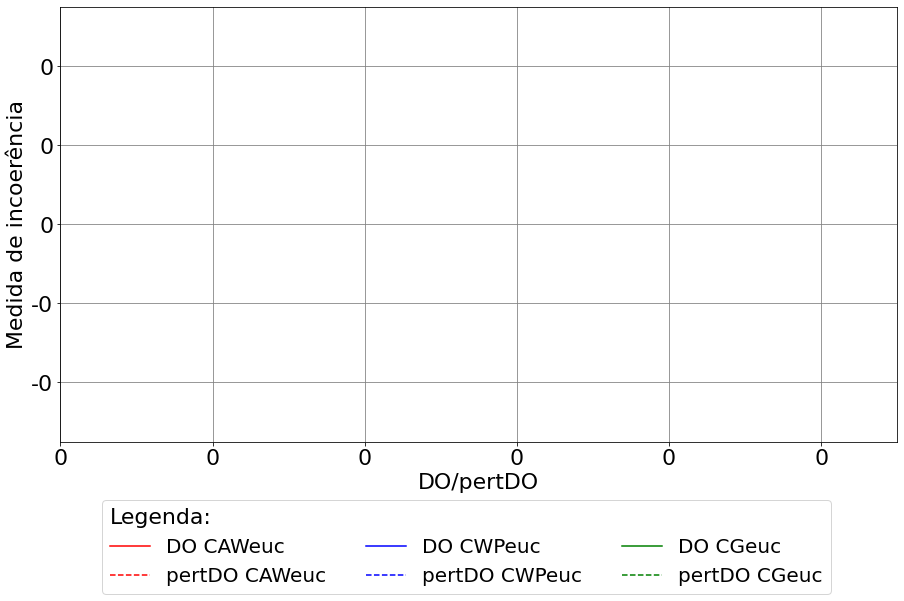

In [ ]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_ordenado_CeucCAW[260:360], 
                   lista_perturbado_ordenado_CeucCAW[260:360], 
                   lista_original_ordenado_CeucCWP[260:360], 
                   lista_perturbado_ordenado_CeucCWP[260:360], 
                   lista_original_ordenado_CeucCG[260:360], 
                   lista_perturbado_ordenado_CeucCG[260:360],
                   medida = medida)

# DO central do gráfico com a maior diferença
# idDO = 16 
# difabs= 34.21611531575515, 
# O que é uma fila e como enfileirar e desenfileirar seus elementos?
# Posição gráfico 16 * 20 = 320

### Somatórios das diferenças absolutas de DO com as versões perturbadas

#### Usando CAW






In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CAWeuc: 18.6484317648489

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['7', 0.011322566441130277, 7, 'How to pop elements from a stack?']
['4', 0.02962536282009154, 12, 'How to push and pop elements in a stack?']
['18', 0.053889054518478474, 5, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['2', 0.05796432495117898, 2, 'How to dequeue elements in a queue?']
['5', 0.10244856940375513, 16, 'How to push elements in a stack data structure?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['9', 1.509500122070314, 9, 'What is a stack and how to push its element?']
['14', 1.892221450805664, 13, 'What is a stack and how to push an element on it?']
['17', 2.7318153381347656, 20, 'How are the operations to push and pop elements in a stack impleme

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc: 6.768062752806173

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['4', 0.02962536282009154, 12, 'How to push and pop elements in a stack?']
['18', 0.053889054518478474, 5, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['2', 0.05796432495117898, 2, 'How to dequeue elements in a queue?']
['11', 0.1942036946614607, 6, 'What is a queue and how to dequeue an element in it?']
['16', 0.32753578821817797, 4, 'What is a queue and how to enqueue and dequeue its elements?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['16', 0.32753578821817797, 4, 'What is a queue and how to enqueue and dequeue its elements?']
['20', 0

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to enqueue elements in a stack ?' [queue(>CAWeuc(DO)=37,9403517587) -> stack(CAWeuc(pertDO)=42,6763807024)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
1_pert_0;How to enqueue elements in a stack ?';queue;NOUN;37,9403517587;39,1498506410;26,0954606533;stack;NOUN;42,6763807024;43,2022290911;28,8095269203;1,0000000000;0;1


##### Usando CAW onde Cm(pertDO)<Cm(DO) *

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWeuc: 11.880369012042728

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['7', 0.011322566441130277, 7, 'How to pop elements from a stack?']
['5', 0.10244856940375513, 16, 'How to push elements in a stack data structure?']
['3', 0.14900725228446277, 18, 'How to push elements in a stack?']
['12', 0.3943874041239539, 10, 'What is a stack and how to pop an element from it?']
['15', 0.4236062367757185, 17, 'What is a stack and how to push and pop its elements?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['19', 0.7650604248046804, 15, 'In a stack does the pop operation occur at which end?']
['9', 1.509500122070314, 9, 'What is a stack and how to push it

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
# id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6
DO: How to push and pop elements in a stack data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
  1 - How to push and pop elements in a queue data structure ? [stack(CAWeuc(DO)=43,2347236980) -> queue(>CAWeuc(pertDO)=39,8584273945)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6
DO: How to push and pop elements in a stack data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
6_pert_0;How to push and pop elements in a queue data structure ?;stack;NOUN;43,2347236980;45,3350539063;30,6457392375;queue;NOUN;39,8584273945;42,5666810816;28,7952853839;1,0000000000;0;1


#### Usando CWP

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CWPeuc: 22.160944578223933

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CWPeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['4', 0.31209203932020557, 6, 'How to push and pop elements in a stack?']
['19', 0.35450357379336594, 14, 'In a stack does the pop operation occur at which end?']
['5', 0.4442494710286482, 18, 'How to push elements in a stack data structure?']
['18', 0.44430634215638065, 10, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['12', 0.4443148588522945, 12, 'What is a stack and how to pop an element from it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['9', 1.599408167058769, 9, 'What is a stack and how to push its element?']
['14', 1.8477968313755184, 13, 'What is a stack and how to push an element on it?']
['17', 2.2565385168725314, 20, 'How are the operations to

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc: 9.793148423670296

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['18', 0.44430634215638065, 10, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['7', 0.47720643452235123, 5, 'How to pop elements from a stack?']
['16', 0.6229940438881982, 4, 'What is a queue and how to enqueue and dequeue its elements?']
['10', 0.7600767309015453, 3, 'What is a queue and how to enqueue its element?']
['20', 0.7751954974550159, 11, 'In a queue does the enqueue operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['20', 0.7751954974550159, 11, 'In a queue does the enqueue operation occur at which end?']

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to enqueue elements in a stack ?' [queue(>CWPeuc(DO)=39,1498506410) -> stack(CWPeuc(pertDO)=43,2022290911)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
1_pert_0;How to enqueue elements in a stack ?';queue;NOUN;37,9403517587;39,1498506410;26,0954606533;stack;NOUN;42,6763807024;43,2022290911;28,8095269203;1,0000000000;0;1


##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPeuc: 12.367796154553638

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['4', 0.31209203932020557, 6, 'How to push and pop elements in a stack?']
['19', 0.35450357379336594, 14, 'In a stack does the pop operation occur at which end?']
['5', 0.4442494710286482, 18, 'How to push elements in a stack data structure?']
['12', 0.4443148588522945, 12, 'What is a stack and how to pop an element from it?']
['15', 0.5279375467544867, 16, 'What is a stack and how to push and pop its elements?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['3', 1.177290780203677, 17, 'How to push elements in a stack?']
['9', 1.599408167058769, 9, 'What is a stack and how to 

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6
DO: How to push and pop elements in a stack data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
  1 - How to push and pop elements in a queue data structure ? [stack(CWPeuc(DO)=45,3350539063) -> queue(>CWPeuc(pertDO)=42,5666810816)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6
DO: How to push and pop elements in a stack data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
6_pert_0;How to push and pop elements in a queue data structure ?;stack;NOUN;43,2347236980;45,3350539063;30,6457392375;queue;NOUN;39,8584273945;42,5666810816;28,7952853839;1,0000000000;0;1


#### Usando CG

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CGeuc: 14.491348878455241

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CGeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['4', 0.07313346862792969, 5, 'How to push and pop elements in a stack?']
['19', 0.1773193677266427, 16, 'In a stack does the pop operation occur at which end?']
['12', 0.3072455479548566, 13, 'What is a stack and how to pop an element from it?']
['5', 0.3179939270019503, 17, 'How to push elements in a stack data structure?']
['15', 0.3295091482309189, 18, 'What is a stack and how to push and pop its elements?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['9', 1.0477000149813591, 8, 'What is a stack and how to push its element?']
['14', 1.25891582782452, 15, 'What is a stack and how to push an element on it?']
['17', 1.483412742614746, 20, 'How are the operations to push and pop elements in a sta

###### Usando CG onde Cm(pertDO)>Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc: 6.5767462748985785

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['18', 0.3483582905360656, 12, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['16', 0.39827273442194766, 6, 'What is a queue and how to enqueue and dequeue its elements?']
['20', 0.422637939453125, 11, 'In a queue does the enqueue operation occur at which end?']
['11', 0.42827620873083916, 7, 'What is a queue and how to dequeue an element in it?']
['7', 0.4844717979431188, 3, 'How to pop elements from a stack?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7', 0.4844717979431188, 3, 'How to pop elements from a stack?']
['10', 0.4883469668301

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "1"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to enqueue elements in a stack ?' [queue(>CGeuc(DO)=26,0954606533) -> stack(CGeuc(pertDO)=28,8095269203)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
1_pert_0;How to enqueue elements in a stack ?';queue;NOUN;37,9403517587;39,1498506410;26,0954606533;stack;NOUN;42,6763807024;43,2022290911;28,8095269203;1,0000000000;0;1


###### Usando CG onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGeuc: 7.914602603556663

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['4', 0.07313346862792969, 5, 'How to push and pop elements in a stack?']
['19', 0.1773193677266427, 16, 'In a stack does the pop operation occur at which end?']
['12', 0.3072455479548566, 13, 'What is a stack and how to pop an element from it?']
['5', 0.3179939270019503, 17, 'How to push elements in a stack data structure?']
['15', 0.3295091482309189, 18, 'What is a stack and how to push and pop its elements?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['3', 0.6523070335388113, 10, 'How to push elements in a stack?']
['9', 1.0477000149813591, 8, 'What is a stack and how to pu

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6
DO: How to push and pop elements in a stack data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
  1 - How to push and pop elements in a queue data structure ? [stack(CGeuc(DO)=30,6457392375) -> queue(>CGeuc(pertDO)=28,7952853839)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6
DO: How to push and pop elements in a stack data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
6_pert_0;How to push and pop elements in a queue data structure ?;stack;NOUN;43,2347236980;45,3350539063;30,6457392375;queue;NOUN;39,8584273945;42,5666810816;28,7952853839;1,0000000000;0;1


### Amplitudes medidas de DO com as versões perturbadas

#### Usando CAW






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CAWeuc: 7.914602603556663

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['7', 0.011322566441130277, 7, 'How to pop elements from a stack?']
['4', 0.02962536282009154, 12, 'How to push and pop elements in a stack?']
['18', 0.053889054518478474, 5, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['2', 0.05796432495117898, 2, 'How to dequeue elements in a queue?']
['5', 0.10244856940375513, 16, 'How to push elements in a stack data structure?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['9', 1.509500122070314, 9, 'What is a stack and how to push its element?']
['14', 1.892221450805664, 13, 'What is a stack and how to push an element on it?']
['17', 2.7318153381347656, 20, 'How are the 

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc: 7.914602603556663

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['4', 0.02962536282009154, 12, 'How to push and pop elements in a stack?']
['18', 0.053889054518478474, 5, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['2', 0.05796432495117898, 2, 'How to dequeue elements in a queue?']
['11', 0.1942036946614607, 6, 'What is a queue and how to dequeue an element in it?']
['16', 0.32753578821817797, 4, 'What is a queue and how to enqueue and dequeue its elements?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['16', 0.32753578821817797, 4, 'What is a queue and how to enqueue and dequeue its elements?']
['20', 0.353015552

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to enqueue elements in a stack ?' [queue(>CAWeuc(DO)=37,9403517587) -> stack(CAWeuc(pertDO)=42,6763807024)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
1_pert_0;How to enqueue elements in a stack ?';queue;NOUN;37,9403517587;39,1498506410;26,0954606533;stack;NOUN;42,6763807024;43,2022290911;28,8095269203;1,0000000000;0;1


##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWeuc: 7.914602603556663

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['7', 0.011322566441130277, 7, 'How to pop elements from a stack?']
['5', 0.10244856940375513, 16, 'How to push elements in a stack data structure?']
['3', 0.14900725228446277, 18, 'How to push elements in a stack?']
['12', 0.3943874041239539, 10, 'What is a stack and how to pop an element from it?']
['15', 0.4236062367757185, 17, 'What is a stack and how to push and pop its elements?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['19', 0.7650604248046804, 15, 'In a stack does the pop operation occur at which end?']
['9', 1.509500122070314, 9, 'What is a stack and how to push its element?'

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6
DO: How to push and pop elements in a stack data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
  1 - How to push and pop elements in a queue data structure ? [stack(CAWeuc(DO)=43,2347236980) -> queue(>CAWeuc(pertDO)=39,8584273945)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6
DO: How to push and pop elements in a stack data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
6_pert_0;How to push and pop elements in a queue data structure ?;stack;NOUN;43,2347236980;45,3350539063;30,6457392375;queue;NOUN;39,8584273945;42,5666810816;28,7952853839;1,0000000000;0;1


#### Usando CWP






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CWPeuc: 7.914602603556663

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['4', 0.31209203932020557, 6, 'How to push and pop elements in a stack?']
['19', 0.35450357379336594, 14, 'In a stack does the pop operation occur at which end?']
['5', 0.4442494710286482, 18, 'How to push elements in a stack data structure?']
['18', 0.44430634215638065, 10, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['12', 0.4443148588522945, 12, 'What is a stack and how to pop an element from it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['9', 1.599408167058769, 9, 'What is a stack and how to push its element?']
['14', 1.8477968313755184, 13, 'What is a stack and how to push an element on it?']
['17', 2

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc: 7.914602603556663

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['18', 0.44430634215638065, 10, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['7', 0.47720643452235123, 5, 'How to pop elements from a stack?']
['16', 0.6229940438881982, 4, 'What is a queue and how to enqueue and dequeue its elements?']
['10', 0.7600767309015453, 3, 'What is a queue and how to enqueue its element?']
['20', 0.7751954974550159, 11, 'In a queue does the enqueue operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['20', 0.7751954974550159, 11, 'In a queue does the enqueue operation occur at which end?']
['11', 0.790

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to enqueue elements in a stack ?' [queue(>CAWeuc(DO)=37,9403517587) -> stack(CAWeuc(pertDO)=42,6763807024)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
1_pert_0;How to enqueue elements in a stack ?';queue;NOUN;37,9403517587;39,1498506410;26,0954606533;stack;NOUN;42,6763807024;43,2022290911;28,8095269203;1,0000000000;0;1


##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPeuc: 7.914602603556663

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['4', 0.31209203932020557, 6, 'How to push and pop elements in a stack?']
['19', 0.35450357379336594, 14, 'In a stack does the pop operation occur at which end?']
['5', 0.4442494710286482, 18, 'How to push elements in a stack data structure?']
['12', 0.4443148588522945, 12, 'What is a stack and how to pop an element from it?']
['15', 0.5279375467544867, 16, 'What is a stack and how to push and pop its elements?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['3', 1.177290780203677, 17, 'How to push elements in a stack?']
['9', 1.599408167058769, 9, 'What is a stack and how to push its eleme

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6
DO: How to push and pop elements in a stack data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
  1 - How to push and pop elements in a queue data structure ? [stack(CAWeuc(DO)=43,2347236980) -> queue(>CAWeuc(pertDO)=39,8584273945)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6
DO: How to push and pop elements in a stack data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
6_pert_0;How to push and pop elements in a queue data structure ?;stack;NOUN;43,2347236980;45,3350539063;30,6457392375;queue;NOUN;39,8584273945;42,5666810816;28,7952853839;1,0000000000;0;1


#### Usando CG






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CGeuc: 7.914602603556663

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['4', 0.07313346862792969, 5, 'How to push and pop elements in a stack?']
['19', 0.1773193677266427, 16, 'In a stack does the pop operation occur at which end?']
['12', 0.3072455479548566, 13, 'What is a stack and how to pop an element from it?']
['5', 0.3179939270019503, 17, 'How to push elements in a stack data structure?']
['15', 0.3295091482309189, 18, 'What is a stack and how to push and pop its elements?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['9', 1.0477000149813591, 8, 'What is a stack and how to push its element?']
['14', 1.25891582782452, 15, 'What is a stack and how to push an element on it?']
['17', 1.483412742614746, 20, 'How are

##### Usando CG onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc: 7.914602603556663

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['18', 0.3483582905360656, 12, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['16', 0.39827273442194766, 6, 'What is a queue and how to enqueue and dequeue its elements?']
['20', 0.422637939453125, 11, 'In a queue does the enqueue operation occur at which end?']
['11', 0.42827620873083916, 7, 'What is a queue and how to dequeue an element in it?']
['7', 0.4844717979431188, 3, 'How to pop elements from a stack?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7', 0.4844717979431188, 3, 'How to pop elements from a stack?']
['10', 0.4883469668301679, 4, 'What 

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to enqueue elements in a stack ?' [queue(>CAWeuc(DO)=37,9403517587) -> stack(CAWeuc(pertDO)=42,6763807024)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
1_pert_0;How to enqueue elements in a stack ?';queue;NOUN;37,9403517587;39,1498506410;26,0954606533;stack;NOUN;42,6763807024;43,2022290911;28,8095269203;1,0000000000;0;1


##### Usando CG onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGeuc: 7.914602603556663

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['4', 0.07313346862792969, 5, 'How to push and pop elements in a stack?']
['19', 0.1773193677266427, 16, 'In a stack does the pop operation occur at which end?']
['12', 0.3072455479548566, 13, 'What is a stack and how to pop an element from it?']
['5', 0.3179939270019503, 17, 'How to push elements in a stack data structure?']
['15', 0.3295091482309189, 18, 'What is a stack and how to push and pop its elements?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['3', 0.6523070335388113, 10, 'How to push elements in a stack?']
['9', 1.0477000149813591, 8, 'What is a stack and how to push its elemen

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6
DO: How to push and pop elements in a stack data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
  1 - How to push and pop elements in a queue data structure ? [stack(CAWeuc(DO)=43,2347236980) -> queue(>CAWeuc(pertDO)=39,8584273945)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6
DO: How to push and pop elements in a stack data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
6_pert_0;How to push and pop elements in a queue data structure ?;stack;NOUN;43,2347236980;45,3350539063;30,6457392375;queue;NOUN;39,8584273945;42,5666810816;28,7952853839;1,0000000000;0;1


## 3.7 Avaliando o cálculo da incoerência com todas as equações e com a medida de distância manhattan(man)









In [ ]:
medida = 'man'

### Estatística

#### CAW

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCAW,medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 7 de 20
Percentual de documentos coerentes em relação ao total: 35.0
Acertos Perturbado : 13 de 20
Percentual de documentos incoerentes em relação ao total: 65.0


#### CWP

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCWP, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 9 de 20
Percentual de documentos coerentes em relação ao total: 45.0
Acertos Perturbado : 11 de 20
Percentual de documentos incoerentes em relação ao total: 55.00000000000001


#### CG

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCG, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 9 de 20
Percentual de documentos coerentes em relação ao total: 45.0
Acertos Perturbado : 11 de 20
Percentual de documentos incoerentes em relação ao total: 55.00000000000001


### Documentos perturbados com as piores medidas CAW sem repetição

Documento perturbado sem repetição com a menor medida para um documento original.

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

print("Processando",len(lista_documentos_originais),"documentos originais")

# Barra de progresso dos documentos
lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

lista_documentos = []
lista_verificao_documentos = []

# Percorre os documentos originais
for i, linha_documento in lista_documentos_originais_bar: 
  #if i < 2:
  #print("linha_documento:",linha_documento)
  # Recupera o id do documento
  id_documento = linha_documento[0]     
  #print("id_documento:",id_documento)     

  # Recupera as medidas dos perturbados para o documento original
  mensuracoes = df_lista_pares_documentos_mensuracaoCAW.loc[df_lista_pares_documentos_mensuracaoCAW['id_DO'] == id_documento]

  # Ordena descrentemente a medida
  mensuracoes = mensuracoes.sort_values(by=['c' + medida + '_pertDO'], ascending=False)

  # Localiza o documento com a maior medida(euc) sem repetição
  adicionado = False
  indiceMenor = 0
  # Enquanto não tiver adicionado
  while adicionado == False:
    # localiza o documento perturbado que possui a menor medida ceuc
    dfmenor = mensuracoes.iloc[indiceMenor]
    id_documento_perturbado = dfmenor['id_pertDO']
    # print("menor:",dfmenor['id_pertDO'])
    # Recupera o registro documento
    dfdocumento_perturbado = lista_documentos_perturbados_indexado.loc[id_documento_perturbado]
    # Recupera o documento
    documento = dfdocumento_perturbado['documento_perturbado']        
    # Verifica se está na lista
    if documento not in lista_verificao_documentos:
       lista_verificao_documentos.append(documento)
       lista_documentos.append([id_documento, id_documento_perturbado, documento])
       adicionado = True
    else:
      indiceMenor = indiceMenor + 1

Processando 20 documentos originais


Documentos:   0%|          | 0/20 [00:00<?, ? documento/s]

In [ ]:
for i, documento in enumerate(lista_documentos):
    # print(documento[0] + ";" + documento[1] + ";" + documento[2])
    print(documento[0] + ";" + documento[2])

1;How to enqueue elements in a stack ?'
2;How to dequeue elements in a stack ?'
3;How to push elements in a queue ?
4;How to push and pop elements in a queue ?
5;How to push elements in a queue data structure?
6;How to push and pop elements in a queue data structure ?
7;How to pop elements from a queue ?
8;How to pop elements in a queue data structure ?
9;What is a queue and how to push its element ?
10;What is a stack and how to enqueue its element ?
11;What is a stack and how to dequeue an element in it ?
12;What is a queue and how to pop an element from it ?
13;What is a stack and how to enqueue an element in it ?
14;What is a queue and how to push an element on it ?
15;What is a queue and how to push and pop its elements ?
16;What is a stack and how to enqueue and dequeue its elements ?
17;How are the operations to push and pop elements in a queue implemented ?
18;How are the operations to enqueue and dequeue elements in a stack implemented ?
19;In a stack does the enqueue operatio

### Gráficos

#### Gráfico de linha das medida de coerência Cman dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações





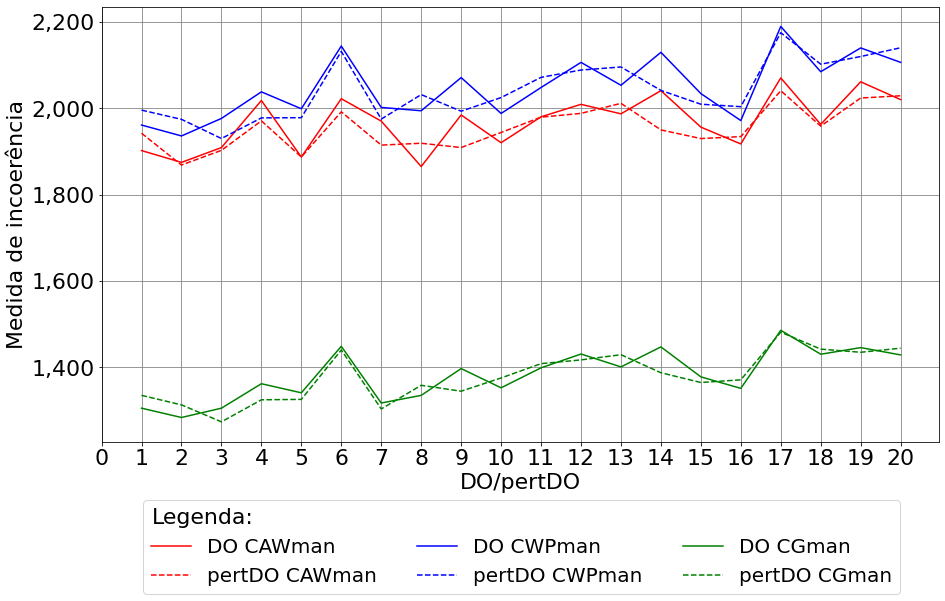

In [ ]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_CmanCAW, 
                   lista_perturbado_CmanCAW, 
                   lista_original_CmanCWP, 
                   lista_perturbado_CmanCWP, 
                   lista_original_CmanCG, 
                   lista_perturbado_CmanCG,
                   medida = medida)

In [ ]:
print("Diferença entre as equação CAW      :", getSomatorioDiferencaAbsoluta(lista_original_CmanCAW, lista_perturbado_CmanCAW))
print("Diferença entre as equação CWP      :", getSomatorioDiferencaAbsoluta(lista_original_CmanCWP, lista_perturbado_CmanCWP))
print("Diferença entre as equação CG       :", getSomatorioDiferencaAbsoluta(lista_original_CmanCG, lista_perturbado_CmanCG))

Diferença entre as equação CAW      : 598.9913624908415
Diferença entre as equação CWP      : 705.4383835137087
Diferença entre as equação CG       : 450.11391234124176


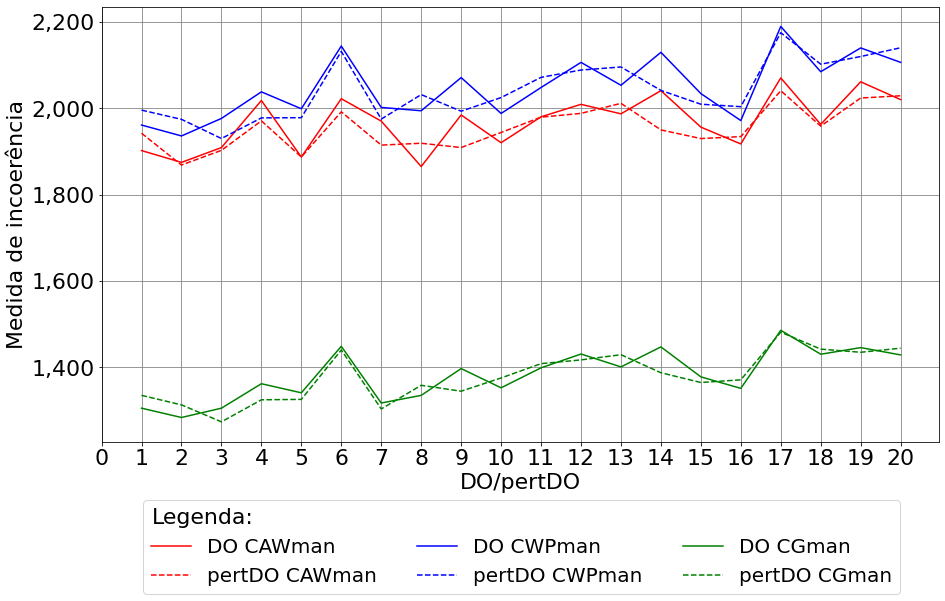

In [ ]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_CmanCAW[0:200], 
                   lista_perturbado_CmanCAW[0:200], 
                   lista_original_CmanCWP[0:200], 
                   lista_perturbado_CmanCWP[0:200], 
                   lista_original_CmanCG[0:200], 
                   lista_perturbado_CmanCG[0:200],
                   medida = medida)

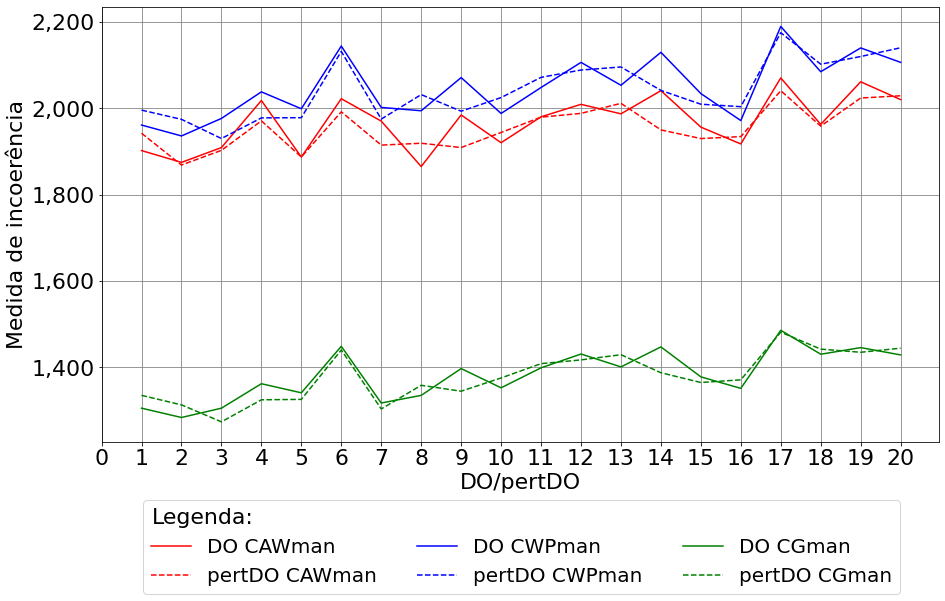

In [ ]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_CmanCAW[0:100], 
                   lista_perturbado_CmanCAW[0:100], 
                   lista_original_CmanCWP[0:100], 
                   lista_perturbado_CmanCWP[0:100], 
                   lista_original_CmanCG[0:100], 
                   lista_perturbado_CmanCG[0:100],
                   medida = medida)

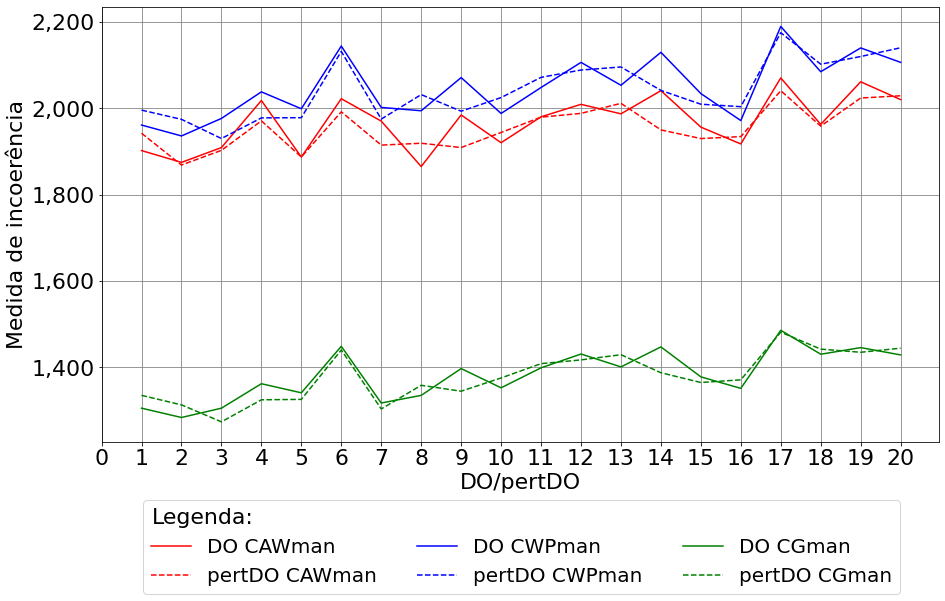

In [ ]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_CmanCAW[0:20], 
                   lista_perturbado_CmanCAW[0:20], 
                   lista_original_CmanCWP[0:20], 
                   lista_perturbado_CmanCWP[0:20], 
                   lista_original_CmanCG[0:20], 
                   lista_perturbado_CmanCG[0:20],
                   medida = medida)

#### Gráfico de linha da medida de coerência Cman ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações

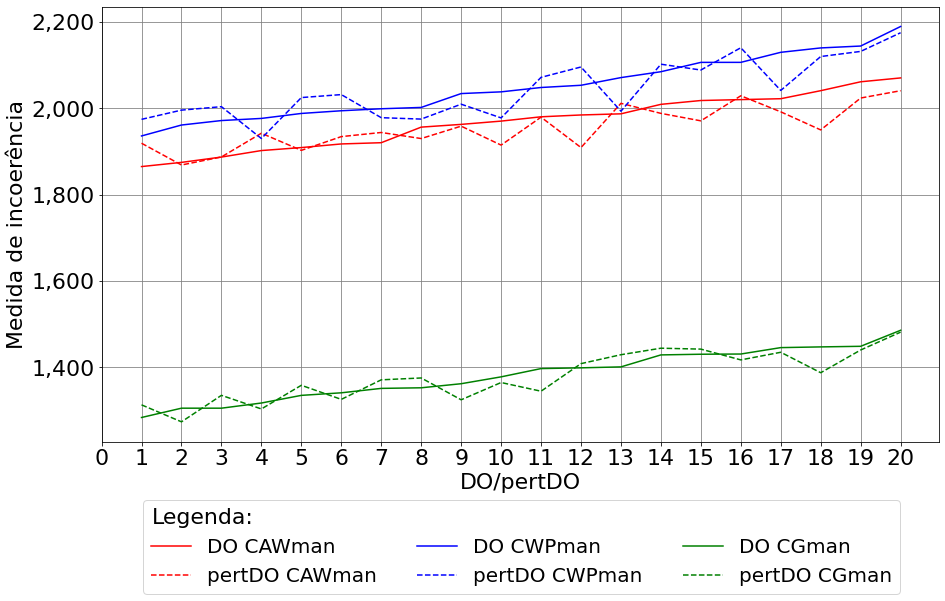

In [ ]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_ordenado_CmanCAW, 
                   lista_perturbado_ordenado_CmanCAW, 
                   lista_original_ordenado_CmanCWP, 
                   lista_perturbado_ordenado_CmanCWP, 
                   lista_original_ordenado_CmanCG, 
                   lista_perturbado_ordenado_CmanCG,
                   medida = medida)

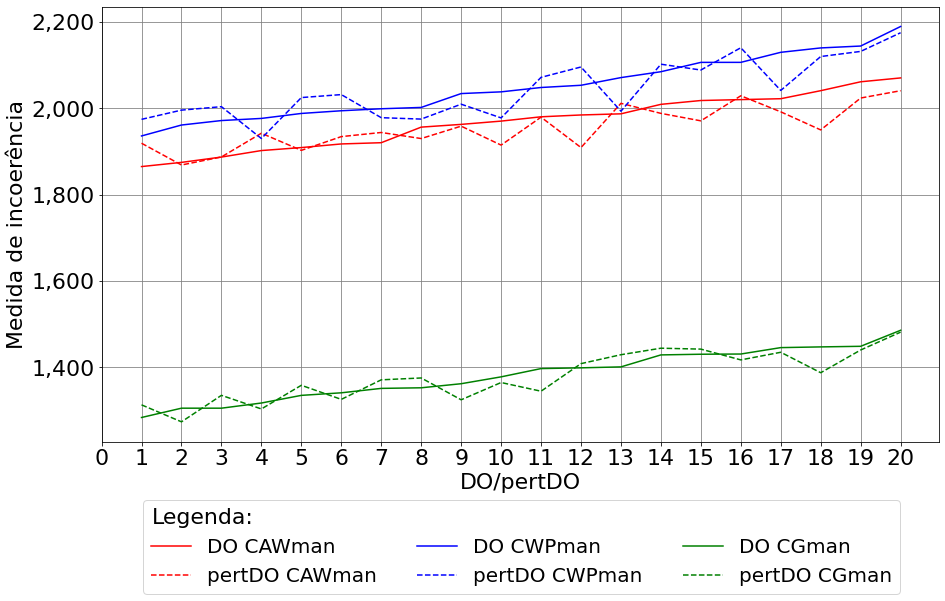

In [ ]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_ordenado_CmanCAW[0:100], 
                   lista_perturbado_ordenado_CmanCAW[0:100], 
                   lista_original_ordenado_CmanCWP[0:100], 
                   lista_perturbado_ordenado_CmanCWP[0:100], 
                   lista_original_ordenado_CmanCG[0:100], 
                   lista_perturbado_ordenado_CmanCG[0:100],
                   medida = medida)

#### Gráfico de linha da medida de coerência Cman ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando 1 equação.

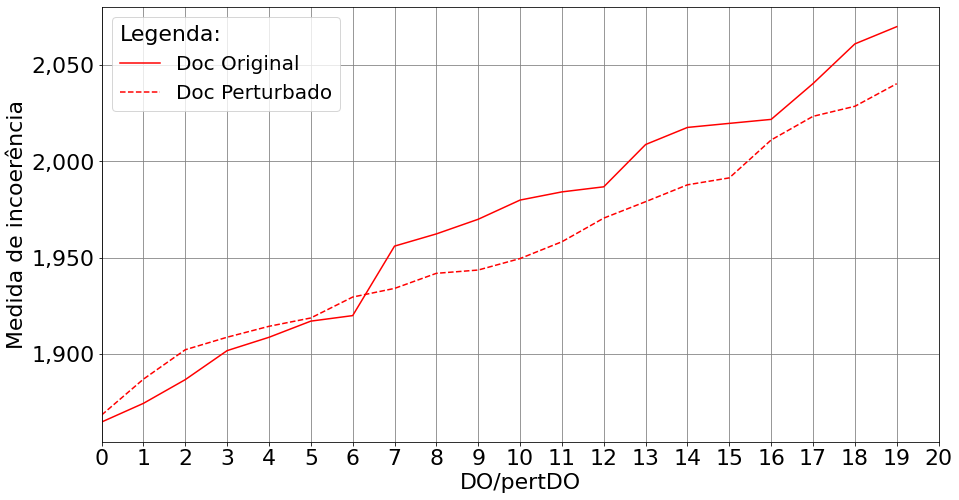

In [ ]:
graficoLinhaMedida2('Medida de incoerência', 
                    lista_original_ordenado_CmanCAW, 
                    lista_perturbado_ordenado_CmanCAW,
                    'r',
                    medida = medida)

Sem ordem

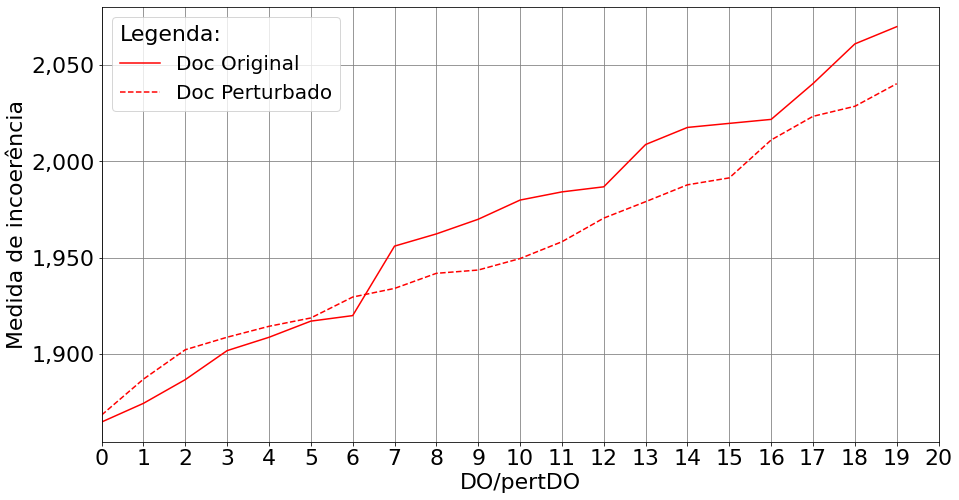

In [ ]:
graficoLinhaMedida2('Medida de incoerência', 
                    lista_original_CmanCAW, 
                    lista_perturbado_CmanCAW,
                    'r',
                    medida = medida)

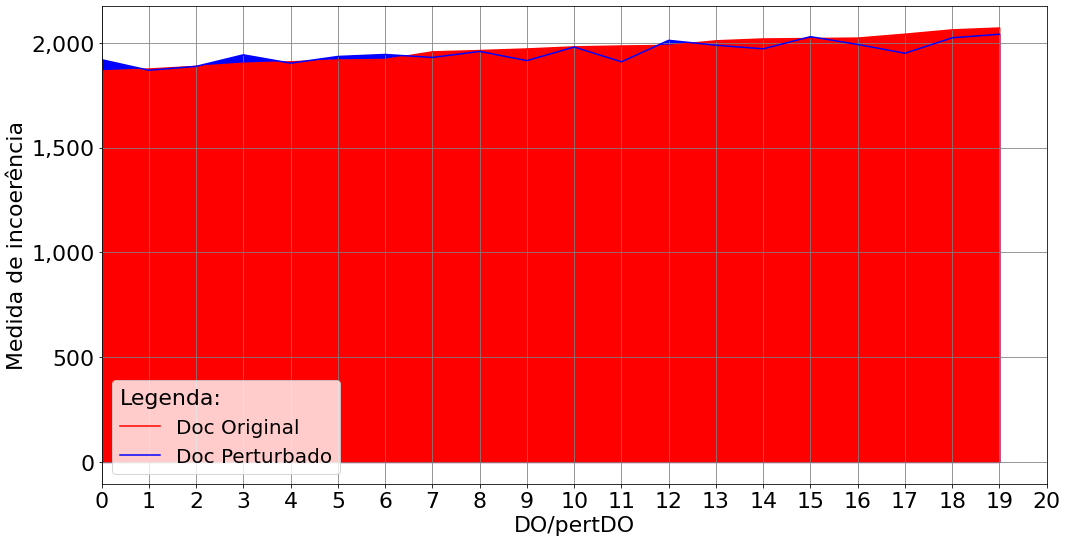

In [ ]:
graficoLinhaMedida2Preenchido('Medida de incoerência', 
                              lista_original_ordenado_CmanCAW, 
                              lista_perturbado_ordenado_CmanCAW,
                              medida = 'man')

### Somatórios das diferenças absolutas de DO com as versões perturbadas

#### Usando CAW






In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CAWman: 598.9913624908415

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5', 0.23892222222207238, 3, 'How to push elements in a stack data structure?']
['11', 0.838600000000497, 11, 'What is a queue and how to dequeue an element in it?']
['18', 4.069284615384731, 9, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['2', 6.070485714285951, 2, 'How to dequeue elements in a queue?']
['3', 6.453957142857234, 5, 'How to push elements in a stack?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['4', 47.03907777777772, 15, 'How to push and pop elements in a stack?']
['8', 53.971999999999525, 1, 'How to pop elements in a stack data structure?']
['7', 55.52801428571456, 10, 'How to pop elements from a stack?']
['9', 75.37797999999998, 12, 'What is

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman: 168.07032694083614

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5', 0.23892222222207238, 3, 'How to push elements in a stack data structure?']
['20', 8.856690909090958, 16, 'In a queue does the enqueue operation occur at which end?']
['16', 16.96724166666627, 6, 'What is a queue and how to enqueue and dequeue its elements?']
['10', 23.642389999999978, 7, 'What is a queue and how to enqueue its element?']
['13', 24.297425000000203, 13, 'What is a queue and how to enqueue an element in it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['16', 16.96724166666627, 6, 'What is a queue and how to enqueue and dequeue its elements?']
['10', 23.64238

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 8
DO: How to pop elements in a stack data structure?
     SCONJ PART VERB NOUN ADP DET NOUN NOUN NOUN PUNCT 
  1 - How to pop elements in a queue data structure ? [stack(>CAWman(DO)=1864,7262555556) -> queue(CAWman(pertDO)=1918,6982555556)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 8
DO: How to pop elements in a stack data structure?
     SCONJ PART VERB NOUN ADP DET NOUN NOUN NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
8_pert_0;How to pop elements in a queue data structure ?;stack;NOUN;1864,7262555556;1993,8202688889;1335,4460200000;queue;NOUN;1918,6982555556;2031,2202022222;1358,7548300000;1,0000000000;0;1


##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWman: 430.9210355500054

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['11', 0.838600000000497, 11, 'What is a queue and how to dequeue an element in it?']
['18', 4.069284615384731, 9, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['2', 6.070485714285951, 2, 'How to dequeue elements in a queue?']
['3', 6.453957142857234, 5, 'How to push elements in a stack?']
['12', 20.900208333333012, 14, 'What is a stack and how to pop an element from it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['19', 37.56741818181831, 19, 'In a stack does the pop operation occur at which end?']
['4', 47.03907777777772, 15, 'How to push 

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 14
DO: What is a stack and how to push an element on it?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB DET NOUN ADP PRON PUNCT 
  1 - What is a queue and how to push an element on it ? [stack(CAWman(DO)=2040,2665083333) -> queue(>CAWman(pertDO)=1949,5211166667)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 14
DO: What is a stack and how to push an element on it?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB DET NOUN ADP PRON PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
14_pert_0;What is a queue and how to push an element on it ?;stack;NOUN;2040,2665083333;2129,0385089744;1447,5612846154;queue;NOUN;1949,5211166667;2040,8488820513;1387,8300307692;1,0000000000;0;1


#### Usando CWP

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CWPman: 705.4383835137087

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CWPman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['6', 12.448146969697063, 19, 'How to push and pop elements in a stack data structure?']
['17', 14.434746153845936, 20, 'How are the operations to push and pop elements in a stack implemented?']
['18', 17.392854505494597, 14, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['12', 17.689173076924817, 15, 'What is a stack and how to pop an element from it?']
['19', 19.89185000000043, 18, 'In a stack does the pop operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['13', 42.32679743589733, 12, 'What is a queue and how to enqueue an element in it?']
['3', 46.4779500000011, 4, 'How to push elements in a stack?']
['4', 60.22608444444313, 10, 'Ho

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman: 296.12385136696525

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['18', 17.392854505494597, 14, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['11', 23.474216666666734, 11, 'What is a queue and how to dequeue an element in it?']
['16', 32.10338589743674, 3, 'What is a queue and how to enqueue and dequeue its elements?']
['20', 33.80636060606048, 16, 'In a queue does the enqueue operation occur at which end?']
['1', 34.47064642857026, 2, 'How to enqueue elements in a queue?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['1', 34.47064642857026, 2, 'How to enqueue elements in a queue?']
['10', 36.7331636363

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 13
DO: What is a queue and how to enqueue an element in it?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB DET NOUN ADP PRON PUNCT 
  1 - What is a stack and how to enqueue an element in it ? [queue(>CWPman(DO)=2052,7774782051) -> stack(CWPman(pertDO)=2095,1042756410)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 13
DO: What is a queue and how to enqueue an element in it?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB DET NOUN ADP PRON PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
13_pert_0;What is a stack and how to enqueue an element in it ?;queue;NOUN;1986,7261333333;2052,7774782051;1401,3259261538;stack;NOUN;2011,0235583333;2095,1042756410;1429,4888923077;1,0000000000;0;1


##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPman: 409.31453214674343

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['6', 12.448146969697063, 19, 'How to push and pop elements in a stack data structure?']
['17', 14.434746153845936, 20, 'How are the operations to push and pop elements in a stack implemented?']
['12', 17.689173076924817, 15, 'What is a stack and how to pop an element from it?']
['19', 19.89185000000043, 18, 'In a stack does the pop operation occur at which end?']
['5', 20.64610000000016, 7, 'How to push elements in a stack data structure?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7', 26.96230714285639, 8, 'How to pop elements from a stack?']
['3', 46.4779500000011, 4, 

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 14
DO: What is a stack and how to push an element on it?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB DET NOUN ADP PRON PUNCT 
  1 - What is a queue and how to push an element on it ? [stack(CWPman(DO)=2129,0385089744) -> queue(>CWPman(pertDO)=2040,8488820513)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 14
DO: What is a stack and how to push an element on it?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB DET NOUN ADP PRON PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
14_pert_0;What is a queue and how to push an element on it ?;stack;NOUN;2040,2665083333;2129,0385089744;1447,5612846154;queue;NOUN;1949,5211166667;2040,8488820513;1387,8300307692;1,0000000000;0;1


#### Usando CG

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CGman: 450.11391234124176

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CGman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['17', 4.319971428570625, 20, 'How are the operations to push and pop elements in a stack implemented?']
['6', 8.530700000000252, 19, 'How to push and pop elements in a stack data structure?']
['11', 9.721453846153508, 12, 'What is a queue and how to dequeue an element in it?']
['19', 10.77406666666684, 17, 'In a stack does the pop operation occur at which end?']
['18', 11.835852142857448, 15, 'How are the operations to enqueue and dequeue elements in a queue implemented?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['1', 29.711232499999824, 3, 'How to enqueue elements in a queue?']
['3', 31.551833750000014, 2, 'How to push elements in a stack?']
['4', 37.182924000000185, 9, 'How to push and pop 

###### Usando CG onde Cm(pertDO)>Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman: 190.03077180194805

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['11', 9.721453846153508, 12, 'What is a queue and how to dequeue an element in it?']
['18', 11.835852142857448, 15, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['20', 15.513775000000123, 14, 'In a queue does the enqueue operation occur at which end?']
['16', 19.797360000000026, 7, 'What is a queue and how to enqueue and dequeue its elements?']
['10', 22.739690909090996, 8, 'What is a queue and how to enqueue its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['10', 22.739690909090996, 8, 'What is a queue and how to enqueue its elem

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "1"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to enqueue elements in a stack ?' [queue(>CGman(DO)=1305,8033550000) -> stack(CGman(pertDO)=1335,5145875000)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
1_pert_0;How to enqueue elements in a stack ?';queue;NOUN;1901,7641571429;1960,8245142857;1305,8033550000;stack;NOUN;1941,8598142857;1995,2951607143;1335,5145875000;1,0000000000;0;1


###### Usando CG onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGman: 260.0831405392937

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['17', 4.319971428570625, 20, 'How are the operations to push and pop elements in a stack implemented?']
['6', 8.530700000000252, 19, 'How to push and pop elements in a stack data structure?']
['19', 10.77406666666684, 17, 'In a stack does the pop operation occur at which end?']
['15', 13.10215384615367, 10, 'What is a stack and how to push and pop its elements?']
['12', 13.608384615384239, 16, 'What is a stack and how to pop an element from it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['5', 15.196919999999864, 6, 'How to push elements in a stack data structure?']
['3', 31.

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 14
DO: What is a stack and how to push an element on it?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB DET NOUN ADP PRON PUNCT 
  1 - What is a queue and how to push an element on it ? [stack(CGman(DO)=1447,5612846154) -> queue(>CGman(pertDO)=1387,8300307692)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 14
DO: What is a stack and how to push an element on it?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB DET NOUN ADP PRON PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
14_pert_0;What is a queue and how to push an element on it ?;stack;NOUN;2040,2665083333;2129,0385089744;1447,5612846154;queue;NOUN;1949,5211166667;2040,8488820513;1387,8300307692;1,0000000000;0;1


### Amplitudes medidas de DO com as versões perturbadas

#### Usando CAW






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CAWman: 260.0831405392937

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5', 0.23892222222207238, 3, 'How to push elements in a stack data structure?']
['11', 0.838600000000497, 11, 'What is a queue and how to dequeue an element in it?']
['18', 4.069284615384731, 9, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['2', 6.070485714285951, 2, 'How to dequeue elements in a queue?']
['3', 6.453957142857234, 5, 'How to push elements in a stack?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['4', 47.03907777777772, 15, 'How to push and pop elements in a stack?']
['8', 53.971999999999525, 1, 'How to pop elements in a stack data structure?']
['7', 55.52801428571456, 10, 'How to pop elements 

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman: 260.0831405392937

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5', 0.23892222222207238, 3, 'How to push elements in a stack data structure?']
['20', 8.856690909090958, 16, 'In a queue does the enqueue operation occur at which end?']
['16', 16.96724166666627, 6, 'What is a queue and how to enqueue and dequeue its elements?']
['10', 23.642389999999978, 7, 'What is a queue and how to enqueue its element?']
['13', 24.297425000000203, 13, 'What is a queue and how to enqueue an element in it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['16', 16.96724166666627, 6, 'What is a queue and how to enqueue and dequeue its elements?']
['10', 23.642389999999978,

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 8
DO: How to pop elements in a stack data structure?
     SCONJ PART VERB NOUN ADP DET NOUN NOUN NOUN PUNCT 
  1 - How to pop elements in a queue data structure ? [stack(>CAWman(DO)=1864,7262555556) -> queue(CAWman(pertDO)=1918,6982555556)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 8
DO: How to pop elements in a stack data structure?
     SCONJ PART VERB NOUN ADP DET NOUN NOUN NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
8_pert_0;How to pop elements in a queue data structure ?;stack;NOUN;1864,7262555556;1993,8202688889;1335,4460200000;queue;NOUN;1918,6982555556;2031,2202022222;1358,7548300000;1,0000000000;0;1


##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWman: 260.0831405392937

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['11', 0.838600000000497, 11, 'What is a queue and how to dequeue an element in it?']
['18', 4.069284615384731, 9, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['2', 6.070485714285951, 2, 'How to dequeue elements in a queue?']
['3', 6.453957142857234, 5, 'How to push elements in a stack?']
['12', 20.900208333333012, 14, 'What is a stack and how to pop an element from it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['19', 37.56741818181831, 19, 'In a stack does the pop operation occur at which end?']
['4', 47.03907777777772, 15, 'How to push and pop el

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 14
DO: What is a stack and how to push an element on it?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB DET NOUN ADP PRON PUNCT 
  1 - What is a queue and how to push an element on it ? [stack(CAWman(DO)=2040,2665083333) -> queue(>CAWman(pertDO)=1949,5211166667)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 14
DO: What is a stack and how to push an element on it?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB DET NOUN ADP PRON PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
14_pert_0;What is a queue and how to push an element on it ?;stack;NOUN;2040,2665083333;2129,0385089744;1447,5612846154;queue;NOUN;1949,5211166667;2040,8488820513;1387,8300307692;1,0000000000;0;1


#### Usando CWP






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CWPman: 260.0831405392937

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['6', 12.448146969697063, 19, 'How to push and pop elements in a stack data structure?']
['17', 14.434746153845936, 20, 'How are the operations to push and pop elements in a stack implemented?']
['18', 17.392854505494597, 14, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['12', 17.689173076924817, 15, 'What is a stack and how to pop an element from it?']
['19', 19.89185000000043, 18, 'In a stack does the pop operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['13', 42.32679743589733, 12, 'What is a queue and how to enqueue an element in it?']
['3', 46.4779500000011, 4, 'How to push eleme

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman: 260.0831405392937

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['18', 17.392854505494597, 14, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['11', 23.474216666666734, 11, 'What is a queue and how to dequeue an element in it?']
['16', 32.10338589743674, 3, 'What is a queue and how to enqueue and dequeue its elements?']
['20', 33.80636060606048, 16, 'In a queue does the enqueue operation occur at which end?']
['1', 34.47064642857026, 2, 'How to enqueue elements in a queue?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['1', 34.47064642857026, 2, 'How to enqueue elements in a queue?']
['10', 36.73316363636286, 5, 'What

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 13
DO: What is a queue and how to enqueue an element in it?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB DET NOUN ADP PRON PUNCT 
  1 - What is a stack and how to enqueue an element in it ? [queue(>CAWman(DO)=1986,7261333333) -> stack(CAWman(pertDO)=2011,0235583333)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 13
DO: What is a queue and how to enqueue an element in it?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB DET NOUN ADP PRON PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
13_pert_0;What is a stack and how to enqueue an element in it ?;queue;NOUN;1986,7261333333;2052,7774782051;1401,3259261538;stack;NOUN;2011,0235583333;2095,1042756410;1429,4888923077;1,0000000000;0;1


##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPman: 260.0831405392937

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['6', 12.448146969697063, 19, 'How to push and pop elements in a stack data structure?']
['17', 14.434746153845936, 20, 'How are the operations to push and pop elements in a stack implemented?']
['12', 17.689173076924817, 15, 'What is a stack and how to pop an element from it?']
['19', 19.89185000000043, 18, 'In a stack does the pop operation occur at which end?']
['5', 20.64610000000016, 7, 'How to push elements in a stack data structure?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7', 26.96230714285639, 8, 'How to pop elements from a stack?']
['3', 46.4779500000011, 4, 'How to push e

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 14
DO: What is a stack and how to push an element on it?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB DET NOUN ADP PRON PUNCT 
  1 - What is a queue and how to push an element on it ? [stack(CAWman(DO)=2040,2665083333) -> queue(>CAWman(pertDO)=1949,5211166667)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 14
DO: What is a stack and how to push an element on it?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB DET NOUN ADP PRON PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
14_pert_0;What is a queue and how to push an element on it ?;stack;NOUN;2040,2665083333;2129,0385089744;1447,5612846154;queue;NOUN;1949,5211166667;2040,8488820513;1387,8300307692;1,0000000000;0;1


#### Usando CG






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CGman: 260.0831405392937

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['17', 4.319971428570625, 20, 'How are the operations to push and pop elements in a stack implemented?']
['6', 8.530700000000252, 19, 'How to push and pop elements in a stack data structure?']
['11', 9.721453846153508, 12, 'What is a queue and how to dequeue an element in it?']
['19', 10.77406666666684, 17, 'In a stack does the pop operation occur at which end?']
['18', 11.835852142857448, 15, 'How are the operations to enqueue and dequeue elements in a queue implemented?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['1', 29.711232499999824, 3, 'How to enqueue elements in a queue?']
['3', 31.551833750000014, 2, 'How to push elements in a stack?']
[

##### Usando CG onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman: 260.0831405392937

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['11', 9.721453846153508, 12, 'What is a queue and how to dequeue an element in it?']
['18', 11.835852142857448, 15, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['20', 15.513775000000123, 14, 'In a queue does the enqueue operation occur at which end?']
['16', 19.797360000000026, 7, 'What is a queue and how to enqueue and dequeue its elements?']
['10', 22.739690909090996, 8, 'What is a queue and how to enqueue its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['10', 22.739690909090996, 8, 'What is a queue and how to enqueue its element?']
['8', 2

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to enqueue elements in a stack ?' [queue(>CAWman(DO)=1901,7641571429) -> stack(CAWman(pertDO)=1941,8598142857)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
1_pert_0;How to enqueue elements in a stack ?';queue;NOUN;1901,7641571429;1960,8245142857;1305,8033550000;stack;NOUN;1941,8598142857;1995,2951607143;1335,5145875000;1,0000000000;0;1


##### Usando CG onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGman: 260.0831405392937

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['17', 4.319971428570625, 20, 'How are the operations to push and pop elements in a stack implemented?']
['6', 8.530700000000252, 19, 'How to push and pop elements in a stack data structure?']
['19', 10.77406666666684, 17, 'In a stack does the pop operation occur at which end?']
['15', 13.10215384615367, 10, 'What is a stack and how to push and pop its elements?']
['12', 13.608384615384239, 16, 'What is a stack and how to pop an element from it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['5', 15.196919999999864, 6, 'How to push elements in a stack data structure?']
['3', 31.5518337500000

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 14
DO: What is a stack and how to push an element on it?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB DET NOUN ADP PRON PUNCT 
  1 - What is a queue and how to push an element on it ? [stack(CAWman(DO)=2040,2665083333) -> queue(>CAWman(pertDO)=1949,5211166667)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 14
DO: What is a stack and how to push an element on it?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB DET NOUN ADP PRON PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
14_pert_0;What is a queue and how to push an element on it ?;stack;NOUN;2040,2665083333;2129,0385089744;1447,5612846154;queue;NOUN;1949,5211166667;2040,8488820513;1387,8300307692;1,0000000000;0;1


# 4 Finalização

## 4.1 Tempo final de processamento



In [ ]:
 # Pega o tempo atual menos o tempo do início do processamento.
final_processamento = time.time()
tempo_total_processamento = formataTempo(final_processamento - inicio_processamento)

print('')
print('  Tempo processamento:  {:} (h:mm:ss)'.format(tempo_total_processamento))


  Tempo processamento:  0:01:17 (h:mm:ss)
